# Your own recommender system

In this task we will take a look at music recommendations.

You will compare iALS with item-based recommendations and a simple bestsellers baseline by NDCG.

This assignment is graded by your `submission.json`.

The cell below creates a valid `submission.json` file, fill your answers in there. 

You can press "Submit Assignment" at any time to submit partial progress.

In [77]:
%%file submission.json
{
    "q1": 0.661,
    "q2": 0.710,
    "q3": "OneRepublic",
    "q4": 0.702
}

Overwriting submission.json


# Imports

In [3]:
%config IPCompleter.greedy=True
%env OPENBLAS_NUM_THREADS=1
import pandas as pd
import implicit
from sklearn.model_selection import train_test_split
import scipy.sparse as sps
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict

env: OPENBLAS_NUM_THREADS=1


# Yandex.Music dataset

In [4]:
! ls -lh yandex_music

total 3.7M
-rwxrwxrwx 1 nobody nogroup 3.7M Jan 23 20:59 artists.jsonl
lrwxrwxrwx 1 nobody nogroup   44 Mar 25 00:43 events.csv -> /home/jovyan/work-ro/yandex_music/events.csv
-rwxrwxrwx 1 nobody nogroup  254 Jan 23 20:59 README.txt


In [5]:
! head -n 5 yandex_music/artists.jsonl

{"artistId":0,"artistName":"Mack Gordon"}
{"artistId":1,"artistName":"Kenny Dorham"}
{"artistId":2,"artistName":"Max Roach"}
{"artistId":3,"artistName":"Francis Rossi"}
{"artistId":4,"artistName":"Status Quo"}


In [6]:
! head -n 5 yandex_music/events.csv

userId,artistId,plays,skips
0,335,1,0
0,708,1,0
0,710,2,1
0,815,1,1


# Loading dataset

In [7]:
artists = pd.read_json("yandex_music/artists.jsonl", orient='records', lines=True)
print(artists.dtypes)
artists.head(5)

artistId       int64
artistName    object
dtype: object


,artistId,artistName
0,0,Mack Gordon
1,1,Kenny Dorham
2,2,Max Roach
3,3,Francis Rossi
4,4,Status Quo


In [6]:
artists[artists.artistName == 'Maroon 5']

,artistId,artistName
14803,14803,Maroon 5


In [43]:
df = pd.DataFrame.from_dict(dic, orient = 'index', columns = ['value'])

In [45]:
df.index = pd.MultiIndex.from_tuples(df.index)

In [55]:
# df.loc[14803].sort_values(by = 'value', ascending = False)
df.loc[14803].loc[64396]

value    0.04682
Name: 64396, dtype: float64

In [48]:
artists[artists.artistId == 3568]

,artistId,artistName
3568,3568,OneRepublic


In [8]:
events = pd.read_csv("yandex_music/events.csv")
print(events.dtypes)
events.head()

userId      int64
artistId    int64
plays       int64
skips       int64
dtype: object


,userId,artistId,plays,skips
0,0,335,1,0
1,0,708,1,0
2,0,710,2,1
3,0,815,1,1
4,0,880,1,1


In [8]:
# statistics
print("users:", len(set(events.userId)))
print("items:", len(set(events.artistId)))
print("interactions:", len(events))
print("density:", len(events) / (len(set(events.userId)) * len(set(events.artistId))))

users: 4999
items: 53031
interactions: 3412504
density: 0.012872420423252307


In [9]:
# most popular artists
(
    events
    .merge(artists)[['artistName', 'plays']]
    .groupby("artistName").sum()
    .sort_values('plays', ascending=False)
    .head(10)
)

,plays
artistName,
Imagine Dragons,43447
Би-2,29415
Баста,27264
Ленинград,26311
Сплин,25062
Queen,24905
Sia,22803
LOBODA,21923
Noize MC,21774


In [9]:
# train / test split
train, test = train_test_split(events, test_size=0.05, random_state=0)
print(train.shape)
print(test.shape)

(3241878, 4)
(170626, 4)


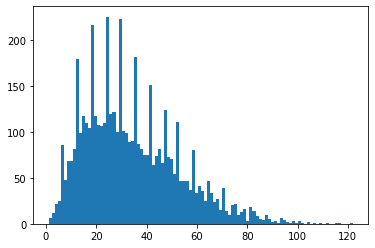

In [11]:
# number of artists per user in the test set
_ = plt.hist(test.groupby('userId').count()['plays'], bins=100)

# Train iALS

Let's say that confidence is `1 + 10 * log2(plays + 1)`

In [10]:
# prepare matrix for implicit library (https://implicit.readthedocs.io/en/latest/models.html)
# item_user (sparse csr_matrix) of item/user/confidence
# csc_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#     where ``data``, ``row_ind`` and ``col_ind`` satisfy the
#     relationship ``a[row_ind[k], col_ind[k]] = data[k]``.

item_user_train = sps.csc_matrix((1 + 10 * np.log2(train.plays + 1), (train.artistId, train.userId)))
item_user_train

<70818x4999 sparse matrix of type '<class 'numpy.float64'>'
	with 3241878 stored elements in Compressed Sparse Column format>

In [13]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=32, iterations=10, random_state=0)
model.fit(item_user_train)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 44.9 s, sys: 29 s, total: 1min 13s
Wall time: 36.9 s


# Similar artists (via iALS)

Let's find similar artists by cosine between their embeddings

In [14]:
target_artists = artists[artists.artistName.isin(['Coldplay', '50 Cent', 'AC/DC'])]
target_artists

,artistId,artistName
404,404,Coldplay
647,647,50 Cent
33965,33965,AC/DC


In [15]:
artist_to_name = dict(zip(artists.artistId, artists.artistName))
for _, row in target_artists.iterrows():
    print("#############", row.artistName, "#############")
    for a, s in model.similar_items(row.artistId, N=5):
        print(artist_to_name[a], "\t", s)

############# Coldplay #############
Coldplay 	 1.0
Lana Del Rey 	 0.98834753
OneRepublic 	 0.9833125
Adele 	 0.97822386
Maroon 5 	 0.97764593
############# 50 Cent #############
50 Cent 	 1.0000001
Dr. Dre 	 0.92829037
2Chainz 	 0.9079147
Lil Jon 	 0.897764
Akon 	 0.89693296
############# AC/DC #############
AC/DC 	 1.0
The Offspring 	 0.95378405
Red Hot Chili Peppers 	 0.94767326
Nirvana 	 0.9461752
Metallica 	 0.943833


# NDCG metric

In [72]:
from sklearn.metrics import ndcg_score

In [17]:
# how ndcg works in sklearn (true scores are used without exponentiation)
print(ndcg_score(y_true=[[  0,   0,   2,   1,   0]], 
                 y_score=[[0.2, 0.1, 0.5, 0.3, 0.4]]))
print((2 / np.log(1 + 1) + 1 / np.log(3 + 1)) / 
      (2 / np.log(1 + 1) + 1 / np.log(2 + 1)))

0.9502344167898358
0.9502344167898358


# NDCG for baseline

__q1: Let's compute NDCG for non-personalized baseline on the test set.__

Let's say that we rank test artists for each user by their global popularity (the sum of plays in the training dataset).

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [18]:
train_data = train.groupby('artistId', as_index = False).sum()
train_data = train_data[['artistId', 'plays']]
train_data

,artistId,plays
0,1,6
1,2,7
2,4,1230
3,5,16
4,6,7
...,...,...
52657,70805,2
52658,70811,756
52659,70813,2
52660,70816,38


In [20]:
# train_df = train.groupby('userId').sum()
intersection = pd.merge(train_data, test_data, on = 'artistId', suffixes = ['_train', '_test'], how = 'inner')
intersection

,artistId,plays_train,userId,plays_test,skips
0,1,6,2788,1,0
1,2,7,2262,1,0
2,4,1230,34,1,1
3,4,1230,51,0,1
4,4,1230,81,0,2
...,...,...,...,...,...
170237,70811,756,4718,0,1
170238,70811,756,4807,1,2
170239,70811,756,4997,2,5
170240,70813,2,3374,0,1


In [21]:
intersection = intersection.set_index('userId')

In [11]:
test_data = test.groupby(['userId','artistId'], as_index = False).sum()
test_data

,userId,artistId,plays,skips
0,0,261,0,1
1,0,708,1,0
2,0,880,1,1
3,0,1231,1,0
4,0,2571,0,2
...,...,...,...,...
170621,4998,19453,0,1
170622,4998,40670,0,1
170623,4998,48326,0,1
170624,4998,53743,0,1


In [25]:
intersection.loc[0]

,artistId,plays_train,plays_test,skips
userId,,,,
0,261,1356,0,1
0,708,955,1,0
0,880,225,1,1
0,1231,247,1,0
0,2571,1464,0,2
0,2681,765,0,2
0,5954,52,1,0
0,13772,191,9,0
0,13940,2517,1,0


In [22]:
# YOUR CODE HERE
scores = []
for id in intersection.index.unique("userId"):
    y_t = np.asarray([intersection.loc[id]['plays_test'].tolist()])
    y_p = np.asarray([intersection.loc[id]['plays_train'].tolist()])
    try:
        if len(y_t[0]) > 1:
            score = ndcg_score(y_t, y_p)
            scores.append(score)
    except TypeError:
        continue

In [23]:
np.array(scores).mean()

0.6612094115039637

# NDCG for iALS

__q2: Now let's replace global popularity with iALS prediction for each user.__

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [24]:
# prediction for user 100 and item 200 (a simple dot product):
print(model.user_factors[100].dot(model.item_factors[200]))

-0.0001732558


In [25]:
# YOUR CODE HERE
test_data = test_data.set_index('userId')

In [26]:
print(model.user_factors[0].dot(model.item_factors[261]))

0.65930474


In [27]:
test_data.head(5)

,artistId,plays,skips
userId,,,
0,261,0,1
0,708,1,0
0,880,1,1
0,1231,1,0
0,2571,0,2


In [28]:
scores = []

In [29]:
for id in test_data.index.unique("userId"):
    y_t = np.asarray([test_data.loc[id]['plays'].tolist()])
    artists = test_data.loc[id]['artistId'].tolist()
    try:
        if len(y_t[0]) > 1:
            y_predict = [model.user_factors[id].dot(model.item_factors[artist]) for artist in artists]
            y_p = np.asarray([y_predict])
            score = ndcg_score(y_t, y_p)
            scores.append(score)
    except TypeError:
        continue

In [30]:
np.array(scores).mean()

0.709517848993041

# Jaccard similarities

Let's compute Jaccard similarities for pairs of artists in the training dataset. 

Here're some details:
- Take into account only artists that the user has played at least 3 times (to cut off random plays).
- Compute jacccard similarity only for pairs that have at least 50 common users (to get confident estimates).

__q3: We will use it to recommend similar artists for users in the test set, but first let's find most similar artist to "Maroon 5" (other than "Maroon 5").__

In [12]:
# each user has less than N=1000 artists, so N^2 is not that big
(
    train[train.plays >= 3]
    .groupby("userId").count()
    .sort_values("plays", ascending=False)
    .head(5)
)

,artistId,plays,skips
userId,,,
4689,614,614,614
4575,550,550,550
3121,548,548,548
2266,497,497,497
1168,479,479,479


In [25]:
train_data1 = (
    train[train.plays >= 3]
    .groupby(['userId', 'artistId'], as_index = False).sum()
)

In [36]:
train_data_dict = train_data1[['userId', 'artistId']]
train_data_dict = train_data_dict.set_index(['artistId'])
train_data_dict.loc[153]

,userId
artistId,
153,0
153,64
153,86
153,135
153,218
...,...
153,4572
153,4682
153,4836


In [39]:
train_artist_dict = dict()

for id in train_data_dict.index.unique("artistId"):
    try:
        train_artist_dict[id] = list(train_data_dict.loc[id]['userId'])
    except TypeError:
        print(train_data_dict.loc[id]['userId'])

2
2
2
2
2
2
3
4
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
9
10
10
12
12
12
12
22
23
23
24
26
26
26
35
35
36
36
36
36
36
36
37
38
38
39
39
39
39
39
39
39
41
45
45
48
48
55
56
56
56
56
62
63
64
64
64
64
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
70
70
70
70
70
70
70
71
71
71
72
73
73
73
73
74
76
76
77
77
77
77
77
77
78
79
85
85
85
85
85
85
85
85
85
85
85
85
85
86
87
89
89
91
91
91
91
91
91
92
92
92
95
95
95
95
95
97
97
98
98
98
98
98
99
99
103
103
103
103
103
104
107
109
109
112
112
113
113
113
113
113
113
114
114
114
114
120
121
121
121
122
124
125
125
125
125
126
126
126
129
129
131
132
132
132
134
136
136
136
136
137
137
137
137
137
137
137
137
138
138
145
145
145
145
146
148
148
148
149
149
152
152
154
157
164
164
164
164
164
165
169
169
169
169
169
171
171
171
171
171
171
171
171
171
171
173
173
174
177
177
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
179
183
183
184
184
184
184
184
184
184
184
186
186
186
186
187
187
188
188
188


1143
1144
1145
1146
1146
1146
1146
1146
1146
1146
1146
1149
1149
1149
1149
1150
1150
1150
1150
1150
1150
1152
1152
1152
1153
1153
1153
1153
1153
1153
1153
1153
1153
1153
1155
1156
1157
1157
1157
1157
1158
1158
1160
1161
1161
1162
1162
1163
1163
1163
1163
1163
1163
1164
1164
1164
1164
1164
1165
1165
1165
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1166
1167
1168
1169
1169
1169
1169
1169
1170
1170
1170
1170
1170
1173
1177
1177
1178
1178
1178
1179
1179
1179
1181
1183
1184
1185
1187
1188
1188
1188
1188
1190
1190
1191
1192
1192
1192
1192
1192
1192
1193
1194
1195
1195
1195
1195
1196
1196
1196
1196
1196
1196
1196
1197
1198
1198
1198
1198
1200
1200
1202
1202
1202
1203
1203
1203
1203
1203
1203
1203
1208
1208
1209
1211
1211
1211
1212
1212
1212
1214
1214
1217
1217
1217
1218
1218
1218
1218
1219


1946
1946
1946
1949
1949
1951
1951
1955
1956
1956
1959
1959
1960
1961
1965
1965
1967
1967
1967
1967
1967
1967
1968
1968
1968
1970
1970
1971
1971
1971
1971
1976
1976
1976
1976
1976
1976
1976
1978
1978
1978
1978
1978
1979
1979
1980
1980
1986
1987
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1991
1992
1993
1995
1996
1997
1997
1997
1997
1997
1997
1997
1997
1997
1997
1998
1998
1998
2000
2000
2000
2000
2001
2001
2001
2001
2002
2002
2002
2002
2002
2002
2003
2003
2003
2003
2003
2010
2010
2010
2010
2010
2010
2010
2010
2010
2010
2010
2010
2010
2010
2010
2012
2013
2014
2020
2020
2021
2022
2022
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2024
2026
2026
2026
2026
2026
2026
2026
2026
2027
2028
2028
2028
2036
2038
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2040
2041
2041
2045
2047
2047
2049
2049
2049
2049
2052
2053
2054
2054
2054
2054
2054
2054
2054
2054
2054


2709
2709
2709
2709
2709
2709
2709
2709
2709
2709
2711
2711
2711
2711
2711
2715
2715
2717
2717
2717
2717
2717
2718
2718
2719
2719
2719
2724
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2728
2729
2729
2729
2729
2729
2729
2729
2729
2729
2729
2729
2729
2729
2729
2729
2730
2730
2730
2730
2730
2730
2731
2731
2731
2731
2731
2731
2731
2731
2731
2731
2733
2733
2733
2734
2734
2735
2736
2736
2736
2736
2736
2736
2736
2738
2739
2739
2742
2743
2743
2743
2743
2743
2743
2743
2743
2743
2743
2743
2743
2744
2745
2745
2745
2745
2745
2746
2746
2747
2747
2747
2747
2747
2747
2747
2749
2751
2751
2751
2751
2751
2751
2751
2751
2751
2751
2751
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2755
2759
2759
2759
2760
2760
2760
2761
2761
2762
2766
2767
2767


3499
3499
3501
3501
3501
3501
3501
3501
3503
3504
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3505
3508
3508
3512
3513
3513
3513
3513
3513
3520
3520
3520
3520
3520
3520
3520
3520
3520
3520
3520
3520
3520
3520
3521
3521
3526
3527
3527
3527
3527
3530
3534
3534
3536
3537
3537
3539
3539
3540
3540
3542
3544
3544
3544
3545
3546
3546
3546
3547
3549
3550
3550
3550
3553
3553
3555
3557
3557
3557
3559
3559
3559
3559
3559
3559
3559
3560
3560
3560
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3562
3563
3563
3563
3564
3564
3564
3564
3565
3565
3566
3566
3566
3567
3567
3567
3568
3568
3568
3568
3568
3569
3569
3569
3570
3571
3574
3574
3577
3579
3582
3582
3582
3582
3582
3582
3583
3583
3584
3585
3586
3586
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3587
3588
3589
3591
3591
3591
3595
3595
3595
3595
3595


4424
4424
4424
4424
4424
4424
4424
4424
4424
4428
4428
4430
4430
4430
4431
4432
4434
4434
4438
4439
4439
4439
4441
4441
4441
4441
4441
4441
4443
4444
4444
4444
4448
4448
4448
4449
4449
4449
4449
4449
4449
4454
4454
4455
4455
4464
4464
4464
4464
4464
4464
4464
4466
4468
4468
4468
4468
4471
4471
4471
4474
4474
4474
4474
4475
4475
4475
4477
4479
4479
4479
4482
4482
4482
4482
4482
4482
4484
4484
4484
4484
4485
4485
4485
4485
4485
4485
4485
4485
4485
4485
4485
4485
4485
4485
4485
4490
4490
4493
4493
4494
4498
4498
4498
4498
4498
4498
4498
4498
4498
4498
4498
4498
4498
4498
4498
4498
4503
4503
4503
4506
4509
4509
4509
4509
4509
4509
4509
4511
4511
4511
4511
4511
4513
4513
4513
4515
4515
4515
4515
4516
4516
4516
4516
4516
4519
4519
4519
4521
4521
4521
4522
4522
4522
4522
4522
4523
4524
4524
4524
4524
4525
4525
4525
4525
4526
4527
4528
4529
4530
4530
4531
4531
4531
4531
4531
4533
4533
4533
4533
4535
4535
4537
4537
4537
4538
4539
4541
4544
4544
4544
4550
4550
4550
4550
4550
4550
4550
4551
4551


In [15]:
def jaccard_score(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    
    if numer >= 50:
        return numer/denom
    else:
        return None

In [16]:
train_data1 = train_data1.set_index('artistId')

In [36]:
train_data1.loc[153].userId

artistId
153       0
153      64
153      86
153     135
153     218
       ... 
153    4572
153    4682
153    4836
153    4837
153    4845
Name: userId, Length: 70, dtype: int64

In [46]:
dic = defaultdict()

In [47]:
dic

defaultdict(None, {})

In [39]:
dic

defaultdict(None, {})

In [24]:
train_data1.set_index('userId')

,plays,skips
userId,,
0,9,1
0,3,1
0,8,3
0,4,10
0,4,1
...,...,...
4997,5,8
4997,7,6
4997,3,1


In [48]:
for id, user1 in train_artist_dict.items():
    for pair_id, user2 in train_artist_dict.items():
        if id != pair_id and (id, pair_id) not in dic:
            score = jaccard_score(set(user1), set(user2))
            if score != None:
                print(score)
                dic[(id, pair_id)] = score
                dic[(pair_id, id)] = score

0.27896995708154504
0.047453703703703706
0.12753277711561384
0.16765285996055226
0.14384920634920634
0.05649717514124294
0.19507575757575757
0.14780168381665107
0.059880239520958084
0.17736289381563594
0.09154113557358054
0.23036649214659685
0.13734567901234568
0.14091680814940577
0.12337662337662338
0.17027863777089783
0.12212943632567849
0.1867007672634271
0.04176334106728538
0.1649746192893401
0.05189620758483034
0.07936507936507936
0.23620309050772628
0.08953341740226986
0.08139534883720931
0.08876560332871013
0.056099151989562945
0.1484375
0.12698412698412698
0.08628659476117104
0.16262135922330098
0.09640522875816994
0.16921397379912664
0.052124397722295226
0.1254980079681275
0.13517915309446255
0.13333333333333333
0.12013729977116705
0.09468822170900693
0.08855721393034825
0.08360836083608361
0.12403100775193798
0.09391771019677997
0.08259587020648967
0.08673469387755102
0.12322946175637393
0.06624605678233439
0.07765957446808511
0.05734406438631791
0.17612809315866085
0.1430499

0.08392434988179669
0.05916473317865429
0.06674473067915691
0.06539833531510107
0.06090133982947625
0.11187214611872145
0.099644128113879
0.07082833133253301
0.07244655581947744
0.06976744186046512
0.1410488245931284
0.08299319727891157
0.08979591836734693
0.1129976580796253
0.10693069306930693
0.09272918861959958
0.14417989417989419
0.08412698412698413
0.11538461538461539
0.12375790424570912
0.09963436928702012
0.06872246696035242
0.11608623548922056
0.10668789808917198
0.11505922165820642
0.09202898550724638
0.0967098703888335
0.08280922431865828
0.11640953716690042
0.1054739652870494
0.10901162790697674
0.1062618595825427
0.10462776659959759
0.1402439024390244
0.0990990990990991
0.08868894601542417
0.1223021582733813
0.08667287977632805
0.08733624454148471
0.13317572892040977
0.10051993067590988
0.10070921985815603
0.10700389105058365
0.12696850393700787
0.1078838174273859
0.12166172106824925
0.1054421768707483
0.1614100185528757
0.05906921241050119
0.037833827893175076
0.0658482142

0.12920489296636087
0.17684331797235023
0.0947075208913649
0.12138084632516703
0.07561929595827901
0.10821917808219178
0.15456989247311828
0.10087370929308975
0.13001383125864455
0.14957264957264957
0.152317880794702
0.06666666666666667
0.11035422343324251
0.11155378486055777
0.12480739599383667
0.06731391585760518
0.1079393398751115
0.15453194650817237
0.17265469061876249
0.072
0.06470588235294118
0.10518292682926829
0.08647798742138364
0.06885919835560124
0.14543114543114544
0.08442982456140351
0.0924170616113744
0.08099173553719008
0.14658925979680695
0.09285714285714286
0.15945945945945947
0.1523809523809524
0.15870967741935485
0.10703666997026759
0.10662824207492795
0.09507042253521127
0.07362534948741846
0.0905109489051095
0.08398133748055987
0.06467661691542288
0.0855039637599094
0.07386759581881533
0.04702750665483585
0.11231884057971014
0.13678756476683937
0.12444046553267682
0.05355932203389831
0.06513409961685823
0.10953846153846154
0.0729559748427673
0.057291666666666664
0.

0.046834345186470075
0.0586890243902439
0.06671299513551077
0.03936411809235428
0.06449326718639263
0.09126984126984126
0.05166374781085814
0.04184100418410042
0.0452930728241563
0.06629834254143646
0.053064958828911254
0.07933579335793357
0.06721162579473206
0.11612903225806452
0.04664179104477612
0.05958363244795405
0.055505004549590536
0.05410122164048865
0.077834179357022
0.13395113732097724
0.06407942238267147
0.04835924006908463
0.05860805860805861
0.04884792626728111
0.04809437386569873
0.06991869918699187
0.06724003127443315
0.0488
0.049166666666666664
0.07571560480147738
0.05722070844686648
0.04561717352415027
0.10961968680089486
0.05407725321888412
0.10199203187250996
0.052166224580017684
0.06015693112467306
0.04677268475210477
0.09758203799654577
0.053406998158379376
0.081214109926169
0.05013673655423884
0.075809199318569
0.06828391734052111
0.09728308501314636
0.07877813504823152
0.06746370623398805
0.05658709106984969
0.0820829655781112
0.04818181818181818
0.09896729776247

0.1308411214953271
0.08129619101762366
0.03910614525139665
0.10098522167487685
0.06563245823389022
0.09330406147091108
0.08363858363858363
0.08184615384615385
0.11091445427728613
0.035759096612296114
0.09908256880733946
0.08368200836820083
0.039672544080604534
0.056910569105691054
0.08168316831683169
0.05690574985180794
0.043478260869565216
0.04477611940298507
0.05593536357986327
0.03939393939393939
0.03573591762568141
0.037267080745341616
0.07970570202329859
0.09865470852017937
0.04309842748980781
0.17985998922994076
0.033962264150943396
0.03235843186060983
0.08473592571096925
0.1581267217630854
0.04369538077403246
0.035202863961813845
0.08305274971941638
0.13653136531365315
0.040983606557377046
0.035108958837772396
0.10083036773428232
0.12582384661473936
0.0640547263681592
0.07077100115074798
0.06844547563805105
0.07848837209302326
0.03048780487804878
0.03233830845771144
0.03431952662721893
0.03075030750307503
0.09216867469879518
0.038600723763570564
0.0343980343980344
0.088470319634

0.04028863499699339
0.032123735871505056
0.11267605633802817
0.03222094361334868
0.07620099392600774
0.0477326968973747
0.03859649122807018
0.05381431105854524
0.049577464788732394
0.0426980198019802
0.09737156511350059
0.03143534994068802
0.030570252792475015
0.03762135922330097
0.061408450704225355
0.04437689969604863
0.07084309133489461
0.030469226081657527
0.05786618444846293
0.03853100541842264
0.06253652834599649
0.05472636815920398
0.034911242603550295
0.04456654456654457
0.034757834757834755
0.030427150380339378
0.05473808122424956
0.03627267041901188
0.07651869158878505
0.07419530823786143
0.07642563198118754
0.03856749311294766
0.032806804374240585
0.03701527614571093
0.03684513529073115
0.030358227079538554
0.03361344537815126
0.028768699654775604
0.03170731707317073
0.039203860072376355
0.02901023890784983
0.04886174347584675
0.042277339346110485
0.04915254237288136
0.02870264064293915
0.04478458049886622
0.05073649754500818
0.033847980997624705
0.03296703296703297
0.035239

0.059498956158663886
0.07187894073139975
0.10063694267515924
0.06636155606407322
0.0659217877094972
0.06150341685649203
0.08401400233372229
0.07161125319693094
0.06210526315789474
0.047530288909599254
0.08961038961038961
0.11693548387096774
0.06964746345657781
0.08191126279863481
0.08436724565756824
0.1172962226640159
0.08869814020028613
0.03674911660777385
0.06385964912280702
0.06906077348066299
0.07323943661971831
0.050590219224283306
0.06173842404549147
0.07810320781032078
0.04168554599003172
0.05333333333333334
0.05650319829424307
0.06393244873341375
0.09792843691148775
0.06666666666666667
0.14130434782608695
0.10684474123539232
0.11367127496159754
0.10917721518987342
0.08456375838926175
0.07849829351535836
0.07535885167464115
0.07848837209302326
0.048204158790170135
0.12085308056872038
0.09868421052631579
0.05336832895888014
0.11560693641618497
0.1286549707602339
0.07858048162230671
0.06487148102815178
0.07449856733524356
0.06770833333333333
0.1629139072847682
0.1836734693877551
0

0.23832684824902725
0.1192368839427663
0.05209222886421862
0.06335616438356165
0.22712418300653595
0.08668730650154799
0.20267857142857143
0.10742609949531362
0.27714932126696834
0.12380952380952381
0.13131313131313133
0.281055900621118
0.11666666666666667
0.18044077134986225
0.21846153846153846
0.0946969696969697
0.07468879668049792
0.18552875695732837
0.2997032640949555
0.10973936899862825
0.2082912032355915
0.08333333333333333
0.0858050847457627
0.19183673469387755
0.07867647058823529
0.08143322475570032
0.1309823677581864
0.22151898734177214
0.11069063386944182
0.05888030888030888
0.1606936416184971
0.21428571428571427
0.04398148148148148
0.046153846153846156
0.12457142857142857
0.12833168805528133
0.14035087719298245
0.10283159463487332
0.08619612742036227
0.10798650168728909
0.07908163265306123
0.07298474945533769
0.15432098765432098
0.10479573712255773
0.17426059152677859
0.14349775784753363
0.09570957095709572
0.169921875
0.0718232044198895
0.1381294964028777
0.2945652173913043

0.06781045751633986
0.09171597633136094
0.18207282913165265
0.04675963904840033
0.07917888563049853
0.16436251920122888
0.07722308892355695
0.060810810810810814
0.070902394106814
0.12399355877616747
0.12295081967213115
0.05726405090137858
0.17028985507246377
0.07254464285714286
0.14064697609001406
0.10340314136125654
0.06222990492653414
0.06435006435006435
0.19792498004788509
0.17342657342657342
0.1671497584541063
0.10857142857142857
0.15173116089613034
0.18011527377521613
0.09033613445378151
0.1276595744680851
0.11270491803278689
0.050930460333006855
0.07611241217798595
0.06018854242204496
0.11014176663031625
0.06805807622504537
0.04609929078014184
0.05811138014527845
0.08427672955974842
0.16583747927031509
0.0953020134228188
0.16110019646365423
0.08175473579262213
0.13119533527696792
0.13276231263383298
0.14752252252252251
0.14980793854033292
0.15894039735099338
0.1503267973856209
0.20023282887077998
0.180623973727422
0.10664335664335664
0.16590389016018306
0.07464607464607464
0.1122

0.09990485252140818
0.16397621070518267
0.055381400208986416
0.144
0.0694300518134715
0.10071210579857579
0.09555984555984556
0.06432246998284734
0.1033210332103321
0.07761194029850746
0.055944055944055944
0.0814663951120163
0.07091469681397738
0.08842897460018814
0.05675954592363261
0.13034825870646766
0.07476635514018691
0.08003679852805888
0.05464071856287425
0.045871559633027525
0.04440497335701599
0.08983218163869694
0.12386706948640483
0.06286836935166994
0.061306532663316586
0.05337361530715005
0.08259325044404973
0.09714285714285714
0.09082483781278962
0.06291079812206572
0.05526590198123045
0.052833813640730067
0.04875717017208413
0.08237378210806023
0.058150619637750235
0.04330065359477124
0.047619047619047616
0.04397537379067722
0.06659939455095863
0.10640495867768596
0.060098522167487685
0.08476190476190476
0.0649895178197065
0.05939629990262902
0.0744138634046891
0.05664263645726056
0.05747126436781609
0.056584362139917695
0.09219190968955786
0.06349206349206349
0.09335899

0.07177033492822966
0.07174490699734277
0.05741127348643006
0.05075187969924812
0.05039525691699605
0.060077519379844964
0.05149330587023687
0.07714016933207903
0.11687170474516696
0.0968054211035818
0.05511111111111111
0.05958291956305859
0.05482233502538071
0.05248091603053435
0.064343163538874
0.048868778280542986
0.055299539170506916
0.06597222222222222
0.05141129032258065
0.05473098330241188
0.0612668743509865
0.07314725697786333
0.09653465346534654
0.08508604206500955
0.07922912205567452
0.08615682478218781
0.04990583804143126
0.04895104895104895
0.07064220183486239
0.06653225806451613
0.1085899513776337
0.04887218045112782
0.07607607607607608
0.051440329218107
0.04995374653098982
0.04644808743169399
0.06896551724137931
0.0706880301602262
0.06735751295336788
0.058823529411764705
0.0694300518134715
0.05741127348643006
0.07653061224489796
0.07209062821833162
0.05405405405405406
0.09633507853403141
0.07714285714285714
0.053784860557768925
0.05284147557328016
0.09962756052141528
0.06

0.06352459016393443
0.06620553359683795
0.0604089219330855
0.04921259842519685
0.05772646536412078
0.052576235541535225
0.07894736842105263
0.0641025641025641
0.05430327868852459
0.09781576448243115
0.05331991951710262
0.0715648854961832
0.05593719332679097
0.06920762286860582
0.05246913580246913
0.056695992179863146
0.10537190082644628
0.04757462686567164
0.0875842155919153
0.10578842315369262
0.054429028815368194
0.05038022813688213
0.05544747081712062
0.06191950464396285
0.09441624365482233
0.05393743257820928
0.05329153605015674
0.053022269353128315
0.20703125
0.20973782771535582
0.1691842900302115
0.04914196567862714
0.07452574525745258
0.09185185185185185
0.102
0.2222222222222222
0.1069182389937107
0.1343669250645995
0.15079365079365079
0.07077326343381389
0.13972602739726028
0.13421052631578947
0.08896797153024912
0.24203821656050956
0.17482517482517482
0.23228346456692914
0.14066496163682865
0.1891891891891892
0.10833333333333334
0.21161825726141079
0.07323943661971831
0.282051

0.1258741258741259
0.11290322580645161
0.0972644376899696
0.12652068126520682
0.13247863247863248
0.12157534246575342
0.11568627450980393
0.1845102505694761
0.1511879049676026
0.13695395513577333
0.10899653979238755
0.08436724565756824
0.05815279361459521
0.10954063604240283
0.08681135225375626
0.15550239234449761
0.14035087719298245
0.13138686131386862
0.09560229445506692
0.11422413793103449
0.1111111111111111
0.20247295208655333
0.10296684118673648
0.14416475972540047
0.11051693404634581
0.08682170542635659
0.14224137931034483
0.1051693404634581
0.10912698412698413
0.11063218390804598
0.10990990990990991
0.16367713004484305
0.13196480938416422
0.08888888888888889
0.12056737588652482
0.11228070175438597
0.09883720930232558
0.09961685823754789
0.10645724258289703
0.09893617021276596
0.08658008658008658
0.08376963350785341
0.08086253369272237
0.12093862815884476
0.05637982195845697
0.055865921787709494
0.07195121951219512
0.10546875
0.16173570019723865
0.06396063960639606
0.071887034659

0.05170821791320406
0.14183764495985726
0.05378151260504202
0.053783044667274384
0.06074342701722575
0.04666130329847144
0.0374251497005988
0.04420350291909925
0.05731394354148845
0.049239033124440466
0.07517482517482517
0.10566615620214395
0.10830618892508144
0.07482993197278912
0.06642066420664207
0.11840888066604996
0.04447974583002383
0.06902356902356903
0.06931608133086876
0.057755775577557754
0.09441233140655106
0.06692160611854685
0.06764960971379011
0.05172413793103448
0.1111111111111111
0.0725338491295938
0.053164556962025315
0.053267045454545456
0.08571428571428572
0.10904007455731593
0.05474452554744526
0.06060606060606061
0.05625606207565471
0.0531496062992126
0.06332236842105263
0.06331309627059845
0.07197943444730077
0.04869565217391304
0.046153846153846156
0.08180300500834725
0.062135922330097085
0.046475600309837335
0.06097560975609756
0.09884836852207293
0.05601469237832874
0.05386620330147698
0.05110896817743491
0.04968383017163505
0.04735376044568245
0.05436893203883

0.04225352112676056
0.04377880184331797
0.04331306990881459
0.06929955290611028
0.045701006971340045
0.05100463678516229
0.04817518248175182
0.05844618674269423
0.04435483870967742
0.053840063341250986
0.058587479935794544
0.048091603053435114
0.0547945205479452
0.03695652173913044
0.04143426294820717
0.05169753086419753
0.06149341142020498
0.08333333333333333
0.041831097079715863
0.04381846635367762
0.05350118017309206
0.043154761904761904
0.04404945904173107
0.053036126056879324
0.04695919938414165
0.039504260263361735
0.0544435548438751
0.04313099041533546
0.04196357878068092
0.06177606177606178
0.06230529595015576
0.05235204855842185
0.04807692307692308
0.08206686930091185
0.10133542812254517
0.053463855421686746
0.0417298937784522
0.04078549848942598
0.044715447154471545
0.062403697996918334
0.0405727923627685
0.09672262190247802
0.0488997555012225
0.04564315352697095
0.07776669990029911
0.200487012987013
0.09217171717171717
0.29916317991631797
0.05343511450381679
0.10151187904967

0.08178844056706652
0.08131067961165049
0.055327868852459015
0.045454545454545456
0.059602649006622516
0.07641196013289037
0.06234413965087282
0.07178464606181456
0.07577374599786553
0.08508403361344538
0.070506454816286
0.09363295880149813
0.08175355450236967
0.11821471652593486
0.06645230439442658
0.06242350061199511
0.07588739290085679
0.06715634837355719
0.09734513274336283
0.11648079306071871
0.06423173803526448
0.06716417910447761
0.10137672090112641
0.09937106918238994
0.1903323262839879
0.24025974025974026
0.13714285714285715
0.14871794871794872
0.1507537688442211
0.04533844189016603
0.0425531914893617
0.039735099337748346
0.04402054292002935
0.08282208588957055
0.08195020746887967
0.08104196816208394
0.11803713527851459
0.13050847457627118
0.07990314769975787
0.1125703564727955
0.10947712418300654
0.08122362869198312
0.10023310023310024
0.13109243697478992
0.08421052631578947
0.13908450704225353
0.04268675455116133
0.15
0.1425
0.14437086092715232
0.15593705293276108
0.09572649

0.06854838709677419
0.07459677419354839
0.06353240152477764
0.06699751861042183
0.07391910739191074
0.08122503328894808
0.10756972111553785
0.08
0.12424849699398798
0.09285714285714286
0.06278538812785388
0.8877551020408163
0.04239766081871345
0.04782608695652174
0.08421052631578947
0.05454545454545454
0.0984375
0.056625141562853906
0.05847373637264618
0.14402173913043478
0.12387387387387387
0.0708955223880597
0.08100558659217877
0.24074074074074073
0.08529411764705883
0.16393442622950818
0.1912568306010929
0.04420350291909925
0.033673017279574655
0.05417607223476298
0.08768971332209106
0.0580168776371308
0.04969879518072289
0.06998813760379596
0.03772189349112426
0.04929577464788732
0.12562814070351758
0.11538461538461539
0.09067357512953368
0.10704225352112676
0.2603305785123967
0.20384615384615384
0.11012433392539965
0.24615384615384617
0.13604240282685512
0.14940239043824702
0.1319910514541387
0.15659955257270694
0.0862533692722372
0.17869415807560138
0.14615384615384616
0.10157618

0.08073496659242761
0.05682859761686526
0.07716371220020855
0.09884041965764771
0.07072368421052631
0.06276870163370593
0.11277445109780439
0.04875717017208413
0.10052910052910052
0.061855670103092786
0.06477732793522267
0.05672969966629588
0.06699751861042183
0.05760095011876484
0.06399317406143344
0.06829268292682927
0.05641025641025641
0.158312447786132
0.04647006255585344
0.05185704274702172
0.05642361111111111
0.06299212598425197
0.05015923566878981
0.08191808191808192
0.040482954545454544
0.05034856700232378
0.06418918918918919
0.052840158520475564
0.04838709677419355
0.06660412757973734
0.04716157205240175
0.04817127564674398
0.06130268199233716
0.057755775577557754
0.04769114307342922
0.058823529411764705
0.07238095238095238
0.08679593721144968
0.043701799485861184
0.0577063550036523
0.1126418152350081
0.06382978723404255
0.04557179707652623
0.04858657243816254
0.061016949152542375
0.06822107081174439
0.07784431137724551
0.043549712407559574
0.07658157602663707
0.06087824351297

0.22965879265091863
0.15976331360946747
0.16419612314709237
0.09540034071550256
0.10544611819235226
0.22598353156450138
0.08189158016147635
0.16650049850448653
0.10287443267776097
0.0782608695652174
0.10068027210884353
0.08708708708708708
0.060267857142857144
0.15015479876160992
0.08559670781893004
0.07718993928881179
0.11661807580174927
0.17857142857142858
0.05751492132392838
0.051470588235294115
0.05711610486891386
0.09710391822827939
0.04824851288830139
0.03795620437956204
0.1440149625935162
0.06115107913669065
0.05701254275940707
0.09217391304347826
0.08549471661863593
0.08845738942826321
0.0926130099228225
0.048668503213957756
0.0741444866920152
0.15781922525107603
0.09120521172638436
0.09291187739463602
0.14007308160779536
0.17709251101321585
0.06272189349112427
0.11636668061950607
0.10526315789473684
0.06287425149700598
0.1106687898089172
0.0937062937062937
0.08089887640449438
0.10789766407119021
0.10989010989010989
0.23535253227408143
0.11284403669724771
0.08633093525179857
0.0

0.17739130434782607
0.10954616588419405
0.061046511627906974
0.15749364944961897
0.1426256077795786
0.1828193832599119
0.1472957422324511
0.20811287477954143
0.06478209658421673
0.18336886993603413
0.1752873563218391
0.05055487053020962
0.09270704573547589
0.05141129032258065
0.06212424849699399
0.18295218295218296
0.07911392405063292
0.14295676429567644
0.11846689895470383
0.16141732283464566
0.13690476190476192
0.14343434343434344
0.12518853695324283
0.16191709844559585
0.1987704918032787
0.15535248041775457
0.13446969696969696
0.09345047923322684
0.08251324753974262
0.1773981603153745
0.12731481481481483
0.13804713804713806
0.06025267249757046
0.15167548500881833
0.09000900090009001
0.16642958748221906
0.09211775878442545
0.09210526315789473
0.07902298850574713
0.14854111405835543
0.19095477386934673
0.07419354838709677
0.07317073170731707
0.12788906009244994
0.08682926829268292
0.09002169197396963
0.109375
0.09888059701492537
0.10832025117739404
0.10358565737051793
0.08653846153846

0.09113924050632911
0.07462686567164178
0.13875598086124402
0.06470588235294118
0.11280101394169835
0.0746054519368723
0.08393632416787265
0.08182912154031288
0.0971709717097171
0.06923950056753689
0.0713463751438435
0.08818635607321132
0.0683491062039958
0.0482695810564663
0.1278941565600882
0.12366737739872068
0.06264775413711583
0.08442982456140351
0.07579462102689487
0.13702623906705538
0.09496567505720824
0.09749303621169916
0.09353233830845771
0.11284513805522209
0.09289099526066351
0.06310679611650485
0.0725
0.07426376440460948
0.12698412698412698
0.08127721335268505
0.08523409363745499
0.07806691449814127
0.09278350515463918
0.06765067650676507
0.061957868649318466
0.11842105263157894
0.1087216248506571
0.06873315363881402
0.09449929478138223
0.06265664160401002
0.14104372355430184
0.06928406466512702
0.17314487632508835
0.06510138740661686
0.17314487632508835
0.061200923787528866
0.06929510155316607
0.08207934336525308
0.07319698600645856
0.06659619450317125
0.0820895522388059

0.134180790960452
0.11684370257966616
0.147239263803681
0.08761329305135952
0.08304891922639362
0.1108695652173913
0.07644787644787644
0.10467289719626169
0.11946902654867257
0.08153241650294696
0.05458290422245108
0.1353658536585366
0.1673076923076923
0.03590664272890485
0.0415065334358186
0.07938388625592417
0.07862903225806452
0.11748445058742225
0.0825211176088369
0.07420494699646643
0.09026798307475317
0.06916764361078546
0.1105807478122514
0.07448377581120944
0.09619952494061758
0.10736842105263159
0.1488
0.16216216216216217
0.06756756756756757
0.11210762331838565
0.08312020460358056
0.10516431924882629
0.13709677419354838
0.09896602658788774
0.10668563300142248
0.09168704156479218
0.1580135440180587
0.09460946094609461
0.07844990548204159
0.05737704918032787
0.09219858156028368
0.11490125673249552
0.07809847198641766
0.06973684210526315
0.0736196319018405
0.13821138211382114
0.08269720101781171
0.10062240663900415
0.07399103139013453
0.08074534161490683
0.1425661914460285
0.0961

0.09970238095238096
0.100169779286927
0.11170212765957446
0.10498220640569395
0.08278145695364239
0.19741100323624594
0.14496314496314497
0.055793991416309016
0.0502092050209205
0.08555555555555555
0.02304964539007092
0.062424969987995196
0.09927007299270073
0.06847826086956521
0.0782122905027933
0.07412587412587412
0.06552094522019335
0.18639798488664988
0.13429752066115702
0.09101796407185629
0.2350230414746544
0.13421052631578947
0.09635036496350365
0.04594400574300072
0.0364762560220234
0.05821917808219178
0.06661184210526316
0.029689608636977057
0.06715634837355719
0.057112068965517244
0.06471306471306472
0.06936416184971098
0.047664442326024785
0.055944055944055944
0.03908794788273615
0.06322350845948353
0.13333333333333333
0.14395886889460155
0.10760118460019744
0.1785983421250942
0.12076583210603829
0.1534526854219949
0.13192182410423453
0.16391941391941392
0.0984360625574977
0.11083123425692695
0.14032496307237813
0.24565217391304348
0.21926910299003322
0.07916666666666666
0.1

0.09551208285385501
0.06447613143211407
0.0636292223095051
0.0640279394644936
0.06020066889632107
0.04596219931271478
0.0614406779661017
0.06850618458610847
0.09536423841059603
0.058486238532110095
0.12162162162162163
0.06695938529088913
0.11608623548922056
0.1
0.09840954274353876
0.08641975308641975
0.11368421052631579
0.10248901903367497
0.08047210300429185
0.06468716861081654
0.0915915915915916
0.043689320388349516
0.04753309265944645
0.08514190317195326
0.12244897959183673
0.07402234636871509
0.13358778625954199
0.1555977229601518
0.12108559498956159
0.11823647294589178
0.12783751493428913
0.14728682170542637
0.13609467455621302
0.14030612244897958
0.11956521739130435
0.1099236641221374
0.13733075435203096
0.07589285714285714
0.06673842841765339
0.06181818181818182
0.10668789808917198
0.12680577849117175
0.23333333333333334
0.11861861861861862
0.23058252427184467
0.22342342342342342
0.11355311355311355
0.14842300556586271
0.15228426395939088
0.22252747252747251
0.10094637223974763


0.062100456621004566
0.09393346379647749
0.05456453305351522
0.07824427480916031
0.05353319057815846
0.0910010111223458
0.081799591002045
0.06688963210702341
0.06201550387596899
0.050513022888713496
0.06101344364012409
0.07676348547717843
0.0635593220338983
0.05501618122977346
0.08978032473734479
0.09368635437881874
0.06492248062015504
0.06464646464646465
0.04789272030651341
0.07116104868913857
0.06172839506172839
0.05723542116630669
0.09001097694840834
0.07388663967611336
0.0671217292377702
0.08565072302558398
0.05647840531561462
0.09283551967709384
0.07934893184130214
0.07739307535641547
0.07507820646506778
0.06497797356828194
0.06070640176600441
0.06411698537682789
0.062146892655367235
0.07482993197278912
0.08176100628930817
0.13050075872534142
0.07393939393939394
0.12417218543046357
0.07356715141146279
0.06126126126126126
0.09406657018813314
0.13138686131386862
0.051643192488262914
0.07468643101482327
0.05524475524475524
0.08341810783316378
0.05517241379310345
0.06935687263556116
0

0.06613756613756613
0.07160804020100503
0.09603841536614646
0.1
0.08557457212713937
0.09961685823754789
0.039596273291925464
0.165374677002584
0.052313883299798795
0.08684863523573201
0.23766816143497757
0.09462915601023018
0.09848484848484848
0.09078212290502793
0.03468208092485549
0.10461285008237232
0.06859756097560976
0.13768115942028986
0.09225700164744646
0.16301969365426697
0.0377113133940182
0.1
0.11868131868131868
0.15604026845637584
0.1140215716486903
0.08370535714285714
0.08670520231213873
0.06784660766961652
0.0665938864628821
0.13202933985330073
0.07332155477031801
0.125
0.15102639296187684
0.07135250266240682
0.09572649572649573
0.12694877505567928
0.06349206349206349
0.1577424023154848
0.16044260027662519
0.09081632653061225
0.1432225063938619
0.12980132450331125
0.08
0.1452991452991453
0.10683760683760683
0.11864406779661017
0.1157167530224525
0.09191176470588236
0.12357414448669202
0.0990990990990991
0.07370517928286853
0.11275415896487985
0.14609571788413098
0.1718061

0.0797592174567344
0.054207119741100325
0.04676753782668501
0.052502050861361775
0.056765163297045104
0.05850706119704102
0.05335489086499596
0.0817562452687358
0.045188284518828455
0.05618892508143322
0.07017543859649122
0.09243027888446215
0.07200587803085966
0.1232876712328767
0.10906298003072197
0.0504973221117062
0.05421686746987952
0.07909604519774012
0.050556983718937444
0.0685383980181668
0.04194630872483222
0.07569721115537849
0.06362275449101797
0.06938775510204082
0.06661442006269593
0.07805255023183925
0.0858806404657933
0.08333333333333333
0.061615320566194835
0.05958132045088567
0.05203136136849608
0.038834951456310676
0.04452296819787986
0.04420350291909925
0.04473902236951118
0.052364864864864864
0.06454388984509467
0.0847750865051903
0.05825242718446602
0.049265341400172864
0.11471103327495621
0.09230769230769231
0.18864908073541167
0.058098591549295774
0.056945642795513375
0.08002735978112176
0.05956375838926174
0.04318181818181818
0.06465833945628215
0.06833333333333

0.13054187192118227
0.19858156028368795
0.16816816816816818
0.23876404494382023
0.1897810218978102
0.1529051987767584
0.17785234899328858
0.16774193548387098
0.08460236886632826
0.1564625850340136
0.12708600770218229
0.10696266397578204
0.13333333333333333
0.0965391621129326
0.08710601719197708
0.05845511482254697
0.06633663366336634
0.05460750853242321
0.04638472032742155
0.05628373168851195
0.08587088915956151
0.13901345291479822
0.10899873257287707
0.18041237113402062
0.08641975308641975
0.0915032679738562
0.1419491525423729
0.1530120481927711
0.11782032400589101
0.21948051948051947
0.1595744680851064
0.21752738654147105
0.12887438825448613
0.2153325817361894
0.08363636363636363
0.11706629055007052
0.07518796992481203
0.08246708246708247
0.09219380888290714
0.16595289079229122
0.07701149425287357
0.1352253756260434
0.15405046480743692
0.09541511771995044
0.06556016597510374
0.13101604278074866
0.13547546678245767
0.16570771001150747
0.09090909090909091
0.08481421647819062
0.07393483

0.07905982905982906
0.2237048665620094
0.2130350194552529
0.09221902017291066
0.21760797342192692
0.07431796801505174
0.21149674620390455
0.09593679458239278
0.0736766809728183
0.05182341650671785
0.04694048616932104
0.0584958217270195
0.05980650835532102
0.1427130610186586
0.1124190700412007
0.06550522648083623
0.05273833671399594
0.22854715378079865
0.15467625899280577
0.06684027777777778
0.05550581915846016
0.06501547987616099
0.09619815668202765
0.09854706253948199
0.07022677395757132
0.06232294617563739
0.17595628415300546
0.12652296157450796
0.05154639175257732
0.09207365892714171
0.22138228941684665
0.10381543921916593
0.3437118437118437
0.11825572801182557
0.22233502538071065
0.06153846153846154
0.05723905723905724
0.08873720136518772
0.05973715651135006
0.5057232049947971
0.17137809187279152
0.13366834170854272
0.19670631290027446
0.21482098251457118
0.15160642570281124
0.10636079249217935
0.08142201834862385
0.23148936170212767
0.10886742756804214
0.07232704402515723
0.094579

0.07220216606498195
0.06147540983606557
0.061083743842364535
0.05976095617529881
0.051741293532338306
0.05480769230769231
0.04919583727530748
0.0728910728910729
0.08422071636011616
0.1101956745623069
0.05408163265306123
0.048975957257346395
0.064034151547492
0.07150595882990249
0.054027504911591355
0.06126482213438735
0.07773512476007678
0.05888223552894212
0.08973172987974098
0.05837837837837838
0.05813953488372093
0.06060606060606061
0.06030150753768844
0.06096131301289566
0.06208425720620843
0.06432748538011696
0.05779153766769866
0.06242905788876277
0.062
0.057649667405764965
0.06358974358974359
0.06143344709897611
0.08826695371367062
0.05585980284775466
0.056179775280898875
0.03927272727272727
0.056818181818181816
0.024003623188405796
0.0576271186440678
0.05823068309070549
0.06666666666666667
0.06506849315068493
0.04926423544465771
0.04663923182441701
0.11754068716094032
0.07876712328767123
0.061004784688995214
0.0648508430609598
0.14942528735632185
0.10331125827814569
0.076015727

0.07288317256162916
0.05662188099808062
0.07040572792362769
0.073512252042007
0.06088992974238876
0.09090909090909091
0.059574468085106386
0.0750256937307297
0.06324582338902147
0.0603448275862069
0.10431293881644935
0.07765830346475508
0.0821078431372549
0.0673758865248227
0.0782800441014333
0.05930232558139535
0.06756756756756757
0.06174334140435835
0.06090133982947625
0.10271546635182999
0.05747126436781609
0.07384987893462469
0.06411837237977805
0.10461538461538461
0.183739837398374
0.12355212355212356
0.0893789901334881
0.0736766809728183
0.14270270270270272
0.10144927536231885
0.05065926439972242
0.06550907655880031
0.12078830260648442
0.056338028169014086
0.20454545454545456
0.10608020698576973
0.18586387434554974
0.08599033816425121
0.2074074074074074
0.13147410358565736
0.18742985409652077
0.1385176184690158
0.16561514195583596
0.13878562577447337
0.18888888888888888
0.1263001485884101
0.09803921568627451
0.19954648526077098
0.10760401721664276
0.12096774193548387
0.1524663677

0.07412587412587412
0.036350677120456164
0.038700760193503804
0.03909090909090909
0.06362545018007203
0.07338129496402877
0.08062234794908062
0.0655307994757536
0.10329171396140749
0.12071005917159763
0.06225059856344772
0.10782241014799154
0.08448928121059268
0.053488372093023255
0.06372549019607843
0.19363891487371376
0.15725806451612903
0.08393039918116683
0.083125
0.06952965235173825
0.056372549019607844
0.05304829770387965
0.15366705471478465
0.09787234042553192
0.06607142857142857
0.14133016627078385
0.074
0.20677361853832443
0.08656957928802589
0.10352187833511206
0.07513661202185792
0.19793621013133209
0.10305343511450382
0.066815144766147
0.1506572295247725
0.10548885077186965
0.07717750826901874
0.16727605118829983
0.12448559670781893
0.08662420382165605
0.10726256983240223
0.11192214111922141
0.178714859437751
0.19947333772218565
0.19813953488372094
0.05871388630009319
0.1183206106870229
0.09864364981504316
0.12184873949579832
0.2391304347826087
0.23480432972522897
0.1093418

0.07758620689655173
0.08985507246376812
0.07599517490952955
0.12015503875968993
0.029633933759442184
0.041791044776119404
0.12629399585921325
0.12095032397408208
0.08304891922639362
0.09782608695652174
0.13483915126625598
0.06620861961274203
0.07927519818799547
0.11839323467230443
0.13686708860759494
0.09183673469387756
0.07230255839822025
0.14777327935222673
0.12112259970457903
0.21871713985278654
0.0682110682110682
0.12578616352201258
0.13938260056127222
0.1287313432835821
0.14431486880466474
0.14066852367688024
0.15102481121898598
0.10095642933049948
0.08940092165898618
0.073
0.10231023102310231
0.0989103101424979
0.06351183063511831
0.0818452380952381
0.07259953161592506
0.13530927835051546
0.06698564593301436
0.0825147347740668
0.10827067669172932
0.11895910780669144
0.09226190476190477
0.07655954631379962
0.07115628970775095
0.17277486910994763
0.194125159642401
0.0755813953488372
0.15805168986083498
0.07920792079207921
0.12841854934601665
0.0798611111111111
0.09842041312272175
0

0.04136833731105807
0.09289617486338798
0.06811145510835913
0.17238749046529367
0.09681093394077449
0.053125
0.20135527589545016
0.054429028815368194
0.1113881961762261
0.08505154639175258
0.04493464052287582
0.0941860465116279
0.06345177664974619
0.06461538461538462
0.06409266409266409
0.07642487046632124
0.19444444444444445
0.07447633824670287
0.10361216730038023
0.1203585147247119
0.16275167785234898
0.09140369967355821
0.11060743427017226
0.11372950819672131
0.11396011396011396
0.2103585657370518
0.1596842744383728
0.06944444444444445
0.17145505097312327
0.11868686868686869
0.10800970873786407
0.08515535097813579
0.13631937682570594
0.0717439293598234
0.048113207547169815
0.10588235294117647
0.10842433697347893
0.09940828402366864
0.061837455830388695
0.16803953871499178
0.08124459809853068
0.09349593495934959
0.06486042692939245
0.07766143106457242
0.08249158249158249
0.1469387755102041
0.12303149606299213
0.1466992665036675
0.1065989847715736
0.1407528641571195
0.0897097625329815

0.04087013843111404
0.049738219895287955
0.0698856416772554
0.2136986301369863
0.05647263249348393
0.06048387096774194
0.07255936675461741
0.05
0.04271548436308162
0.04634464751958225
0.24034334763948498
0.2320675105485232
0.21839080459770116
0.0946843853820598
0.08815028901734104
0.07068062827225131
0.17879548306148055
0.11929307805596466
0.12331838565022421
0.12401574803149606
0.08944281524926687
0.0994550408719346
0.06882591093117409
0.09090909090909091
0.12130177514792899
0.12666666666666668
0.08358509566968782
0.09871668311944719
0.05815347721822542
0.0748074807480748
0.07663316582914573
0.06517909571344686
0.1431472081218274
0.06772908366533864
0.055776892430278883
0.0334835801674179
0.11936662606577345
0.092094196804037
0.050454086781029264
0.058343057176196034
0.03654970760233918
0.06448508180943215
0.055944055944055944
0.04882154882154882
0.077502691065662
0.06482593037214886
0.11148197596795728
0.05345394736842105
0.053703703703703705
0.06688963210702341
0.1013745704467354
0.

0.0935637663885578
0.15857605177993528
0.19492219492219492
0.18064516129032257
0.08709175738724728
0.16310975609756098
0.09257265877287406
0.09006499535747446
0.13031161473087818
0.13333333333333333
0.13588850174216027
0.15270164447924825
0.19452054794520549
0.167420814479638
0.1734357848518112
0.10604113110539845
0.1093525179856115
0.1702127659574468
0.22924901185770752
0.07207752877044216
0.0691699604743083
0.05394190871369295
0.05870236869207003
0.051759834368530024
0.0737294201861131
0.10709219858156029
0.10201511335012595
0.05344827586206897
0.08916382252559726
0.05784204671857619
0.10252365930599369
0.07107023411371237
0.0728744939271255
0.06532663316582915
0.10866141732283464
0.08460236886632826
0.0913604766633565
0.09823182711198428
0.09306409130816505
0.08604206500956023
0.08530805687203792
0.10074626865671642
0.0664488017429194
0.06426155580608793
0.06111111111111111
0.07175712971481141
0.07817258883248732
0.07238605898123325
0.1378299120234604
0.04612706701479547
0.071508379

0.10908018867924528
0.08588588588588589
0.03929273084479371
0.045165394402035625
0.06883116883116883
0.19955776672194583
0.06748864373783257
0.06757634827810266
0.0575139146567718
0.15715093273035613
0.12620807276861853
0.08261933904528763
0.06127605811749842
0.11145898559799625
0.06170483460559797
0.040127388535031845
0.034143138542350626
0.036375661375661374
0.04390847247990105
0.033766233766233764
0.044349939246658567
0.05815423514538559
0.035381750465549346
0.1328555678059537
0.05885959534028203
0.040615384615384616
0.04469987228607918
0.042666666666666665
0.07112718505123568
0.11150652431791222
0.0936046511627907
0.04996837444655281
0.07426018983807929
0.06641366223908918
0.10991636798088411
0.06686567164179104
0.07793764988009592
0.17445132245357345
0.043701799485861184
0.04785894206549118
0.10087976539589442
0.0819571865443425
0.10788863109048724
0.18096809680968096
0.07844348363187152
0.03432642487046632
0.073125
0.0367504835589942
0.03958468526930565
0.09563658099222953
0.0996

0.04125083166999335
0.059163987138263666
0.053606882859033755
0.0379746835443038
0.046122994652406414
0.038739330269205514
0.037524687294272545
0.042356055592322965
0.04203389830508475
0.06028131279303416
0.049966688874083946
0.03620803159973667
0.036007580543272265
0.036072144288577156
0.036585365853658534
0.03820375335120643
0.036939313984168866
0.043278688524590166
0.03810775295663601
0.0462046204620462
0.04909213180901143
0.0334835801674179
0.03664223850766156
0.043941411451398134
0.03418803418803419
0.04223433242506812
0.035099337748344374
0.1714046822742475
0.23368920521945433
0.15080789946140036
0.2522202486678508
0.13176470588235295
0.05084745762711865
0.13496932515337423
0.14285714285714285
0.13861386138613863
0.20977596741344195
0.18524727577535624
0.17702448210922786
0.18347509113001215
0.20933014354066987
0.06670942912123155
0.12551440329218108
0.09326424870466321
0.19047619047619047
0.05353846153846154
0.07903055848261328
0.04720406681190995
0.0614406779661017
0.0835543766

0.05817378497790869
0.09894736842105263
0.0926347760060744
0.1043910521955261
0.06260869565217392
0.10833333333333334
0.07021433850702144
0.11594202898550725
0.04205607476635514
0.07142857142857142
0.053389830508474574
0.05732484076433121
0.04326530612244898
0.05204778156996587
0.08832807570977919
0.05737704918032787
0.08093797276853253
0.10176282051282051
0.05798319327731093
0.13076923076923078
0.05973813420621931
0.044180118946474084
0.042444821731748725
0.11015736766809728
0.056418642681929684
0.09870918754745633
0.056105610561056105
0.053405572755417956
0.06971153846153846
0.081377151799687
0.04557179707652623
0.0912828947368421
0.054713804713804715
0.1040268456375839
0.10188087774294671
0.055272108843537414
0.05409974640743871
0.049479166666666664
0.04701195219123506
0.049166666666666664
0.061224489795918366
0.05080440304826418
0.07231920199501247
0.08232445520581114
0.10217881292261458
0.0866721177432543
0.04772727272727273
0.05690376569037657
0.0701195219123506
0.038639876352395

0.06962785114045618
0.08701298701298701
0.0868421052631579
0.07238605898123325
0.06753246753246753
0.09950859950859951
0.0821917808219178
0.11733333333333333
0.0657030223390276
0.0651890482398957
0.07953063885267275
0.06683480453972257
0.07692307692307693
0.08823529411764706
0.14285714285714285
0.145679012345679
0.05470249520153551
0.10213414634146341
0.14846416382252559
0.122568093385214
0.14884868421052633
0.1158371040723982
0.11799065420560748
0.14913294797687862
0.05377720870678617
0.1282051282051282
0.11139896373056994
0.04179471419791026
0.06448202959830866
0.03938730853391685
0.04647887323943662
0.052676295666949875
0.053497942386831275
0.05728155339805825
0.11705202312138728
0.09334763948497854
0.05086285195277021
0.057116953762466005
0.09225092250922509
0.09159347553324969
0.08414239482200647
0.08208955223880597
0.0728643216080402
0.04551630434782609
0.0630952380952381
0.09978991596638656
0.0906183368869936
0.10413694721825963
0.09597156398104266
0.1010498687664042
0.103960396

0.19127988748241911
0.2296368989205103
0.12781954887218044
0.07598784194528875
0.09395973154362416
0.0784313725490196
0.0766839378238342
0.1202928870292887
0.2044790652385589
0.14366998577524892
0.15930902111324377
0.11694510739856802
0.1849894291754757
0.08460471567267684
0.08677685950413223
0.13341645885286782
0.06004618937644342
0.0671806167400881
0.15625
0.21064814814814814
0.1495992876224399
0.12870159453302962
0.07506361323155217
0.07433102081268583
0.10039370078740158
0.10387323943661972
0.10504451038575667
0.07962016070124178
0.09446693657219973
0.19880418535127056
0.08917197452229299
0.07249712313003452
0.1756601607347876
0.10034207525655645
0.1600901916572717
0.1445221445221445
0.057971014492753624
0.06718346253229975
0.1741424802110818
0.12192262602579132
0.11853720050441362
0.06812339331619537
0.06289308176100629
0.07361516034985423
0.09131905298759865
0.077502691065662
0.09904534606205251
0.08904109589041095
0.07624633431085044
0.09786700125470514
0.09711286089238845
0.045

0.04899135446685879
0.060786650774731825
0.06499535747446611
0.0811138014527845
0.09535160905840286
0.05340314136125655
0.0689252336448598
0.12391304347826088
0.05706984667802385
0.04868549172346641
0.06480304955527319
0.03905160390516039
0.19791666666666666
0.2053872053872054
0.04702970297029703
0.05138339920948617
0.022457067371202115
0.07692307692307693
0.052486187845303865
0.045112781954887216
0.11498708010335917
0.05215419501133787
0.04225352112676056
0.04961505560307956
0.11079136690647481
0.14189189189189189
0.20450885668276972
0.16129032258064516
0.19052987598647125
0.19846491228070176
0.10512982900569981
0.08904109589041095
0.10510046367851623
0.14200477326968974
0.07360861759425494
0.09722222222222222
0.06557377049180328
0.0740276035131744
0.07248416608022519
0.09536973047684866
0.05734406438631791
0.07023809523809524
0.08536585365853659
0.07779171894604768
0.0794044665012407
0.06862745098039216
0.08858603066439523
0.07692307692307693
0.054844606946983544
0.07773512476007678


0.32847682119205296
0.28912071535022354
0.33459214501510576
0.17541302235179787
0.08493353028064993
0.1070518266779949
0.11298076923076923
0.06013179571663921
0.21173848439821694
0.04424778761061947
0.037091988130563795
0.07391613361762615
0.13785154449054865
0.16644823066841416
0.053724928366762174
0.08481012658227848
0.06841046277665996
0.052807486631016046
0.09240506329113925
0.07125
0.08742004264392324
0.0704647676161919
0.10175438596491228
0.12556053811659193
0.07209446861404599
0.11087570621468927
0.04031620553359684
0.04586518415566365
0.03754266211604096
0.0835214446952596
0.049575070821529746
0.18132267441860464
0.05840821566110398
0.056732223903177004
0.10066740823136819
0.06871868289191124
0.037993920972644375
0.05673274094326726
0.05193075898801598
0.0869205298013245
0.08513931888544891
0.07007575757575757
0.043647700701480906
0.07719505008839128
0.10110294117647059
0.06165540540540541
0.06190476190476191
0.1020986954055587
0.09492537313432836
0.04230488694383661
0.07642393

0.0467687074829932
0.046511627906976744
0.044
0.0488013698630137
0.04911323328785812
0.04159733777038269
0.049026676279740444
0.043478260869565216
0.03924646781789639
0.06500377928949358
0.06419180201082754
0.05232558139534884
0.04577742699289661
0.04153354632587859
0.1137005649717514
0.06255012028869286
0.04220779220779221
0.05537720706260032
0.04024767801857585
0.07351778656126483
0.07180385288966724
0.04220779220779221
0.06076388888888889
0.04490106544901065
0.04358552631578947
0.04351610095735422
0.04790419161676647
0.03941267387944358
0.08402100525131283
0.07529610829103214
0.048412698412698414
0.06593406593406594
0.04351610095735422
0.07192374350086655
0.05185185185185185
0.04769351055512119
0.05936454849498328
0.04747550866616428
0.06924315619967794
0.08564988730277986
0.08003233629749394
0.0611541774332472
0.04452359750667854
0.05391304347826087
0.04795050270688322
0.041390728476821195
0.04804270462633452
0.059463986599664995
0.0641476274165202
0.055600322320709106
0.0676156583

0.05684007707129094
0.059230009871668314
0.046992481203007516
0.04906333630686887
0.05651340996168582
0.04786324786324787
0.07083716651333946
0.10240963855421686
0.08619091751621873
0.06374501992031872
0.05751765893037336
0.06171648987463838
0.0705521472392638
0.08029197080291971
0.047619047619047616
0.05864509605662285
0.07804878048780488
0.05125815470643057
0.05115830115830116
0.08426966292134831
0.059356136820925554
0.08826583592938733
0.05152671755725191
0.06280193236714976
0.05367231638418079
0.06020408163265306
0.04868913857677903
0.062436028659160696
0.05179282868525897
0.06613226452905811
0.06444906444906445
0.335010060362173
0.10868347338935574
0.08429926238145416
0.13852242744063326
0.10348837209302325
0.240625
0.05725567620927937
0.08217716115261472
0.11203319502074689
0.05813953488372093
0.06633499170812604
0.045118949958982774
0.08891108891108891
0.053304904051172705
0.07391569945021381
0.09842995169082126
0.04726976365118175
0.1010689990281827
0.0548823948681397
0.1159190

0.0784557907845579
0.07737397420867527
0.11126373626373626
0.07104557640750671
0.07217847769028872
0.07003891050583658
0.08575380359612725
0.12655737704918033
0.055064581917063225
0.08405029781601589
0.0506155950752394
0.08823529411764706
0.13321277878239904
0.054533060668029994
0.07366362451108213
0.09045848822800495
0.235
0.1316229782487451
0.10327132777421424
0.03732394366197183
0.14393939393939395
0.11771844660194175
0.06270200387847447
0.11970534069981584
0.11961451247165533
0.056543837357052096
0.05626255860683188
0.13797101449275362
0.08277541083384053
0.07547169811320754
0.08054123711340207
0.08035111411208642
0.31629908552985475
0.27763627101375443
0.1530373831775701
0.07938388625592417
0.04822505023442733
0.055070517125587644
0.08758620689655172
0.11435832274459974
0.11118090452261306
0.28724035608308607
0.10254777070063695
0.0687757909215956
0.2676566461427019
0.07281553398058252
0.03939828080229226
0.13110846245530394
0.04480796586059744
0.036170212765957444
0.1166892808683

0.054775280898876406
0.041788856304985335
0.09657534246575343
0.06819763395963814
0.09027291812456263
0.06611570247933884
0.05468215994531784
0.04780876494023904
0.03748411689961881
0.0348122866894198
0.0616710875331565
0.037112010796221326
0.07350993377483443
0.03519798868636078
0.03871391076115486
0.0351123595505618
0.043785310734463276
0.06599622878692646
0.04770992366412214
0.0728395061728395
0.046044098573281456
0.034646739130434784
0.22281167108753316
0.06857942617214835
0.0574468085106383
0.07852348993288591
0.044382801664355064
0.050511945392491465
0.03380662609871535
0.035807291666666664
0.04103967168262654
0.07820197044334976
0.06898907103825136
0.04387186629526462
0.04108635097493036
0.0636182902584493
0.06125258086717137
0.03762376237623762
0.03783012134189864
0.09156452775775054
0.05567606652205351
0.11218169304886441
0.04457225017972682
0.05798090040927694
0.05207600281491907
0.08843967150979154
0.03462603878116344
0.034597471723220224
0.057787174066243834
0.0827586206896

0.21385542168674698
0.16358024691358025
0.1743119266055046
0.3712737127371274
0.08974358974358974
0.1514476614699332
0.05503439649781113
0.06050955414012739
0.08003048780487805
0.08836524300441827
0.06349206349206349
0.046610169491525424
0.0941385435168739
0.06868867082961641
0.07715582450832073
0.08356940509915015
0.0913884007029877
0.09012875536480687
0.062157221206581355
0.07668711656441718
0.07583333333333334
0.06165228113440197
0.0670611439842209
0.06818181818181818
0.06569343065693431
0.05108055009823183
0.08023255813953488
0.06162790697674419
0.07123655913978495
0.06742857142857143
0.07206208425720621
0.08846426043878274
0.04623753399818677
0.06312292358803986
0.15148063781321183
0.07089151450053706
0.04078857919782461
0.07334710743801653
0.08208955223880597
0.09297374024130589
0.08264462809917356
0.0891218872870249
0.0835875533862111
0.10298102981029811
0.089540412044374
0.054027504911591355
0.07467911318553092
0.08399366085578447
0.09049079754601227
0.09831029185867896
0.07727

0.17614424410540916
0.06329113924050633
0.1867572156196944
0.16195372750642673
0.19003115264797507
0.1984732824427481
0.12774725274725274
0.12252252252252252
0.16208393632416787
0.13978494623655913
0.13829787234042554
0.11422845691382766
0.12886597938144329
0.1984732824427481
0.07823613086770982
0.16518650088809947
0.12427184466019417
0.09776751347190146
0.10722263588979895
0.22179487179487178
0.20088300220750552
0.10887096774193548
0.16164817749603805
0.07936507936507936
0.0881516587677725
0.16202945990180032
0.13404255319148936
0.10128831630386495
0.13157894736842105
0.21805555555555556
0.14148681055155876
0.11862835959221502
0.10076335877862595
0.07202216066481995
0.1083676268861454
0.16393442622950818
0.1986455981941309
0.08530318602261049
0.08350951374207188
0.11598302687411598
0.1120607787274454
0.10051813471502591
0.14662273476112025
0.1157167530224525
0.10413476263399694
0.13626373626373625
0.10152284263959391
0.1978021978021978
0.1441947565543071
0.11683848797250859
0.08567603

0.16089385474860335
0.15620915032679739
0.04131054131054131
0.06276445698166432
0.07258632840028188
0.2718078381795196
0.21217948717948718
0.1226790450928382
0.2099483204134367
0.24553846153846154
0.15053763440860216
0.09494949494949495
0.06422018348623854
0.2590738423028786
0.1518588531821046
0.06864064602960969
0.05138888888888889
0.15761234071093225
0.10448760884125921
0.2523833416959358
0.29011099899091825
0.31023316062176165
0.12439903846153846
0.12005551700208189
0.09681787406905891
0.0655307994757536
0.1900990099009901
0.12014787430683918
0.05112474437627812
0.2002164502164502
0.17569352708058125
0.09869773817683344
0.35354691075514877
0.06684491978609626
0.06458481192334989
0.047216349541930935
0.2456813819577735
0.05051903114186851
0.0368231046931408
0.06483439041578576
0.03708791208791209
0.09213917525773196
0.04103967168262654
0.07286606523247745
0.23014586709886548
0.13068181818181818
0.07113543091655267
0.09114754098360656
0.11825348696179502
0.15073529411764705
0.06477197

0.06013513513513514
0.035864978902953586
0.050206327372764786
0.07887700534759358
0.05056179775280899
0.04111498257839721
0.035003431708991076
0.03656821378340366
0.03665987780040733
0.09387483355525965
0.07985028072364317
0.04073033707865169
0.12113055181695828
0.11791530944625407
0.03382949932341001
0.0558408215661104
0.059569074778200254
0.09530292716133425
0.03616042077580539
0.04230235783633842
0.03905160390516039
0.046089385474860335
0.07113543091655267
0.04558011049723757
0.07275132275132275
0.056144728633811605
0.06747638326585695
0.06871727748691099
0.04129387474191328
0.03194888178913738
0.08317089018843404
0.07168894289185905
0.09833237492811961
0.05309734513274336
0.06078824315297261
0.05174488567990373
0.05508712759977515
0.05548854041013269
0.033962264150943396
0.03820375335120643
0.036036036036036036
0.03956343792633015
0.0471311475409836
0.03660220994475138
0.05931612002791347
0.05303558967201675
0.08226950354609928
0.03533123028391167
0.048467569493941556
0.05091937765

0.07453416149068323
0.07894736842105263
0.07605985037406483
0.10426540284360189
0.07107843137254902
0.0785024154589372
0.08538163001293661
0.06546854942233633
0.12179487179487179
0.2184873949579832
0.10918114143920596
0.10828025477707007
0.12020460358056266
0.1411111111111111
0.08006042296072508
0.09012131715771231
0.14430665163472378
0.141280353200883
0.08643815201192251
0.1622103386809269
0.14602446483180428
0.1746987951807229
0.1930232558139535
0.07901234567901234
0.09397163120567376
0.12252252252252252
0.1783625730994152
0.10298102981029811
0.19541984732824427
0.10786106032906764
0.11831726555652936
0.18159203980099503
0.10775862068965517
0.10618066561014262
0.10909090909090909
0.1408199643493761
0.14080459770114942
0.15182186234817813
0.09523809523809523
0.10718954248366012
0.14564369310793238
0.15144508670520232
0.10726643598615918
0.0922242314647378
0.09931840311587146
0.13195876288659794
0.1451990632318501
0.08020050125313283
0.17469310670443816
0.15228426395939088
0.0923295454

0.13060686015831136
0.07482014388489208
0.09036860879904875
0.1708185053380783
0.08728448275862069
0.07398843930635839
0.08628005657708628
0.08281053952321205
0.0916754478398314
0.09782608695652174
0.07692307692307693
0.06371191135734072
0.06705882352941177
0.13970588235294118
0.15749039692701663
0.10051813471502591
0.10502793296089385
0.0913907284768212
0.07478122513922036
0.10408921933085502
0.04688832054560955
0.1527777777777778
0.06296296296296296
0.09114249037227215
0.09408602150537634
0.06888068880688807
0.08111888111888112
0.06007067137809187
0.07547169811320754
0.10403120936280884
0.08041958041958042
0.08961593172119488
0.06323185011709602
0.1136653895274585
0.06763925729442971
0.07640449438202247
0.0791015625
0.05578684429641965
0.056483691328560064
0.07591377694470477
0.15020576131687244
0.11152073732718894
0.05195843325339728
0.08
0.06172839506172839
0.07027027027027027
0.08737864077669903
0.07573812580231065
0.0966952264381885
0.09438470728793309
0.10252808988764045
0.06444

0.0987460815047022
0.08637873754152824
0.09363957597173145
0.10674157303370786
0.1396011396011396
0.1932245922208281
0.16393442622950818
0.1354292623941959
0.08460365853658537
0.09117647058823529
0.15151515151515152
0.0740242261103634
0.13485477178423236
0.21061359867330018
0.05238970588235294
0.14401294498381878
0.0975177304964539
0.15915119363395225
0.13975903614457832
0.08176100628930817
0.08295625942684766
0.07908847184986595
0.16308470290771176
0.06795131845841786
0.07127882599580712
0.14244186046511628
0.09981167608286252
0.09854771784232365
0.14356435643564355
0.09914529914529914
0.09274873524451939
0.13943028485757122
0.11151736745886655
0.09451476793248945
0.09931972789115646
0.14754098360655737
0.10825688073394496
0.0803030303030303
0.09732360097323602
0.12577319587628866
0.09887359198998748
0.08691308691308691
0.11299435028248588
0.0805168986083499
0.16580310880829016
0.08224543080939947
0.11521739130434783
0.18598382749326145
0.06228373702422145
0.11020408163265306
0.061808

0.10708898944193061
0.08869565217391304
0.10517799352750809
0.17861482381530985
0.11055276381909548
0.15875912408759124
0.08167330677290836
0.07073509015256588
0.1232876712328767
0.07210401891252956
0.1258023106546855
0.15605095541401273
0.20735155513666353
0.129
0.08188585607940446
0.13144329896907217
0.1532608695652174
0.0611439842209073
0.0738255033557047
0.08052708638360176
0.15848214285714285
0.19854824935952178
0.19900497512437812
0.06243032329988852
0.08209959623149395
0.12867647058823528
0.11240721102863202
0.07712418300653595
0.05733944954128441
0.06063522617901829
0.10829268292682927
0.06208425720620843
0.20986460348162475
0.1243455497382199
0.09062253743104808
0.09289176090468497
0.19337606837606838
0.13819286256643887
0.1487603305785124
0.10583153347732181
0.055734190782422297
0.10556186152099886
0.09498956158663883
0.07938257993384785
0.1424083769633508
0.10211267605633803
0.1360781577110956
0.13786213786213786
0.09305064782096584
0.13509933774834437
0.2122153209109731
0.0

0.10519645120405577
0.04953560371517028
0.05431547619047619
0.10513141426783479
0.08296296296296296
0.10132890365448505
0.09965635738831616
0.07737030411449015
0.11004126547455295
0.05375347544022243
0.09218950064020487
0.06364617044228695
0.09938837920489296
0.058653846153846154
0.10211267605633803
0.12280701754385964
0.08791208791208792
0.10860655737704918
0.05128205128205128
0.09335219236209336
0.07473684210526316
0.10869565217391304
0.058091286307053944
0.12314225053078556
0.10595065312046444
0.11983471074380166
0.0575609756097561
0.08378088077336197
0.13937282229965156
0.1064516129032258
0.09587217043941411
0.03867791842475387
0.05808325266214908
0.04905335628227195
0.09071949947862357
0.09170854271356783
0.0764872521246459
0.07233626588465299
0.0998185117967332
0.06744487678339818
0.08538163001293661
0.06306306306306306
0.0622876557191393
0.06242905788876277
0.10397196261682243
0.06305418719211822
0.06444605358435916
0.09079754601226994
0.07910750507099391
0.07683863885839737
0.0

0.06361323155216285
0.08260869565217391
0.06333739342265529
0.0811965811965812
0.11231393775372124
0.07272727272727272
0.1849624060150376
0.0737422467263956
0.08876933422999328
0.10040567951318459
0.06750572082379863
0.1118421052631579
0.06396063960639606
0.07711138310893513
0.06844741235392321
0.09201171058134672
0.10273224043715846
0.09039087947882736
0.06359102244389027
0.06338028169014084
0.11794019933554817
0.07763023493360573
0.09046052631578948
0.060714285714285714
0.06439742410303588
0.07217694994179279
0.06541291905151267
0.06607142857142857
0.08939974457215837
0.09443507588532883
0.06801909307875895
0.0832072617246596
0.08928571428571429
0.076158940397351
0.1408140814081408
0.09508196721311475
0.13692480359147025
0.11485870556061988
0.11332007952286283
0.07381370826010544
0.0975609756097561
0.11574074074074074
0.0639412997903564
0.06882591093117409
0.05323505323505324
0.14678030303030304
0.06893106893106893
0.06335403726708075
0.07766990291262135
0.055055055055055056
0.073298

0.05146316851664985
0.09329829172141918
0.08996539792387544
0.08964451313755796
0.07793273174733388
0.11691022964509394
0.14444444444444443
0.1351931330472103
0.13988657844990549
0.10211267605633803
0.13572854291417166
0.09398496240601503
0.12723214285714285
0.12168486739469579
0.10642201834862386
0.09090909090909091
0.09618441971383147
0.09505703422053231
0.16005121638924455
0.14578587699316628
0.12274959083469722
0.09702660406885759
0.12118126272912423
0.18604651162790697
0.12240184757505773
0.07325684024713151
0.13387978142076504
0.17261904761904762
0.1349206349206349
0.10792741165234002
0.09415584415584416
0.18783068783068782
0.1099236641221374
0.10771470160116449
0.11734693877551021
0.09554831704668838
0.10633484162895927
0.19032258064516128
0.11177052423343224
0.0855614973262032
0.11703958691910499
0.14095238095238094
0.10130718954248366
0.14393939393939395
0.21150592216582065
0.14634146341463414
0.09912280701754386
0.07909604519774012
0.09940357852882704
0.13068181818181818
0.35

0.056110684089162186
0.10316815597075549
0.08648194794290512
0.07814992025518341
0.10359408033826638
0.06613946800862688
0.05588993981083405
0.04326530612244898
0.11101836393989983
0.04661325564457393
0.0513595166163142
0.04068348250610252
0.061224489795918366
0.058922558922558925
0.059931506849315065
0.05128205128205128
0.06304868316041501
0.050341296928327645
0.0426179604261796
0.051769331585845346
0.056051990251827784
0.057211925866236905
0.045068027210884355
0.053959965187119235
0.0456140350877193
0.05361131794489948
0.045771916214119475
0.06599378881987578
0.039937353171495694
0.0444624090541633
0.05332239540607055
0.07750759878419453
0.04377682403433476
0.05139186295503212
0.04683648315529992
0.0436241610738255
0.044226044226044224
0.041666666666666664
0.07100591715976332
0.04176904176904177
0.038910505836575876
0.04340567612687813
0.05086206896551724
0.05603112840466926
0.04257095158597663
0.04358759430008382
0.059665871121718374
0.04313099041533546
0.06890611541774333
0.0527681

0.058726220016542596
0.04455445544554455
0.03972498090145149
0.0470242468772961
0.0472263868065967
0.05217391304347826
0.040551500405515
0.06093649775497113
0.0430976430976431
0.05100574712643678
0.06444444444444444
0.04286718200983837
0.051508462104488596
0.03882783882783883
0.04047619047619048
0.03496042216358839
0.049889948642699924
0.03627311522048364
0.07249626307922272
0.1443548387096774
0.09627831715210355
0.054076539101497505
0.04357459379615953
0.06548788474132286
0.038729666924864445
0.06409372846312887
0.10563939634630659
0.054715622750179986
0.03908045977011494
0.057738572574178026
0.0535279805352798
0.06475903614457831
0.04266467065868264
0.0625
0.03972498090145149
0.05737704918032787
0.04090267983074753
0.07819548872180451
0.037889039242219216
0.05170975813177648
0.047424366312346686
0.04038772213247173
0.04750778816199377
0.04389465283320032
0.06479481641468683
0.0525
0.040749796251018745
0.042678440029433405
0.08409893992932863
0.05533596837944664
0.0515713134568896
0.0

0.08285714285714285
0.08200734394124846
0.07330567081604426
0.10331125827814569
0.0811554332874828
0.09325681492109039
0.08858858858858859
0.0861244019138756
0.1097770154373928
0.045023696682464455
0.07142857142857142
0.12936170212765957
0.09015544041450778
0.05900383141762452
0.0775269872423945
0.04410517387616624
0.07526881720430108
0.14218009478672985
0.07852564102564102
0.06729939603106126
0.07434052757793765
0.06443298969072164
0.09069767441860466
0.0735080058224163
0.0752453653217012
0.08993576017130621
0.08
0.12248062015503876
0.07865168539325842
0.08483290488431877
0.11719500480307397
0.0802732707087959
0.08492922564529559
0.07356076759061833
0.17817371937639198
0.08196721311475409
0.05099150141643059
0.07344632768361582
0.07664670658682635
0.05915813424345848
0.06504854368932039
0.05952380952380952
0.05939524838012959
0.09132947976878612
0.12549019607843137
0.042868277474668745
0.05021520803443329
0.061371841155234655
0.07949412827461608
0.05458860759493671
0.1029641185647426


0.1285444234404537
0.1880597014925373
0.1603875134553283
0.048759251197213756
0.1315136476426799
0.09054054054054055
0.1144578313253012
0.16495901639344263
0.12435233160621761
0.14660831509846828
0.24381625441696114
0.1808
0.19184652278177458
0.09921962095875139
0.12220916568742655
0.15287958115183245
0.12217194570135746
0.18346774193548387
0.22564102564102564
0.09651898734177215
0.14312267657992564
0.2416452442159383
0.07860262008733625
0.07510431154381085
0.10616438356164383
0.12080536912751678
0.1887072808320951
0.12171507607192254
0.08732694355697551
0.1936416184971098
0.0625
0.11564625850340136
0.15265486725663716
0.11597374179431072
0.07520325203252033
0.07172995780590717
0.22740963855421686
0.17146776406035666
0.17259786476868327
0.09939148073022312
0.08029978586723768
0.2125984251968504
0.1939477303988996
0.15290933694181327
0.09587217043941411
0.14553014553014554
0.1554160125588697
0.21296296296296297
0.10351966873706005
0.11494252873563218
0.22407407407407406
0.13962264150943

0.0444743935309973
0.06377551020408163
0.0752212389380531
0.05714285714285714
0.0450112528132033
0.05192107995846314
0.06633291614518148
0.0722291407222914
0.08238636363636363
0.041507024265644954
0.07177033492822966
0.11291779584462511
0.11522198731501057
0.1880443388756928
0.15545755237045203
0.05749718151071026
0.1457821457821458
0.08138238573021182
0.05592105263157895
0.11359223300970873
0.06915477497255763
0.33513513513513515
0.1188118811881188
0.2077922077922078
0.22264150943396227
0.23951537744641194
0.058823529411764705
0.12189440993788819
0.10558375634517767
0.28084415584415584
0.2307080350039777
0.07545045045045046
0.05555555555555555
0.06117908787541713
0.2559347181008902
0.18208955223880596
0.0972972972972973
0.179
0.10710900473933649
0.16494845360824742
0.13588110403397027
0.06783144912641316
0.11927480916030535
0.1212914485165794
0.07856341189674523
0.09468599033816426
0.29036827195467424
0.12683438155136267
0.11922753988245172
0.11420059582919563
0.11246943765281174
0.08

0.0584958217270195
0.08064516129032258
0.07853982300884955
0.11877828054298642
0.06124497991967871
0.06896551724137931
0.06327683615819209
0.05784313725490196
0.07770961145194274
0.06666666666666667
0.09183673469387756
0.06330597889800703
0.06481481481481481
0.08400460299194476
0.08458864426419467
0.10178571428571428
0.12560386473429952
0.21032745591939547
0.12179487179487179
0.14285714285714285
0.1275109170305677
0.1012311901504788
0.1111111111111111
0.08883248730964467
0.11779448621553884
0.1750291715285881
0.0962566844919786
0.13095238095238096
0.12133468149646107
0.11068702290076336
0.14507299270072993
0.129064039408867
0.17117117117117117
0.0881057268722467
0.168
0.14509246088193456
0.13601236476043277
0.19127988748241911
0.15833333333333333
0.14664457332228667
0.14573991031390135
0.10357583230579531
0.1085899513776337
0.09464285714285714
0.18693982074263765
0.17159763313609466
0.19137931034482758
0.1490566037735849
0.09439124487004104
0.18870192307692307
0.10672853828306264
0.191

0.024204392649036306
0.03408587870739265
0.04929577464788732
0.03937007874015748
0.050788091068301226
0.08657094594594594
0.03506435863293387
0.05068143100511073
0.03728070175438596
0.0780608052588332
0.08231835363292735
0.03518930957683741
0.06029285099052541
0.05606657906263688
0.06536219816819318
0.023692445239159587
0.03074866310160428
0.11729957805907174
0.04939862542955326
0.06698153714040361
0.027551942186088526
0.04806408544726302
0.026469268730372364
0.030762371823450735
0.06340819022457067
0.04567413263065437
0.02738475581926061
0.12275574112734865
0.07863318237958007
0.034346103038309116
0.08097345132743362
0.04783191774698257
0.03151353750554816
0.0383586083853702
0.0733421168203777
0.11812366737739873
0.03322855859901212
0.07031924072476273
0.08876003568242641
0.04010815682739973
0.11497211497211497
0.03233151183970856
0.10161360662887048
0.025745257452574527
0.04016245487364621
0.0630346690679874
0.033287733698130414
0.0639063906390639
0.200332502078138
0.0267573696145124

0.029490616621983913
0.03506435863293387
0.062279151943462896
0.02694207453973956
0.05202821869488536
0.023978685612788632
0.11021619330224672
0.032300884955752215
0.07230443974630021
0.022747952684258416
0.03646064917741218
0.033824804856895055
0.0259391771019678
0.03942652329749104
0.0749113475177305
0.02501136880400182
0.022925263640531865
0.03485740153915799
0.0282560706401766
0.025137111517367458
0.04740200546946217
0.07104795737122557
0.03858374943259192
0.049209932279909704
0.04090706980880391
0.04918772563176895
0.06415929203539823
0.027124773960216998
0.02921040620721132
0.07327586206896551
0.040862146385271664
0.03599088838268793
0.06443186765346104
0.02324521422060164
0.022341376228775692
0.04107142857142857
0.07574430823117338
0.02682163611980331
0.04727921498661909
0.03446732318710832
0.027354260089686097
0.052954048140043765
0.02479711451758341
0.05112384310268841
0.02283922973578146
0.06132282084975909
0.12770470937632583
0.05387647831800263
0.057219490388913725
0.044735

0.0921875
0.08125
0.08684863523573201
0.13949843260188088
0.1844029244516653
0.13817330210772832
0.08260869565217391
0.09032258064516129
0.13134657836644592
0.15108695652173912
0.0640096618357488
0.2153209109730849
0.077733860342556
0.13828238719068414
0.1515418502202643
0.1392857142857143
0.08103727714748785
0.16853932584269662
0.18204488778054864
0.1568281938325991
0.18671679197994986
0.1073170731707317
0.17101827676240208
0.14084507042253522
0.09004092769440655
0.10822510822510822
0.1388888888888889
0.2246376811594203
0.17598908594815826
0.19491525423728814
0.08943089430894309
0.0935483870967742
0.11320754716981132
0.12269129287598944
0.1320754716981132
0.17634408602150536
0.1478129713423831
0.15945945945945947
0.11494252873563218
0.09886363636363636
0.09060402684563758
0.2130115424973767
0.07526881720430108
0.11556240369799692
0.15092402464065707
0.23311546840958605
0.10576923076923077
0.2068345323741007
0.0746705710102489
0.21470588235294116
0.10270880361173815
0.10328638497652583

0.12468827930174564
0.1452991452991453
0.152
0.15718562874251496
0.1350210970464135
0.09965034965034965
0.13883299798792756
0.06781376518218624
0.14798206278026907
0.1152073732718894
0.18181818181818182
0.16210295728368018
0.1310344827586207
0.11632653061224489
0.09169054441260745
0.1681654676258993
0.16210526315789472
0.125
0.08926261319534282
0.0918918918918919
0.11024844720496894
0.1024390243902439
0.11696658097686376
0.10414052697616061
0.08782435129740519
0.08820286659316427
0.13814756671899528
0.15851063829787235
0.0909970958373669
0.14507772020725387
0.08220858895705521
0.10538922155688622
0.16108452950558214
0.07857811038353602
0.06206896551724138
0.1639751552795031
0.1732484076433121
0.0851581508515815
0.21601208459214502
0.1252371916508539
0.07534246575342465
0.1326530612244898
0.15873015873015872
0.16071428571428573
0.0847457627118644
0.07506702412868632
0.08439306358381503
0.0552901023890785
0.04684684684684685
0.16350496838301717
0.13535031847133758
0.13458262350936967
0.2

0.05970149253731343
0.05545774647887324
0.05359056806002144
0.06063829787234042
0.07547169811320754
0.06818181818181818
0.06829765545361875
0.07991360691144708
0.062111801242236024
0.05798479087452472
0.06256109481915934
0.10010764262648009
0.057203389830508475
0.05723542116630669
0.06376195536663125
0.06417112299465241
0.9534883720930233
0.09018987341772151
0.18070652173913043
0.17425227568270482
0.09516616314199396
0.11014176663031625
0.15331010452961671
0.10038240917782026
0.15822130299896586
0.06892382103990327
0.22318840579710145
0.2191780821917808
0.16589147286821707
0.11020408163265306
0.09540034071550256
0.12894736842105264
0.19128949615713065
0.16129032258064516
0.16452442159383032
0.112
0.12740384615384615
0.096875
0.09154929577464789
0.17196531791907516
0.1402508551881414
0.11560693641618497
0.14419695193434937
0.12737642585551331
0.1257796257796258
0.12311901504787962
0.0976
0.18618618618618618
0.14405986903648269
0.09445100354191263
0.15702479338842976
0.09641255605381166


0.18036072144288579
0.10526315789473684
0.8571428571428571
0.07692307692307693
0.13917525773195877
0.15765069551777433
0.1926782273603083
0.19386745796241345
0.060043668122270744
0.24700460829493087
0.20894071914480078
0.07334963325183375
0.1850282485875706
0.08804204993429698
0.15178571428571427
0.13003095975232198
0.07069408740359898
0.14268440145102781
0.0913884007029877
0.07744565217391304
0.24120603015075376
0.14664586583463338
0.15734265734265734
0.13005780346820808
0.1388888888888889
0.10970464135021098
0.12222222222222222
0.16472114137483787
0.16630901287553648
0.18602029312288612
0.16048034934497818
0.16043755697356427
0.09735973597359736
0.12825458052073288
0.16112531969309463
0.16415662650602408
0.18325581395348836
0.17488789237668162
0.11920529801324503
0.24941451990632318
0.07793522267206478
0.19956616052060738
0.2098273572377158
0.22794117647058823
0.1319569120287253
0.12087912087912088
0.20819848975188782
0.10998552821997105
0.08771929824561403
0.10085054678007291
0.1301

0.08513341804320203
0.12180451127819548
0.06555269922879177
0.12622720897615708
0.09090909090909091
0.09580838323353294
0.09937888198757763
0.06517094017094018
0.11676300578034682
0.16075156576200417
0.14236902050113895
0.14779270633397312
0.19559902200489
0.09147286821705426
0.13957759412304868
0.2864583333333333
0.11904761904761904
0.10183299389002037
0.07988980716253444
0.12886597938144329
0.1015625
0.150354609929078
0.0873015873015873
0.075
0.06536697247706422
0.12100840336134454
0.13671444321940462
0.0743718592964824
0.20760233918128654
0.10613810741687979
0.20287253141831238
0.07038123167155426
0.08974358974358974
0.19143576826196473
0.15810276679841898
0.17896174863387979
0.07060333761232349
0.22058823529411764
0.13829787234042554
0.09405940594059406
0.24444444444444444
0.11016949152542373
0.10771992818671454
0.07670043415340087
0.0692588092345079
0.04567814476458187
0.13051470588235295
0.1206896551724138
0.17594254937163376
0.2015810276679842
0.1332547169811321
0.09792843691148

0.09725685785536159
0.10279329608938548
0.09410430839002268
0.06533776301218161
0.07347876004592423
0.06396063960639606
0.06976744186046512
0.07772020725388601
0.08733087330873308
0.0673854447439353
0.06675224646983312
0.2733171127331711
0.21953255425709517
0.061046511627906974
0.18120805369127516
0.0784313725490196
0.16424116424116425
0.09479768786127167
0.07471852610030706
0.14482758620689656
0.070242656449553
0.0918918918918919
0.2745686421605401
0.11868390129259694
0.15019011406844107
0.0906113537117904
0.11992786293958521
0.08085612366230678
0.10428100987925357
0.09349112426035502
0.1518595041322314
0.16950672645739912
0.06159014557670773
0.16315307057745188
0.17323556370302476
0.2163265306122449
0.07429963459196103
0.14156378600823044
0.21490280777537796
0.1353211009174312
0.18740031897926634
0.1728110599078341
0.12832263978001834
0.20903954802259886
0.08736217133163698
0.17287234042553193
0.16770186335403728
0.075
0.21613155833985903
0.12738367658276126
0.09272300469483569
0.224

0.19578686493184635
0.06471183013144591
0.09416195856873823
0.13036303630363036
0.09154929577464789
0.11729323308270677
0.12454212454212454
0.09090909090909091
0.1337295690936107
0.1048951048951049
0.09897610921501707
0.09399477806788512
0.10659186535764376
0.11356932153392331
0.0744047619047619
0.09787556904400607
0.0746054519368723
0.06690561529271206
0.09210526315789473
0.0851063829787234
0.08278580814717477
0.08882907133243607
0.0793854033290653
0.1
0.09090909090909091
0.08005822416302766
0.09851551956815115
0.08739495798319327
0.08636363636363636
0.062421972534332085
0.08199121522693997
0.06938775510204082
0.09882005899705015
0.08603491271820449
0.06976744186046512
0.072992700729927
0.08571428571428572
0.0697350069735007
0.0779510022271715
0.07607192254495158
0.0815006468305304
0.09342560553633218
0.0929054054054054
0.10925644916540213
0.11764705882352941
0.10160427807486631
0.08689024390243902
0.08783783783783784
0.08292682926829269
0.11872909698996656
0.052054794520547946
0.0873

0.05628140703517588
0.05573080967402734
0.09799554565701558
0.08211473565804274
0.05717488789237668
0.0639470782800441
0.06201550387596899
0.06691800188501414
0.19323144104803494
0.06811451135241856
0.13877952755905512
0.10935738444193913
0.06673209028459273
0.1419047619047619
0.07826982492276004
0.30134932533733133
0.15268065268065267
0.21896383186705767
0.1297709923664122
0.061606160616061605
0.16061705989110708
0.07377979568671963
0.10721868365180467
0.10332950631458095
0.21263157894736842
0.18462897526501768
0.07768052516411379
0.17870036101083034
0.1843525179856115
0.19577133907595928
0.07863849765258216
0.16721311475409836
0.16316316316316315
0.10311493018259936
0.24469820554649266
0.18395155185465556
0.11816578483245149
0.22541743970315398
0.05543237250554324
0.11590524534686972
0.1574468085106383
0.24332977588046958
0.06616052060737528
0.18303571428571427
0.15121580547112462
0.10250569476082004
0.2137809187279152
0.10378378378378378
0.07093821510297482
0.12077294685990338
0.112

0.11407407407407408
0.12209302325581395
0.10124826629680998
0.18206039076376554
0.1845841784989858
0.10353866317169069
0.10314685314685315
0.08436724565756824
0.1527777777777778
0.12364945978391356
0.19654714475431606
0.13011152416356878
0.1402439024390244
0.12472647702407003
0.09452201933404941
0.19778481012658228
0.13711151736745886
0.14271151885830785
0.11549566891241578
0.07875
0.22788203753351208
0.17034313725490197
0.2082670906200318
0.16290480863591755
0.083984375
0.11706349206349206
0.1962962962962963
0.07703281027104136
0.07220708446866485
0.19423558897243107
0.1227217496962333
0.14788732394366197
0.18387553041018387
0.17702448210922786
0.10645724258289703
0.11875
0.12341407151095732
0.25950413223140495
0.15614236509758897
0.12044374009508717
0.11646586345381527
0.1175115207373272
0.045033112582781455
0.07664562669071236
0.1806797853309481
0.1065891472868217
0.13176470588235295
0.09090909090909091
0.21311475409836064
0.15033783783783783
0.08354430379746836
0.23344370860927152


0.10305958132045089
0.13463324048282266
0.24671916010498687
0.16517857142857142
0.14701803051317613
0.22790697674418606
0.13900709219858157
0.10589519650655022
0.23853211009174313
0.0630841121495327
0.12253829321663019
0.0777422790202343
0.07033639143730887
0.2098950524737631
0.13709677419354838
0.15425531914893617
0.05905511811023622
0.0963855421686747
0.8232931726907631
0.1829436038514443
0.12084993359893759
0.08090185676392574
0.1537242472266244
0.15695067264573992
0.08668341708542714
0.19597069597069597
0.06398104265402843
0.09323583180987204
0.0939476061427281
0.1577981651376147
0.1977401129943503
0.14147286821705427
0.10175438596491228
0.14867617107942974
0.14883720930232558
0.0684931506849315
0.0763888888888889
0.06719817767653759
0.04697508896797153
0.03958587088915956
0.08312958435207823
0.14642857142857144
0.11148936170212766
0.143646408839779
0.08189655172413793
0.10252808988764045
0.0946372239747634
0.09249329758713137
0.18333333333333332
0.1349036402569593
0.13397129186602

0.11447084233261338
0.07953443258971872
0.0660377358490566
0.06447963800904978
0.07278020378457059
0.08529741863075196
0.07902298850574713
0.08282208588957055
0.07493188010899182
0.07890961262553801
0.07512195121951219
0.17371601208459214
0.05462555066079295
0.06801909307875895
0.0723055934515689
0.06805074971164937
0.0682095006090134
0.07434402332361516
0.08111702127659574
0.10297029702970296
0.10493827160493827
0.09361702127659574
0.07422402159244265
0.1296043656207367
0.1592505854800937
0.1517509727626459
0.1223203026481715
0.08917197452229299
0.12321660181582361
0.13672922252010725
0.12200208550573514
0.1514792899408284
0.08915906788247213
0.17034700315457413
0.13472222222222222
0.07142857142857142
0.125810635538262
0.10583941605839416
0.07530120481927711
0.7106109324758842
0.08476190476190476
0.1235480464625132
0.14516129032258066
0.1027479091995221
0.15284552845528454
0.10267857142857142
0.07337278106508875
0.1675531914893617
0.13554987212276215
0.06300114547537228
0.065410199556

0.05854126679462572
0.04796747967479675
0.07592752372735116
0.049800796812749
0.05812807881773399
0.04990403071017274
0.05272727272727273
0.04766355140186916
0.04955320877335499
0.04873294346978557
0.04908565928777671
0.0423728813559322
0.0819277108433735
0.05611775528978841
0.05971563981042654
0.051305970149253734
0.05064456721915286
0.0480225988700565
0.06947162426614481
0.04921259842519685
0.06368821292775666
0.04960835509138381
0.05263157894736842
0.08993157380254155
0.0696078431372549
0.052011776251226695
0.055984555984555984
0.055286129970902036
0.1031390134529148
0.13090128755364808
0.11053540587219343
0.12890094979647218
0.2094081942336874
0.1332398316970547
0.09462365591397849
0.19883040935672514
0.07268464243845252
0.1317157712305026
0.10683760683760683
0.12624584717607973
0.07543323139653414
0.2667706708268331
0.14535666218034993
0.24007561436672967
0.081
0.08172043010752689
0.2371967654986523
0.20305980528511822
0.18245125348189414
0.07470511140235911
0.21357615894039736
0.

0.10518518518518519
0.0758988015978695
0.08137931034482758
0.07926167209554831
0.10408921933085502
0.06430868167202572
0.11580086580086581
0.12213740458015267
0.13858695652173914
0.10084033613445378
0.06018054162487462
0.09720670391061452
0.12183908045977011
0.11764705882352941
0.15411558669001751
0.08743169398907104
0.04693140794223827
0.05114638447971781
0.08751334044823907
0.1488833746898263
0.09778357235984354
0.0531496062992126
0.06356968215158924
0.10285714285714286
0.09878213802435724
0.1487603305785124
0.08439490445859872
0.06380510440835267
0.06301050175029171
0.1561712846347607
0.05622489959839357
0.058694057226705794
0.07615480649188515
0.08783783783783784
0.08359456635318704
0.058823529411764705
0.08888888888888889
0.10225763612217796
0.12345679012345678
0.049891540130151846
0.09682804674457429
0.04455445544554455
0.13975903614457832
0.07568238213399504
0.043795620437956206
0.06172839506172839
0.12203389830508475
0.1138996138996139
0.10504201680672269
0.08978328173374613
0.

0.1875
0.1402831402831403
0.10663198959687907
0.1478029294274301
0.12016718913270637
0.11635944700460829
0.08936825885978428
0.10526315789473684
0.14447884416924664
0.10914051841746249
0.11454311454311454
0.12941176470588237
0.12983770287141075
0.10248447204968944
0.13793103448275862
0.0998062015503876
0.11227701993704092
0.15300546448087432
0.1045673076923077
0.1186046511627907
0.13526570048309178
0.10494752623688156
0.11895910780669144
0.23796033994334279
0.23423423423423423
0.09153952843273232
0.17117117117117117
0.1036468330134357
0.08578143360752057
0.10046367851622875
0.10126582278481013
0.08955223880597014
0.09040333796940195
0.08747044917257683
0.036635006784260515
0.060240963855421686
0.12588652482269502
0.08150470219435736
0.10314685314685315
0.12277867528271405
0.08361204013377926
0.08686210640608034
0.10159362549800798
0.04591368227731864
0.06298449612403101
0.12195121951219512
0.0859504132231405
0.09336609336609336
0.11619718309859155
0.11127379209370425
0.1006637168141593

0.09576138147566719
0.0851063829787234
0.14727540500736377
0.10758776896942242
0.22616632860040567
0.08169934640522876
0.21506849315068494
0.08317214700193423
0.06630336058128973
0.10075566750629723
0.13400758533501897
0.15530903328050713
0.0745721271393643
0.07769423558897243
0.08133971291866028
0.19913419913419914
0.11251980982567353
0.11044417767106843
0.095952023988006
0.10061919504643962
0.1112618724559023
0.07608695652173914
0.11538461538461539
0.09784172661870504
0.08585055643879173
0.2
0.07975460122699386
0.08084577114427861
0.08064516129032258
0.1369472182596291
0.07757575757575758
0.11163522012578617
0.09049773755656108
0.19031719532554256
0.18931475029036005
0.1262699564586357
0.10025062656641603
0.12305295950155763
0.08253968253968254
0.11616954474097331
0.08074534161490683
0.06935123042505593
0.12442396313364056
0.09080459770114943
0.13893129770992366
0.09886547811993517
0.07993730407523511
0.09204368174726989
0.13023255813953488
0.10139416983523447
0.09567901234567901
0.0

0.08514190317195326
0.14357262103505844
0.10309278350515463
0.08496732026143791
0.08940397350993377
0.5643564356435643
0.2662276575729069
0.11144578313253012
0.23681592039800994
0.11731207289293849
0.1060842433697348
0.1220159151193634
0.1645021645021645
0.2561307901907357
0.1815217391304348
0.18012422360248448
0.07531380753138076
0.08702531645569621
0.11544715447154472
0.12561819980217606
0.08888888888888889
0.1849246231155779
0.16587677725118483
0.10620689655172413
0.14552845528455285
0.23290203327171904
0.09606299212598425
0.12428571428571429
0.19658976930792377
0.1320754716981132
0.09274873524451939
0.11356932153392331
0.1112372304199773
0.11960132890365449
0.18529707955689828
0.18471337579617833
0.21481481481481482
0.09774436090225563
0.14208826695371368
0.10790273556231003
0.09682804674457429
0.08841463414634146
0.13049267643142476
0.06451612903225806
0.11753731343283583
0.15052508751458576
0.1190909090909091
0.09016393442622951
0.061139896373056994
0.11839323467230443
0.09340659

0.06342015855039637
0.052904564315352696
0.0863905325443787
0.09051254089422028
0.06103286384976526
0.07168894289185905
0.05906735751295337
0.10044150110375276
0.05773420479302832
0.13131313131313133
0.07981755986316989
0.05913978494623656
0.17777777777777778
0.15875370919881307
0.10984848484848485
0.06871035940803383
0.061224489795918366
0.23885350318471338
0.16058394160583941
0.08798882681564246
0.105
0.15051020408163265
0.16205533596837945
0.11740041928721175
0.09351145038167939
0.15510204081632653
0.2148936170212766
0.11965811965811966
0.15777262180974477
0.1883656509695291
0.0845442536327609
0.15863453815261044
0.17667844522968199
0.08384279475982533
0.0880648899188876
0.08433734939759036
0.1291248206599713
0.14532019704433496
0.1326530612244898
0.10748560460652591
0.22996515679442509
0.17288135593220338
0.19655172413793104
0.13010590015128592
0.17391304347826086
0.13784461152882205
0.1111111111111111
0.2597402597402597
0.2242152466367713
0.20161290322580644
0.09566968781470292
0.

0.06962025316455696
0.06650544135429262
0.0587557603686636
0.09595959595959595
0.14403973509933773
0.13984674329501914
0.13075506445672191
0.08624708624708624
0.1768219832735962
0.061555075593952485
0.1441340782122905
0.15299026425591097
0.17636022514071295
0.09878844361602983
0.18764302059496568
0.06459948320413436
0.07944514501891552
0.1842410196987254
0.13097949886104784
0.14082278481012658
0.15267175572519084
0.10862619808306709
0.07822085889570553
0.1486784140969163
0.16549789621318373
0.17853231106243153
0.11815561959654179
0.10720562390158173
0.0903387703889586
0.11895910780669144
0.13427947598253276
0.07366362451108213
0.11081794195250659
0.16624685138539042
0.09028960817717206
0.07657657657657657
0.1606886657101865
0.15207373271889402
0.11311672683513839
0.15789473684210525
0.14307004470938897
0.09646739130434782
0.14285714285714285
0.1191553544494721
0.11442786069651742
0.07493188010899182
0.07155025553662692
0.13403614457831325
0.0947075208913649
0.13504823151125403
0.061082

0.0706713780918728
0.07227488151658767
0.06658595641646489
0.22049405306495884
0.1453344343517754
0.11014176663031625
0.08478513356562137
0.08111239860950174
0.1797274275979557
0.09856035437430787
0.07861271676300578
0.17753922378199835
0.15695488721804512
0.14519650655021835
0.19653179190751446
0.22179289026275115
0.09017341040462427
0.07039337474120083
0.17551020408163265
0.13941299790356393
0.10352422907488987
0.22111553784860558
0.061465721040189124
0.1713221601489758
0.1996630160067397
0.09623893805309734
0.26358695652173914
0.09775171065493646
0.0639269406392694
0.12371134020618557
0.07252747252747253
0.06729634002361275
0.07977528089887641
0.11043566362715299
0.0812133072407045
0.06329113924050633
0.06445672191528545
0.13869188337273444
0.12192902638762511
0.15830721003134796
0.08671586715867159
0.059548254620123205
0.08818493150684932
0.1437335670464505
0.14820717131474104
0.0968950749464668
0.1482758620689655
0.08360477741585233
0.21177266576454667
0.06435137895812053
0.061874

0.07237512742099898
0.05993340732519423
0.05984766050054407
0.06594594594594595
0.05906735751295337
0.07241379310344828
0.06539235412474849
0.06974128233970754
0.06538895152198422
0.05834186284544524
0.059718969555035126
0.11627906976744186
0.06659267480577137
0.05756207674943566
0.0964824120603015
0.08083832335329341
0.10189982728842832
0.11349693251533742
0.0875
0.09827586206896552
0.17098445595854922
0.10520094562647754
0.11555555555555555
0.12863070539419086
0.18651892890120036
0.09475465313028765
0.12266928361138371
0.12357954545454546
0.10140405616224649
0.10846245530393325
0.14116251482799524
0.11793855302279485
0.10845295055821372
0.1881081081081081
0.08672798948751642
0.07203389830508475
0.088
0.07374631268436578
0.10041265474552957
0.08736559139784947
0.1220703125
0.06842105263157895
0.08198614318706697
0.07846715328467153
0.09023485784919653
0.08213096559378469
0.1087912087912088
0.10949612403100775
0.08949658172778123
0.1221311475409836
0.12321562734785875
0.084682440846824

0.1686143572621035
0.09208400646203554
0.08605851979345955
0.10234899328859061
0.10227272727272728
0.11056105610561057
0.10903873744619799
0.16923076923076924
0.05030181086519115
0.06483516483516484
0.16287878787878787
0.1273996509598604
0.07702888583218707
0.05929919137466307
0.08288482238966631
0.15979381443298968
0.10386151797603196
0.06821282401091405
0.13494318181818182
0.1504237288135593
0.0915032679738562
0.12422360248447205
0.043034281546316555
0.08152866242038216
0.08820403825717323
0.062076749435665914
0.10554803788903924
0.08321377331420372
0.10410958904109589
0.11611785095320624
0.03076923076923077
0.14427860696517414
0.07556675062972293
0.04597701149425287
0.10562180579216354
0.1113013698630137
0.11343804537521815
0.07217694994179279
0.14516129032258066
0.10526315789473684
0.10526315789473684
0.11682242990654206
0.11242603550295859
0.14447592067988668
0.08941877794336811
0.13309352517985612
0.15824175824175823
0.1172291296625222
0.1528776978417266
0.13665389527458494
0.123

0.08365019011406843
0.08496732026143791
0.12139605462822459
0.07906976744186046
0.0928462709284627
0.08868501529051988
0.11733333333333333
0.1332694151486098
0.15454545454545454
0.20765661252900233
0.11507293354943274
0.09681697612732096
0.11269430051813471
0.2701363073110285
0.0962962962962963
0.1292517006802721
0.09696969696969697
0.25034387895460797
0.19759450171821305
0.11752136752136752
0.28307692307692306
0.15401069518716579
0.10339943342776203
0.06862745098039216
0.09156626506024096
0.11682743837084673
0.060411311053984576
0.06565656565656566
0.21572052401746725
0.09726962457337884
0.12170385395537525
0.14527503526093088
0.10735294117647058
0.23042168674698796
0.2125984251968504
0.07856191744340879
0.11433756805807622
0.1389452332657201
0.09237536656891496
0.2250453720508167
0.05699916177703269
0.09565217391304348
0.07055630936227951
0.08409785932721713
0.06555944055944056
0.065439672801636
0.06296691568836713
0.09523809523809523
0.10850439882697947
0.07965686274509803
0.1048466

0.08152173913043478
0.06269925611052073
0.05666003976143141
0.05975197294250282
0.06526315789473684
0.07236842105263158
0.09595959595959595
0.05393743257820928
0.07591093117408906
0.07505070993914807
0.06604747162022703
0.06278026905829596
0.058426966292134834
0.08719646799116998
0.1336593317033415
0.0655940594059406
0.13815789473684212
0.12249705535924617
0.05827505827505827
0.11352885525070956
0.17037754114230397
0.14678899082568808
0.10304449648711944
0.19964349376114082
0.08157099697885196
0.10052447552447552
0.05747126436781609
0.19305019305019305
0.08213096559378469
0.06343283582089553
0.07207207207207207
0.07928994082840236
0.08722741433021806
0.06451612903225806
0.0532825880114177
0.11948676824378508
0.06006006006006006
0.10550887021475257
0.11206225680933853
0.0950533462657614
0.06076388888888889
0.09982486865148861
0.10388580491673276
0.10192837465564739
0.11833910034602076
0.06629213483146068
0.1628838451268358
0.06203208556149733
0.04976525821596244
0.0732196589769308
0.091

0.060085836909871244
0.06136363636363636
0.0576307363927428
0.06485849056603774
0.06064209274673008
0.0687960687960688
0.07632743362831858
0.06506024096385542
0.0665258711721225
0.06832971800433839
0.0703125
0.06227967097532315
0.09032258064516129
0.11363636363636363
0.12025316455696203
0.07560627674750357
0.07738095238095238
0.07512953367875648
0.08163265306122448
0.07300275482093664
0.048993875765529306
0.14986376021798364
0.1385390428211587
0.10578842315369262
0.085219707057257
0.08896210873146623
0.16897506925207756
0.10843373493975904
0.0739247311827957
0.14102564102564102
0.13895216400911162
0.0842911877394636
0.18401486988847585
0.1001890359168242
0.08735213830755233
0.15384615384615385
0.18773946360153257
0.13690476190476192
0.0997624703087886
0.1488469601677149
0.15180722891566265
0.06358381502890173
0.07151230949589683
0.0574052812858783
0.04450825556353195
0.03488372093023256
0.08614232209737828
0.14652014652014653
0.10350727117194183
0.08096280087527352
0.09857142857142857


0.1111111111111111
0.06989247311827956
0.14477611940298507
0.0693717277486911
0.0625
0.05279187817258883
0.06404391582799634
0.059957173447537475
0.0796812749003984
0.09395973154362416
0.1031055900621118
0.09429280397022333
0.10986267166042447
0.03741746148202495
0.08681135225375626
0.068
0.053293856402664694
0.03428927680798005
0.07435897435897436
0.05536912751677853
0.08576329331046312
0.0645879732739421
0.10707070707070707
0.06470588235294118
0.06280193236714976
0.25793650793650796
0.0697350069735007
0.072
0.0994671403197158
0.11657559198542805
0.10619469026548672
0.08034610630407911
0.04607046070460705
0.10392156862745099
0.7514792899408284
0.08016877637130802
0.09826589595375723
0.15733333333333333
0.10020040080160321
0.09318497913769123
0.06301050175029171
0.1842818428184282
0.17627118644067796
0.18181818181818182
0.13024282560706402
0.1758957654723127
0.15405405405405406
0.12458654906284454
0.18967587034813926
0.07491082045184304
0.0880503144654088
0.06332992849846783
0.09078947

0.1066066066066066
0.09188361408882083
0.11176470588235295
0.06666666666666667
0.09695817490494296
0.09712722298221614
0.08674101610904585
0.08739076154806492
0.11704834605597965
0.1557632398753894
0.039764359351988215
0.04568527918781726
0.07963446475195822
0.07407407407407407
0.08741258741258741
0.06299212598425197
0.16261682242990655
0.06428571428571428
0.14578005115089515
0.0815450643776824
0.1565217391304348
0.16346153846153846
0.0877914951989026
0.16584158415841585
0.18571428571428572
0.1722488038277512
0.1687116564417178
0.09352517985611511
0.2849162011173184
0.11789473684210526
0.19205298013245034
0.15681233933161953
0.19692307692307692
0.17060367454068243
0.20344827586206896
0.10458715596330276
0.17696629213483145
0.17091836734693877
0.16210045662100456
0.14204545454545456
0.104
0.2802197802197802
0.4198473282442748
0.4473684210526316
0.36607142857142855
0.07191316146540028
0.1297709923664122
0.11698717948717949
0.10504634397528322
0.08651026392961877
0.0787518573551263
0.0920

0.14836795252225518
0.09775171065493646
0.16171003717472118
0.2670375521557719
0.1606425702811245
0.09884467265725289
0.0973724884080371
0.07474518686296716
0.07785087719298246
0.08220502901353965
0.06670784434836319
0.05498821681068342
0.07987220447284345
0.20706655710764174
0.07462686567164178
0.10332749562171628
0.1267427122940431
0.08496732026143791
0.20974289580514208
0.19295774647887323
0.06867469879518072
0.09682539682539683
0.28205128205128205
0.07732634338138926
0.2129032258064516
0.0436817472698908
0.06658130601792574
0.06938775510204082
0.04012841091492777
0.05169172932330827
0.050930460333006855
0.0718503937007874
0.08181818181818182
0.09240622140896615
0.0959409594095941
0.08807339449541285
0.09733700642791551
0.051829268292682924
0.045633359559402044
0.03614457831325301
0.07452830188679245
0.12171052631578948
0.0512
0.058577405857740586
0.057458563535911604
0.0842311459353575
0.07731958762886598
0.04980842911877394
0.10449735449735449
0.075
0.09361163820366857
0.071705426

0.0546448087431694
0.2178988326848249
0.13793103448275862
0.1859903381642512
0.07262569832402235
0.15803814713896458
0.10120068610634649
0.10505836575875487
0.18661971830985916
0.20149253731343283
0.13580246913580246
0.1298449612403101
0.08588957055214724
0.13182897862232779
0.20257826887661143
0.10355029585798817
0.1589895988112927
0.16539440203562342
0.04455106237148732
0.18933333333333333
0.15736040609137056
0.14882032667876588
0.1514476614699332
0.13628318584070798
0.24267782426778242
0.2208955223880597
0.12177121771217712
0.1357615894039735
0.24158415841584158
0.1489971346704871
0.23770491803278687
0.13838550247116968
0.14018691588785046
0.15
0.06063829787234042
0.20194174757281552
0.16721311475409836
0.15025906735751296
0.37771739130434784
0.1259920634920635
0.1424581005586592
0.14545454545454545
0.15505226480836237
0.11900191938579655
0.06013579049466537
0.10628019323671498
0.05980861244019139
0.08789625360230548
0.07135135135135136
0.06948968512486428
0.04910096818810512
0.0471

0.07415730337078652
0.1310344827586207
0.14877300613496933
0.11063829787234042
0.11259079903147699
0.08221119773210489
0.1407185628742515
0.1015625
0.12762237762237763
0.14807692307692308
0.11496350364963503
0.0975609756097561
0.1434659090909091
0.12315270935960591
0.10034013605442177
0.0582010582010582
0.09313725490196079
0.12582781456953643
0.1222879684418146
0.10086956521739131
0.10264900662251655
0.08193484698914116
0.06105457909343201
0.06204379562043796
0.06196581196581197
0.06236559139784946
0.07832167832167833
0.06638115631691649
0.07727975270479134
0.0721747388414055
0.08108108108108109
0.05981941309255079
0.06095238095238095
0.08640674394099052
0.08091603053435115
0.08438818565400844
0.06296296296296296
0.10572687224669604
0.060332871012482664
0.06338028169014084
0.07611548556430446
0.08348680171884591
0.08032128514056225
0.09259259259259259
0.07692307692307693
0.06396255850234009
0.061155152887882216
0.08588957055214724
0.06573957016434892
0.08481532147742818
0.0841654778887

0.13908205841446453
0.1733149931224209
0.13940092165898618
0.0761455525606469
0.12418906394810009
0.1120162932790224
0.16841186736474695
0.11531190926275993
0.10681114551083591
0.1185682326621924
0.23977695167286245
0.1614457831325301
0.0878594249201278
0.18408736349453977
0.17647058823529413
0.07758620689655173
0.12875536480686695
0.17901234567901234
0.11976047904191617
0.19102990033222592
0.09072375127421
0.21830985915492956
0.13090909090909092
0.19834710743801653
0.10825688073394496
0.1302250803858521
0.09198813056379822
0.10810810810810811
0.06678865507776761
0.10874439461883408
0.05094991364421416
0.0691609977324263
0.06976744186046512
0.09352517985611511
0.08959835221421215
0.05133267522211254
0.06388642413487133
0.07723577235772358
0.05654450261780105
0.04501323918799647
0.06479690522243714
0.0691333982473223
0.0700985761226725
0.09257375381485249
0.10048176187198898
0.07607497243660419
0.07228915662650602
0.1021021021021021
0.11324376199616124
0.0921544209215442
0.1418918918918

0.09734513274336283
0.2593856655290102
0.08445040214477212
0.3088235294117647
0.16371077762619374
0.07472527472527472
0.1467324290998767
0.08256880733944955
0.1292817679558011
0.1903584672435105
0.07890961262553801
0.16241062308478038
0.10970464135021098
0.16837315130830488
0.1589310829817159
0.1368909512761021
0.1551528878822197
0.15406162464985995
0.09983498349834984
0.14921780986762936
0.09259259259259259
0.06648936170212766
0.1325136612021858
0.13220338983050847
0.11360634081902246
0.16468725257323832
0.08127721335268505
0.20448877805486285
0.07598371777476255
0.19497607655502391
0.11529126213592233
0.10007698229407236
0.07248157248157248
0.14757103574702107
0.052486187845303865
0.05638829407566024
0.06666666666666667
0.07034632034632035
0.07871198568872988
0.1088929219600726
0.09772727272727273
0.12012320328542095
0.12172442941673711
0.11759729272419628
0.06715210355987054
0.10574521232306411
0.05980861244019139
0.050359712230215826
0.06
0.0718475073313783
0.10166468489892984
0.07

0.13466666666666666
0.06007067137809187
0.08713692946058091
0.03690036900369004
0.035441278665740095
0.054945054945054944
0.05362537764350453
0.07456445993031359
0.05370101596516691
0.09347079037800687
0.12271731190650109
0.05965697240865026
0.1511627906976744
0.05886627906976744
0.04589917231000752
0.041822255414488425
0.1022508038585209
0.061313868613138686
0.09530292716133425
0.04720406681190995
0.05837387074357193
0.06472261735419631
0.07595818815331011
0.06433166547533953
0.05200594353640416
0.04428044280442804
0.03823088455772114
0.0907749077490775
0.09727081875437368
0.06368460955269144
0.046805349182763745
0.038636363636363635
0.05353319057815846
0.04948301329394387
0.06342991386061081
0.05251312828207052
0.0668626010286554
0.040754716981132075
0.07896625987078248
0.11958762886597939
0.06348074179743224
0.07068607068607069
0.039968652037617555
0.050110537951363304
0.03789004457652303
0.057163531114327065
0.08040201005025126
0.04927536231884058
0.05907172995780591
0.074202496532

0.11178861788617886
0.11088082901554404
0.057368941641938676
0.08768267223382047
0.06229508196721312
0.0944741532976827
0.06884875846501129
0.5178571428571429
0.11015325670498084
0.12092130518234165
0.1026694045174538
0.06842737094837935
0.08445040214477212
0.06370192307692307
0.06693440428380187
0.04878048780487805
0.04680581910183428
0.10610079575596817
0.09259259259259259
0.0894874022589053
0.0867579908675799
0.08753709198813056
0.07389749702026222
0.11652173913043479
0.08534850640113797
0.10803324099722991
0.09869646182495345
0.10144927536231885
0.04727921498661909
0.05689488910318226
0.1435361216730038
0.06155075939248601
0.09332023575638507
0.1408199643493761
0.07352941176470588
0.06327033689400165
0.17164816396242527
0.23170731707317074
0.06165703275529865
0.14549653579676675
0.09836065573770492
0.2621448212648946
0.13539651837524178
0.20253164556962025
0.12479474548440066
0.1566502463054187
0.20042796005706134
0.18206521739130435
0.1542056074766355
0.09065679925994449
0.1182795

0.16393442622950818
0.18354430379746836
0.19583333333333333
0.1048728813559322
0.11306042884990253
0.0547945205479452
0.0851063829787234
0.07444444444444444
0.09169550173010381
0.061762034514078114
0.1971326164874552
0.23902439024390243
0.16847826086956522
0.14653465346534653
0.13636363636363635
0.16666666666666666
0.19011406844106463
0.15104166666666666
0.24260355029585798
0.22137404580152673
0.0896551724137931
0.13383838383838384
0.11711711711711711
0.07627118644067797
0.09661016949152543
0.11554621848739496
0.15157116451016636
0.15337423312883436
0.09806835066864784
0.16512059369202226
0.16758241758241757
0.1392156862745098
0.08947368421052632
0.1424731182795699
0.06257110352673492
0.21663019693654267
0.09437386569872959
0.08282828282828283
0.17391304347826086
0.12359550561797752
0.037089871611982884
0.05176132278936017
0.03914373088685015
0.14432989690721648
0.11421319796954314
0.18726591760299627
0.08437761069340016
0.1318181818181818
0.08066759388038942
0.08031496062992126
0.0949

0.13288288288288289
0.13470319634703196
0.1395973154362416
0.12612612612612611
0.2
0.24129930394431554
0.1811965811965812
0.07976366322008863
0.12394957983193278
0.08186528497409326
0.17667844522968199
0.13523809523809524
0.10204081632653061
0.12995245641838352
0.1762208067940552
0.09545875810936053
0.16724137931034483
0.16202945990180032
0.14963503649635038
0.06741573033707865
0.11846689895470383
0.07692307692307693
0.07364787111622555
0.11234396671289876
0.10779082177161152
0.11326860841423948
0.06345957011258956
0.045454545454545456
0.07428571428571429
0.11871508379888268
0.08561643835616438
0.08814102564102565
0.06829765545361875
0.08955223880597014
0.08333333333333333
0.0896358543417367
0.06349206349206349
0.08038585209003216
0.17759237187127533
0.2097560975609756
0.1210762331838565
0.11834789515488484
0.06746463547334058
0.1930960086299892
0.12993630573248408
0.08553654743390357
0.08316221765913757
0.08605851979345955
0.07291666666666667
0.12112676056338029
0.1349009900990099
0.1

0.0962962962962963
0.07205452775073028
0.08146067415730338
0.08970976253298153
0.19155844155844157
0.12298682284040996
0.08227848101265822
0.08644067796610169
0.0932475884244373
0.0884109916367981
0.07338129496402877
0.07032590051457976
0.07818930041152264
0.12244897959183673
0.09226190476190477
0.06973848069738481
0.06829268292682927
0.07608695652173914
0.06988188976377953
0.08622398414271557
0.06298449612403101
0.044142614601018676
0.06574621959237344
0.05519480519480519
0.09014675052410902
0.08870967741935484
0.05794392523364486
0.07285546415981199
0.06811731315042574
0.08607594936708861
0.06651884700665188
0.12751677852348994
0.08114285714285714
0.10654827968923418
0.1027944111776447
0.09986504723346828
0.11037234042553191
0.084253341080767
0.18212669683257918
0.07228915662650602
0.08841010401188708
0.079002079002079
0.07142857142857142
0.11612284069097889
0.07885714285714286
0.07396870554765292
0.08507853403141362
0.0859375
0.1183206106870229
0.08798882681564246
0.0725462304409672

0.09306569343065693
0.07142857142857142
0.07432432432432433
0.050597329585382995
0.04151624548736462
0.13892365456821026
0.1482758620689655
0.14673913043478262
0.15551694178974804
0.1006423982869379
0.13943661971830987
0.15993537964458804
0.12315930388219545
0.19835841313269495
0.13551401869158877
0.058165548098434
0.14928057553956833
0.19189765458422176
0.15217391304347827
0.15424610051993068
0.10104011887072809
0.17039106145251395
0.24858757062146894
0.14
0.13315926892950392
0.17886178861788618
0.16890080428954424
0.19428571428571428
0.17342342342342343
0.1187214611872146
0.1767337807606264
0.1694915254237288
0.1275626423690205
0.18495934959349594
0.15863453815261044
0.15839243498817968
0.16743119266055045
0.17532467532467533
0.20608899297423888
0.20454545454545456
0.19444444444444445
0.15481171548117154
0.18583042973286876
0.10020040080160321
0.05609492988133765
0.0919931856899489
0.03695491500369549
0.03909205548549811
0.09350237717908082
0.07386363636363637
0.06495098039215687
0.1

0.09778225806451613
0.11962224554039874
0.06081754735792622
0.10319148936170212
0.10894495412844037
0.06726457399103139
0.08130081300813008
0.09143518518518519
0.0812720848056537
0.15350877192982457
0.04569420035149385
0.09359605911330049
0.2032520325203252
0.1804635761589404
0.11052631578947368
0.07424812030075188
0.078125
0.06484641638225255
0.08344549125168237
0.07652533609100311
0.07476635514018691
0.06218144750254842
0.043275632490013316
0.051630434782608696
0.09536784741144415
0.08779931584948689
0.058361391694725026
0.08253968253968254
0.07135575942915393
0.08614748449345279
0.09230769230769231
0.07218934911242604
0.15560165975103735
0.08520900321543408
0.16725559481743227
0.1952
0.11563169164882227
0.10062402496099844
0.06840390879478828
0.16062176165803108
0.19633225458468176
0.08935128518971848
0.07680491551459294
0.06976744186046512
0.10055096418732783
0.04868549172346641
0.12332112332112333
0.08997722095671981
0.12705882352941175
0.06983240223463687
0.07250341997264022
0.07

0.09790979097909791
0.06092436974789916
0.09863588667366212
0.06548856548856549
0.09210526315789473
0.05861664712778429
0.0728051391862955
0.07567567567567568
0.06411698537682789
0.6714285714285714
0.12232415902140673
0.12896825396825398
0.06673306772908366
0.10955414012738854
0.05813953488372093
0.0710128055878929
0.05324580598103574
0.11764705882352941
0.0778816199376947
0.12195121951219512
0.08876560332871013
0.037116345467523196
0.04066543438077634
0.10091743119266056
0.1111111111111111
0.062360801781737196
0.0924092409240924
0.11861861861861862
0.13494318181818182
0.0969626168224299
0.13807531380753138
0.14526315789473684
0.09914529914529914
0.057736720554272515
0.12418300653594772
0.16032064128256512
0.05412599822537711
0.10606060606060606
0.13941018766756033
0.14782608695652175
0.08723135271807839
0.1554054054054054
0.12252252252252252
0.17777777777777778
0.08724100327153762
0.08844339622641509
0.1313364055299539
0.13596491228070176
0.05025125628140704
0.07742782152230972
0.1456

0.08776978417266187
0.0778061224489796
0.06640625
0.07555555555555556
0.07152875175315568
0.05993690851735016
0.037565740045078885
0.038977635782747606
0.08441558441558442
0.08867667121418826
0.11642411642411643
0.08450704225352113
0.15284974093264247
0.12439024390243902
0.17759562841530055
0.07725321888412018
0.08620689655172414
0.15126050420168066
0.11823647294589178
0.15104166666666666
0.6182495344506518
0.18907198612315698
0.09178082191780822
0.10026041666666667
0.12801678908709338
0.0731070496083551
0.2084623323013416
0.06796116504854369
0.12628336755646818
0.10200927357032458
0.08373904576436222
0.11470985155195682
0.0755750273822563
0.06468531468531469
0.06690140845070422
0.07747105966162066
0.08355555555555555
0.11049107142857142
0.17195004803073968
0.07403651115618662
0.09392265193370165
0.09252669039145907
0.1417233560090703
0.11083743842364532
0.15726609157266092
0.11799410029498525
0.16436903499469777
0.08488805970149253
0.07792207792207792
0.1558891454965358
0.071428571428

0.05620360551431601
0.05549845837615622
0.09090909090909091
0.05324813631522897
0.06488156539649846
0.06200787401574803
0.06275720164609054
0.07142857142857142
0.07259713701431493
0.07453416149068323
0.07715736040609138
0.08723404255319149
0.0920920920920921
0.060109289617486336
0.06080347448425624
0.08150470219435736
0.06477732793522267
0.0707070707070707
0.08668730650154799
0.05644302449414271
0.05668449197860963
0.061621621621621624
0.054838709677419356
0.05591397849462366
0.057297297297297295
0.07204301075268817
0.06479481641468683
0.11882510013351134
0.10141509433962265
0.06435643564356436
0.14133333333333334
0.0883668903803132
0.13248847926267282
0.06892067620286085
0.0906515580736544
0.06999041227229147
0.06803685329553508
0.10615711252653928
0.12549019607843137
0.11597374179431072
0.09770114942528736
0.053588516746411484
0.09257265877287406
0.08163265306122448
0.10752688172043011
0.07267441860465117
0.1383495145631068
0.05650319829424307
0.06610407876230662
0.07720144752714113


0.11183144246353323
0.07511210762331838
0.10486891385767791
0.08948004836759371
0.11231884057971014
0.2737752161383285
0.06342494714587738
0.06269925611052073
0.09549945115257959
0.1417233560090703
0.05219206680584551
0.09573091849935317
0.06238361266294227
0.06315058986814712
0.0897908979089791
0.1058139534883721
0.11045364891518737
0.05141129032258065
0.09574468085106383
0.056910569105691054
0.08886255924170616
0.11822660098522167
0.07647907647907648
0.06865464632454923
0.06993006993006994
0.06666666666666667
0.07631738340399757
0.1062992125984252
0.07295173961840629
0.14553990610328638
0.06419180201082754
0.07596371882086168
0.15184049079754602
0.08860759493670886
0.05190989226248776
0.062111801242236024
0.13670411985018727
0.1001788908765653
0.09228650137741047
0.1361573373676248
0.10778443113772455
0.14802631578947367
0.09646302250803858
0.14947368421052631
0.14193548387096774
0.30648330058939094
0.13725490196078433
0.10615711252653928
0.059880239520958084
0.09444444444444444
0.09

0.124282982791587
0.07161125319693094
0.06850961538461539
0.08108108108108109
0.08740894901144641
0.11488250652741515
0.112565445026178
0.13256227758007116
0.12456140350877193
0.09297520661157024
0.13139329805996472
0.07655502392344497
0.12537612838515547
0.10437710437710437
0.10880829015544041
0.13643659711075443
0.1350502512562814
0.06901041666666667
0.11742059672762271
0.15769593956562794
0.0814419225634179
0.07692307692307693
0.07160493827160494
0.06329113924050633
0.15403624382207579
0.08522727272727272
0.1342512908777969
0.10432852386237514
0.08005249343832022
0.19326818675352878
0.08767576509511993
0.09433962264150944
0.07771260997067449
0.14456630109670987
0.1285444234404537
0.0979631425800194
0.13097514340344169
0.1146288209606987
0.08919202518363065
0.0924170616113744
0.0812395309882747
0.07655502392344497
0.11070336391437309
0.06576200417536535
0.0885036496350365
0.07475728155339806
0.13182570325427467
0.11178861788617886
0.06549364613880743
0.06519208381839348
0.08279430789

0.07763975155279502
0.06256983240223464
0.054945054945054944
0.1664025356576862
0.09080590238365494
0.159369527145359
0.15789473684210525
0.16631130063965885
0.11069558713537771
0.06472081218274112
0.12084592145015106
0.05474095796676442
0.14746543778801843
0.07119741100323625
0.07692307692307693
0.1060126582278481
0.08157099697885196
0.066006600660066
0.04329608938547486
0.08064516129032258
0.06802721088435375
0.07187112763320942
0.07073509015256588
0.10553633217993079
0.11607142857142858
0.10450819672131148
0.08285714285714285
0.15217391304347827
0.22988505747126436
0.12180451127819548
0.21052631578947367
0.14596949891067537
0.13458528951486698
0.226457399103139
0.18853503184713377
0.06086956521739131
0.11098130841121495
0.17718120805369128
0.15649867374005305
0.1286549707602339
0.08743169398907104
0.1338709677419355
0.21783876500857632
0.0783132530120482
0.10325047801147227
0.10985277463193659
0.14873837981407703
0.08399366085578447
0.14026402640264027
0.12232415902140673
0.15371329

0.8864864864864865
0.08566978193146417
0.1701417848206839
0.05550581915846016
0.096875
0.07340241796200346
0.05627705627705628
0.055396370582617004
0.0923951670220327
0.11832946635730858
0.06301824212271974
0.11322314049586776
0.06278026905829596
0.11012782694198624
0.1332836932241251
0.061224489795918366
0.09429657794676806
0.0962671905697446
0.13382899628252787
0.07726931732933233
0.13992172211350293
0.07360406091370558
0.12875536480686695
0.10202286719437115
0.1097872340425532
0.13131313131313133
0.0671462829736211
0.07735849056603773
0.0711645101663586
0.10721868365180467
0.11716937354988399
0.09372579395817196
0.1256890848952591
0.14008240141259565
0.08143939393939394
0.08432432432432432
0.09408825978351373
0.06044905008635579
0.15217391304347827
0.06779661016949153
0.10555050045495905
0.11573033707865168
0.10948905109489052
0.06884377758164166
0.11278195488721804
0.07158836689038031
0.13138075313807532
0.09378084896347483
0.07968574635241302
0.061224489795918366
0.066009852216748

0.06704545454545455
0.06279069767441861
0.11835106382978723
0.05692803437164339
0.07680945347119646
0.1524390243902439
0.16138328530259366
0.19081272084805653
0.045836023240800515
0.10758377425044091
0.1608832807570978
0.1223175965665236
0.18529411764705883
0.14489311163895488
0.08104886769964244
0.11332801276935354
0.05022421524663677
0.1448900388098318
0.10969793322734499
0.10589519650655022
0.17956064947468958
0.04875717017208413
0.06480648064806481
0.14703675918979744
0.13007651559741024
0.06378132118451026
0.1436265709156194
0.19128113879003558
0.1381011097410604
0.06958473625140292
0.07882676443629698
0.09486607142857142
0.16372021521906227
0.07756024096385543
0.0969626168224299
0.10282074613284804
0.1182458888018794
0.054694621695533276
0.07319148936170213
0.14248251748251747
0.1256781193490054
0.13089005235602094
0.12835820895522387
0.07872539831302718
0.06921487603305786
0.13805522208883553
0.11928934010152284
0.12771084337349398
0.09424083769633508
0.12347117064647642
0.05194

0.08465608465608465
0.05698324022346369
0.0673854447439353
0.11596009975062344
0.07571801566579635
0.07142857142857142
0.0754226267880364
0.16699604743083005
0.07142857142857142
0.07264957264957266
0.24225352112676057
0.28211920529801326
0.2144177449168207
0.22661870503597123
0.0893939393939394
0.08393039918116683
0.05738476011288805
0.24773022049286642
0.06839622641509434
0.0726672171758877
0.23828920570264767
0.0891238670694864
0.05951115834218916
0.14218455743879474
0.11744386873920552
0.13572204125950055
0.07584269662921349
0.05360623781676413
0.11800486618004866
0.18181818181818182
0.10707635009310987
0.09033078880407125
0.11782786885245902
0.09596510359869138
0.11428571428571428
0.1337142857142857
0.07625272331154684
0.07712418300653595
0.1287779237844941
0.125
0.038900067069081154
0.08092485549132948
0.05054759898904802
0.11038107752956636
0.08484848484848485
0.11290322580645161
0.0955223880597015
0.12672811059907835
0.09744408945686901
0.1949404761904762
0.100169779286927
0.106

0.07936507936507936
0.08023952095808383
0.7532467532467533
0.7558139534883721
0.85
0.7922077922077922
0.11434977578475336
0.17667844522968199
0.08201438848920864
0.1889655172413793
0.08239700374531835
0.06616126809097174
0.06501182033096926
0.09648127128263337
0.1623246492985972
0.1760154738878143
0.08049242424242424
0.06350806451612903
0.06471306471306472
0.06705202312138728
0.07183098591549296
0.057065217391304345
0.06264236902050115
0.07498500299940011
0.06183206106870229
0.05934065934065934
0.07132867132867132
0.07019867549668875
0.062436028659160696
0.05851619644723093
0.08333333333333333
0.07747196738022426
0.08513513513513514
0.1729490022172949
0.103125
0.06801007556675064
0.05868544600938967
0.09293680297397769
0.15355086372360843
0.08787346221441125
0.1362126245847176
0.10620915032679738
0.12419700214132762
0.1625
0.1977491961414791
0.0891812865497076
0.06448202959830866
0.09140767824497258
0.06653019447287616
0.05997693194925029
0.14056939501779359
0.08630952380952381
0.07390

0.05750798722044728
0.048484848484848485
0.07209612817089453
0.06304347826086956
0.06168446026097272
0.07832167832167833
0.03625954198473282
0.10036496350364964
0.09041591320072333
0.1169811320754717
0.061893203883495146
0.06937799043062201
0.07790549169859515
0.22211981566820277
0.22380612972202424
0.09924812030075188
0.11330561330561331
0.07984790874524715
0.2503209242618742
0.0625
0.08796680497925312
0.08186195826645265
0.24543610547667344
0.09730538922155689
0.09199134199134198
0.14485981308411214
0.12457337883959044
0.16263736263736264
0.08507670850767085
0.05950095969289827
0.07533539731682147
0.09738955823293173
0.11630695443645084
0.17472118959107807
0.10589318600368323
0.09102402022756005
0.10742971887550201
0.07391763463569166
0.12371134020618557
0.1167964404894327
0.07991360691144708
0.08010335917312661
0.14154652686762778
0.1346153846153846
0.03652058432934927
0.0708215297450425
0.13060686015831136
0.08356545961002786
0.09803921568627451
0.11095100864553314
0.08972503617945

0.05825242718446602
0.0861878453038674
0.05573080967402734
0.06908267270668177
0.05876180482686254
0.06504961411245866
0.0743455497382199
0.07497467071935157
0.06471816283924843
0.0782422293676313
0.08532778355879292
0.06342913776015857
0.08607021517553794
0.06945975744211687
0.10303687635574837
0.05454545454545454
0.054764512595837894
0.05641592920353982
0.06316916488222699
0.09388971684053651
0.15749039692701663
0.13998782714546562
0.05809731299927379
0.07055435565154787
0.20492957746478874
0.05870020964360587
0.10186418109187749
0.17768832662449685
0.05697151424287856
0.04673590504451038
0.2685603615235636
0.0476529160739687
0.06831489915419649
0.09293680297397769
0.10157728706624605
0.1819277108433735
0.08258642765685019
0.08722741433021806
0.0430188679245283
0.15508365508365507
0.04357298474945534
0.0706713780918728
0.1225609756097561
0.11396368190356919
0.1282367447595561
0.03795620437956204
0.1448181194234729
0.2210144927536232
0.050904219691895514
0.03636363636363636
0.04733727

0.1130952380952381
0.04754601226993865
0.03968253968253968
0.12947067238912732
0.07800891530460624
0.07514880952380952
0.08836206896551724
0.0417298937784522
0.06173780487804878
0.04490377761938703
0.05394839718530102
0.07105847520355292
0.04510703363914373
0.08597285067873303
0.045157068062827224
0.05500381970970206
0.08309037900874636
0.03935185185185185
0.06971677559912855
0.047655068078668684
0.08262548262548262
0.07441860465116279
0.06231884057971015
0.09533898305084745
0.04801670146137787
0.04266467065868264
0.06826178747361013
0.04992548435171386
0.04412811387900356
0.05240174672489083
0.07927272727272727
0.23225806451612904
0.04042553191489362
0.056296296296296296
0.046420141620771044
0.06516679596586501
0.10882800608828005
0.03941267387944358
0.039110429447852764
0.04671417260490895
0.050724637681159424
0.044952681388012616
0.11144353029169783
0.06572068707991038
0.1185682326621924
0.05157813702848345
0.046632124352331605
0.06912804399057344
0.053175775480059084
0.041916167664

0.08415841584158416
0.06588235294117648
0.06906338694418164
0.08731082654249127
0.2570694087403599
0.11164658634538152
0.06698564593301436
0.07388663967611336
0.12669245647969052
0.08911671924290221
0.0703953712632594
0.10063463281958296
0.17427772600186392
0.18262586377097728
0.17497648165569143
0.1275933609958506
0.07707317073170732
0.0881057268722467
0.09083601286173633
0.08783783783783784
0.11890606420927467
0.06673209028459273
0.09573542210617929
0.07713498622589532
0.14548404542996216
0.0645933014354067
0.05263157894736842
0.08239700374531835
0.06168831168831169
0.11481481481481481
0.11810344827586207
0.07475622968580715
0.06645898234683281
0.0877742946708464
0.14926372155287818
0.08130762782900251
0.16666666666666666
0.08020050125313283
0.07441154138192863
0.081374321880651
0.08458244111349036
0.08747300215982722
0.06562847608453838
0.08604651162790698
0.07193396226415094
0.07352941176470588
0.05719557195571956
0.10747663551401869
0.07633587786259542
0.06467661691542288
0.082138

0.8253968253968254
0.07774538386783285
0.06324582338902147
0.05103448275862069
0.06537530266343826
0.05185758513931889
0.08100147275405008
0.0703448275862069
0.05894736842105263
0.1116751269035533
0.06438213914849429
0.08744710860366714
0.1244343891402715
0.11221122112211221
0.10989010989010989
0.0754017305315204
0.0994263862332696
0.12323232323232323
0.2588495575221239
0.09719626168224299
0.15602836879432624
0.12369337979094076
0.15456674473067916
0.1688888888888889
0.26194690265486725
0.06209150326797386
0.056485355648535567
0.061004784688995214
0.15122873345935728
0.06307339449541284
0.05561497326203209
0.0846774193548387
0.07766990291262135
0.13973799126637554
0.14743589743589744
0.12155591572123177
0.049166666666666664
0.11764705882352941
0.12946428571428573
0.15798922800718132
0.10662824207492795
0.13062098501070663
0.13089005235602094
0.14921465968586387
0.05489864864864865
0.39816933638443935
0.08768656716417911
0.0785876993166287
0.08691588785046729
0.07732497387669801
0.07134

0.05263157894736842
0.06165099268547544
0.0576307363927428
0.06639004149377593
0.06002143622722401
0.05168986083499006
0.054455445544554455
0.06215316315205328
0.06256983240223464
0.08915145005370569
0.05374077976817703
0.06030701754385965
0.06478578892371996
0.060291060291060294
0.04955621301775148
0.040880503144654086
0.05660377358490566
0.06
0.048138056312443236
0.06960556844547564
0.16986301369863013
0.10188087774294671
0.14285714285714285
0.034353529044347283
0.06426735218508997
0.1787709497206704
0.15165876777251186
0.14594594594594595
0.09624796084828711
0.09228187919463088
0.07081807081807082
0.11717171717171718
0.10920770877944326
0.1583710407239819
0.09382422802850356
0.17790262172284643
0.12035010940919037
0.1511627906976744
0.11337209302325581
0.0889423076923077
0.08149171270718232
0.15877437325905291
0.13555555555555557
0.07327001356852103
0.19614147909967847
0.1925925925925926
0.12106537530266344
0.14058355437665782
0.04619565217391304
0.10420841683366733
0.17032967032967

0.0936768149882904
0.12404092071611253
0.14302325581395348
0.09075043630017451
0.07822085889570553
0.08658922914466737
0.07683741648106904
0.06263048016701461
0.045598480050664976
0.10167310167310167
0.05066815144766147
0.22236842105263158
0.08225108225108226
0.0800405268490375
0.08333333333333333
0.09905020352781546
0.039160839160839164
0.19256756756756757
0.0749063670411985
0.1195840554592721
0.11608391608391608
0.07832422586520947
0.05579868708971553
0.10921501706484642
0.12888198757763975
0.1393841166936791
0.10865874363327674
0.14337568058076225
0.1150855365474339
0.11229946524064172
0.09531772575250837
0.07566765578635015
0.08014354066985646
0.13659793814432988
0.06823821339950373
0.06758080313418217
0.1520979020979021
0.09893307468477207
0.12898089171974522
0.1913978494623656
0.13704206241519673
0.07988980716253444
0.15711645101663585
0.11006289308176101
0.05510204081632653
0.1296928327645051
0.10309278350515463
0.16112084063047286
0.13846153846153847
0.1042830540037244
0.183121

0.06353240152477764
0.07213930348258707
0.0738569753810082
0.06372549019607843
0.06455696202531645
0.06234413965087282
0.0975
0.06751592356687898
0.0672182006204757
0.14074074074074075
0.08431163287086446
0.10341261633919338
0.10942760942760943
0.10677966101694915
0.0921409214092141
0.0528673835125448
0.08437067773167359
0.08005082592121983
0.19393139841688653
0.11175616835994194
0.08581043185642176
0.08305647840531562
0.08620689655172414
0.15295815295815296
0.12626262626262627
0.09697732997481108
0.1003584229390681
0.0981169474727453
0.0743801652892562
0.129783693843594
0.14484679665738162
0.10097719869706841
0.09707446808510638
0.08835904628330996
0.08985507246376812
0.07258064516129033
0.08851674641148326
0.09101941747572816
0.059534883720930236
0.11720226843100189
0.09696092619392185
0.10506208213944604
0.11572327044025157
0.06684491978609626
0.14
0.16142270861833105
0.15758468335787923
0.1193029490616622
0.07152145643693109
0.10014947683109118
0.09619952494061758
0.075691411935953

0.11442006269592477
0.11464968152866242
0.03571428571428571
0.10534351145038168
0.1375
0.14655172413793102
0.05820721769499418
0.051647373107747106
0.14537444933920704
0.13218390804597702
0.09836065573770492
0.11241610738255034
0.16442048517520216
0.1686046511627907
0.08586956521739131
0.09325681492109039
0.06753554502369669
0.07448107448107448
0.11388888888888889
0.06514285714285714
0.052788844621513946
0.10518934081346423
0.09261939218523878
0.07357859531772576
0.07923930269413629
0.0756578947368421
0.0608187134502924
0.07621951219512195
0.07647907647907648
0.06710526315789474
0.08021390374331551
0.06420927467300833
0.11367673179396093
0.14545454545454545
0.10307692307692308
0.09302325581395349
0.08896210873146623
0.17755102040816326
0.0930493273542601
0.10163339382940109
0.06785411365564037
0.10128913443830571
0.11314475873544093
0.07378129117259552
0.12780656303972365
0.08264462809917356
0.07845934379457917
0.10133843212237094
0.16793893129770993
0.11132437619961612
0.1111111111111

0.956140350877193
0.07076923076923076
0.0782520325203252
0.10915492957746478
0.09136212624584718
0.08588235294117647
0.12339645693341478
0.12017167381974249
0.07738095238095238
0.07897071872227152
0.05706267539756782
0.12344342176502436
0.04981203007518797
0.07057416267942583
0.07953443258971872
0.08564814814814815
0.14513981358189082
0.13074842200180342
0.05679287305122494
0.08370044052863436
0.08478260869565217
0.11451398135818908
0.09674582233948989
0.14519650655021835
0.06928104575163399
0.07474226804123711
0.07407407407407407
0.07763157894736843
0.08287292817679558
0.0685820203892493
0.07777777777777778
0.1435349940688019
0.07900943396226415
0.08131067961165049
0.06519065190651907
0.079155672823219
0.08108108108108109
0.05752636625119847
0.12004950495049505
0.07352941176470588
0.10052219321148825
0.0912751677852349
0.07220708446866485
0.1271604938271605
0.1340956340956341
0.08409321175278622
0.13160733549083065
0.20417633410672853
0.08285714285714285
0.06058091286307054
0.10913140

0.07503607503607504
0.4008438818565401
0.0824074074074074
0.09928617780661908
0.10412371134020619
0.09566184649610679
0.11819235225955968
0.09706546275395034
0.07555555555555556
0.06914893617021277
0.10978835978835978
0.1121251629726206
0.042974079126875855
0.07827788649706457
0.07407407407407407
0.058671268334771355
0.10589812332439678
0.08004509582863585
0.10906515580736544
0.07563025210084033
0.0836197021764032
0.13191489361702127
0.13615023474178403
0.08823529411764706
0.09210526315789473
0.06563245823389022
0.19012605042016806
0.07495429616087751
0.08687440982058546
0.06272617611580217
0.1681127982646421
0.08974358974358974
0.06829896907216494
0.07851985559566788
0.12875
0.13043478260869565
0.08148148148148149
0.09191583610188261
0.09936575052854123
0.06900726392251816
0.048534798534798536
0.06631989596879063
0.08659549228944247
0.0821917808219178
0.06775407779171895
0.08066759388038942
0.08039647577092511
0.07420494699646643
0.06962785114045618
0.07490144546649145
0.0825082508250

0.048701298701298704
0.0933572710951526
0.05303760848601736
0.06868131868131869
0.08250355618776671
0.09314586994727592
0.057227138643067846
0.0967741935483871
0.10084033613445378
0.10592255125284739
0.09818731117824774
0.09613869188337273
0.07111111111111111
0.10215827338129496
0.11921891058581706
0.09848484848484848
0.16013628620102216
0.07446808510638298
0.11824817518248175
0.09420289855072464
0.10660980810234541
0.07423117709437964
0.0783744557329463
0.08647798742138364
0.10654205607476636
0.08344923504867872
0.06659939455095863
0.10294117647058823
0.09207459207459208
0.12238805970149254
0.09152542372881356
0.12518853695324283
0.11964549483013294
0.09455587392550144
0.10903083700440529
0.08967391304347826
0.13284671532846715
0.16666666666666666
0.07264957264957266
0.08974358974358974
0.12532981530343007
0.0801068090787717
0.06532066508313539
0.07225913621262459
0.06273525721455459
0.12258064516129032
0.1147227533460803
0.08111888111888112
0.10266159695817491
0.03966730646193218
0.1

0.0624551328068916
0.07607950651130911
0.05141579731743666
0.04231311706629055
0.06333072713057075
0.04755043227665706
0.06060606060606061
0.07302631578947369
0.05961674946770759
0.04952510176390773
0.035385704175513094
0.06276445698166432
0.042876901798063624
0.039575971731448764
0.05295315682281059
0.046398891966759004
0.05706332637439109
0.04152249134948097
0.03994760969220694
0.056439942112879886
0.05822416302765648
0.07005003573981415
0.06317300789662599
0.09640287769784173
0.04498525073746313
0.04609929078014184
0.04748201438848921
0.06628787878787878
0.05866842452208306
0.04529115744069015
0.038088125466766244
0.04618614415675298
0.04292751583391977
0.04019746121297602
0.08635097493036212
0.03696098562628337
0.048616305160807775
0.06932773109243698
0.041315990818668706
0.054285714285714284
0.05434782608695652
0.0418702023726448
0.0888468809073724
0.04384724186704385
0.0391020999275887
0.0430188679245283
0.049391553328561204
0.041811846689895474
0.06869688385269122
0.052833078101

0.249375
0.14732142857142858
0.2493975903614458
0.05084745762711865
0.2597402597402597
0.06447831184056271
0.06098964326812428
0.11436541143654114
0.045535714285714284
0.0633879781420765
0.058823529411764705
0.049707602339181284
0.1037037037037037
0.2177293934681182
0.2679012345679012
0.10963455149501661
0.0639412997903564
0.155
0.09195402298850575
0.15877862595419848
0.07996406109613657
0.1277602523659306
0.09285714285714286
0.06866952789699571
0.0535405872193437
0.1271585557299843
0.075046904315197
0.07776427703523693
0.061356297093649086
0.08333333333333333
0.0821917808219178
0.06462212486308871
0.07475728155339806
0.09141583054626533
0.10021786492374728
0.21465295629820053
0.06534422403733955
0.058279370952821465
0.04975124378109453
0.07149758454106281
0.0625
0.0625
0.05841325196163906
0.10281923714759536
0.16366612111292964
0.08659217877094973
0.2111716621253406
0.07083825265643448
0.07727975270479134
0.2003257328990228
0.13111888111888112
0.08352668213457076
0.1323529411764706
0.

0.07764705882352942
0.04174820613176777
0.05874840357598978
0.035623409669211195
0.05367057371992597
0.04155672823218998
0.04834605597964377
0.04639175257731959
0.03510971786833856
0.04716981132075472
0.04450095359186268
0.05497861942577886
0.05149396058486968
0.03314571607254534
0.045372050816696916
0.05963029218843172
0.03841229193341869
0.06587942821628341
0.04271844660194175
0.09634949132256133
0.03551046290424857
0.07754846779237023
0.05198180636777128
0.033420707732634336
0.03861517976031957
0.03810775295663601
0.08259986459038592
0.03194888178913738
0.03244646333549643
0.05384150030248034
0.03814367450731087
0.04589963280293757
0.03527902501603592
0.03785488958990536
0.040701314965560426
0.05965362411802438
0.04786885245901639
0.04495073891625616
0.0496031746031746
0.03856382978723404
0.044195250659630606
0.03901825047199497
0.04230006609385327
0.05200789993416721
0.036577400391900716
0.033419023136246784
0.034119106699751864
0.06976744186046512
0.045859872611464965
0.0573047858

0.04738562091503268
0.09195402298850575
0.07574094401756312
0.10792580101180438
0.06536697247706422
0.13452914798206278
0.10993657505285412
0.14285714285714285
0.10546875
0.13849765258215962
0.09450171821305842
0.053475935828877004
0.11247443762781185
0.10456273764258556
0.04783393501805054
0.21937321937321938
0.09411764705882353
0.07054871220604703
0.05094494658997535
0.051587301587301584
0.12148337595907928
0.08945686900958466
0.1659056316590563
0.22128174123337363
0.08951965065502183
0.14189189189189189
0.13978494623655913
0.06577480490523968
0.055865921787709494
0.06373429084380611
0.10618066561014262
0.059534081104400345
0.1056782334384858
0.06109022556390977
0.07934336525307797
0.0768566493955095
0.06465997770345597
0.08349900596421471
0.08823529411764706
0.11698537682789652
0.18518518518518517
0.06666666666666667
0.05722326454033771
0.06570841889117043
0.06432748538011696
0.06129398410896708
0.064
0.10862619808306709
0.08404558404558404
0.22300140252454417
0.06842737094837935
0.

0.08495821727019498
0.2751677852348993
0.16435643564356436
0.11597374179431072
0.1334355828220859
0.09532710280373832
0.10515247108307045
0.24050632911392406
0.14610778443113773
0.0943683409436834
0.062266500622665005
0.07758620689655173
0.06177606177606178
0.10101010101010101
0.11597938144329897
0.10650224215246637
0.15185601799775028
0.12680577849117175
0.08095952023988005
0.07426376440460948
0.10515463917525773
0.07779349363507779
0.12006578947368421
0.09154929577464789
0.14705882352941177
0.1054172767203514
0.08463541666666667
0.09017713365539452
0.08962868117797695
0.10351966873706005
0.068359375
0.07660738714090287
0.1330128205128205
0.09457092819614711
0.12430939226519337
0.08305647840531562
0.11125
0.1524390243902439
0.12167300380228137
0.22431865828092243
0.12131715771230503
0.1336405529953917
0.10472279260780287
0.1281618887015177
0.10310965630114566
0.15145985401459855
0.0782472613458529
0.12128146453089245
0.21784232365145229
0.16885964912280702
0.19618055555555555
0.112456

0.036775106082036775
0.14933628318584072
0.07682458386683738
0.11785714285714285
0.10826210826210826
0.06204379562043796
0.1371841155234657
0.07938931297709924
0.14023372287145242
0.12834224598930483
0.09740259740259741
0.0858085808580858
0.06042654028436019
0.11698717948717949
0.12897196261682242
0.11992945326278659
0.125
0.09403254972875226
0.12619808306709265
0.10881801125703565
0.1148989898989899
0.10692771084337349
0.11804384485666104
0.14475431606905712
0.0944
0.0835509138381201
0.1655773420479303
0.09141274238227147
0.08858603066439523
0.1231079717457114
0.17494600431965443
0.153737658674189
0.0998185117967332
0.11544715447154472
0.1367713004484305
0.11809815950920245
0.1396103896103896
0.15855855855855855
0.11087420042643924
0.11574074074074074
0.12476370510396975
0.1365079365079365
0.08038585209003216
0.0893854748603352
0.08498583569405099
0.10763209393346379
0.12299465240641712
0.08981001727115717
0.12185430463576159
0.06166868198307134
0.10889570552147239
0.09566787003610108

0.0434412265758092
0.0466786355475763
0.05560538116591928
0.05617021276595745
0.04156479217603912
0.051188299817184646
0.07123775601068566
0.04809286898839138
0.04553264604810996
0.055013309671694766
0.046762589928057555
0.08018018018018018
0.06915377616014559
0.046153846153846156
0.05921787709497207
0.08968609865470852
0.09246575342465753
0.11797752808988764
0.12857142857142856
0.12967581047381546
0.10775047258979206
0.1317365269461078
0.13659793814432988
0.12276785714285714
0.09327983951855567
0.1697860962566845
0.24033816425120774
0.13951612903225807
0.07956600361663653
0.14304291287386217
0.19350811485642946
0.1055753262158956
0.09293680297397769
0.06689734717416378
0.13324538258575197
0.0687757909215956
0.050505050505050504
0.11952662721893491
0.1121251629726206
0.09541511771995044
0.09367945823927765
0.08238276299112801
0.06426735218508997
0.1276595744680851
0.08667529107373868
0.13086913086913088
0.06956521739130435
0.11658291457286432
0.06143344709897611
0.1111111111111111
0.08

0.08609271523178808
0.1941747572815534
0.19760479041916168
0.13530655391120508
0.14007782101167315
0.08813559322033898
0.11045364891518737
0.13246753246753246
0.07637231503579953
0.13089005235602094
0.08405797101449275
0.17899761336515513
0.08907254361799816
0.11926605504587157
0.1830238726790451
0.15228426395939088
0.11411411411411411
0.15902140672782875
0.13216957605985039
0.16376306620209058
0.11261261261261261
0.11587982832618025
0.19875776397515527
0.06330597889800703
0.0807061790668348
0.059424326833797586
0.149812734082397
0.165
0.10816326530612246
0.11373390557939914
0.13989637305699482
0.1187648456057007
0.09881422924901186
0.1154639175257732
0.10445468509984639
0.08722741433021806
0.08667736757624397
0.12839059674502712
0.08457142857142858
0.14074074074074075
0.15343915343915343
0.13917525773195877
0.11538461538461539
0.07187894073139975
0.19451371571072318
0.1292929292929293
0.15966386554621848
0.06607929515418502
0.14314928425357873
0.15776699029126215
0.0811965811965812
0.

0.06439854191980558
0.06781750924784218
0.09913793103448276
0.07407407407407407
0.09626955475330927
0.06947890818858561
0.0861504907306434
0.05686695278969957
0.09028374892519346
0.0697084917617237
0.07525951557093426
0.058759521218716
0.05862068965517241
0.08982035928143713
0.07732634338138926
0.14789533560864618
0.06451612903225806
0.11439842209072978
0.05584826132771338
0.07828810020876827
0.054466230936819175
0.1787878787878788
0.08333333333333333
0.048638132295719845
0.07055630936227951
0.10212765957446808
0.10585585585585586
0.05847953216374269
0.07853403141361257
0.08194905869324474
0.06557377049180328
0.07503075030750307
0.08807134894091416
0.09655937846836848
0.087527352297593
0.11945701357466064
0.11510791366906475
0.09819121447028424
0.08016877637130802
0.09497206703910614
0.11929824561403508
0.11447084233261338
0.0739247311827957
0.07142857142857142
0.10390946502057613
0.09229098805646037
0.07561929595827901
0.07197382769901854
0.08204518430439953
0.052980132450331126
0.045

0.14615384615384616
0.099609375
0.13910761154855644
0.08196721311475409
0.13333333333333333
0.1614497528830313
0.1053268765133172
0.06696428571428571
0.1271186440677966
0.09437086092715231
0.14249363867684478
0.09311224489795919
0.10424710424710425
0.11451942740286299
0.15165876777251186
0.18566775244299674
0.16942148760330578
0.21666666666666667
0.12701612903225806
0.07853982300884955
0.1695205479452055
0.17493472584856398
0.16699410609037327
0.10067114093959731
0.11226611226611227
0.1334120425029516
0.1111111111111111
0.06760204081632654
0.116600790513834
0.11772486772486772
0.14209115281501342
0.10851419031719532
0.10726072607260725
0.0950920245398773
0.08073817762399077
0.09302325581395349
0.14743589743589744
0.11088709677419355
0.14689265536723164
0.14380530973451328
0.1523809523809524
0.051304347826086956
0.1350844277673546
0.2
0.13744075829383887
0.10462776659959759
0.09461966604823747
0.12296983758700696
0.14325068870523416
0.13095238095238096
0.13829787234042554
0.145502645502

0.11983471074380166
0.14821763602251406
0.14492753623188406
0.0800561797752809
0.10324483775811209
0.10993975903614457
0.0550755939524838
0.09968354430379747
0.17672413793103448
0.12211221122112212
0.09558823529411764
0.1067853170189099
0.11882716049382716
0.11461794019933555
0.1079913606911447
0.1042830540037244
0.1712707182320442
0.11788617886178862
0.12441314553990611
0.16236162361623616
0.08916083916083917
0.08530805687203792
0.10702341137123746
0.12689804772234273
0.10666666666666667
0.081267217630854
0.1371841155234657
0.17084282460136674
0.13417190775681342
0.11156186612576065
0.08176100628930817
0.09354413702239789
0.10961214165261383
0.16010498687664043
0.09363295880149813
0.0986159169550173
0.1431297709923664
0.09497206703910614
0.085667215815486
0.07703703703703704
0.08643815201192251
0.09632224168126094
0.07714701601164484
0.11177347242921014
0.09259259259259259
0.10998877665544332
0.09284951974386339
0.11242603550295859
0.0842358604091456
0.07603092783505154
0.107883817427

0.099601593625498
0.08964451313755796
0.09633911368015415
0.12550607287449392
0.06648936170212766
0.1162280701754386
0.0967741935483871
0.11607142857142858
0.11947626841243862
0.16017316017316016
0.12947189097103917
0.14386792452830188
0.11810012836970475
0.0640279394644936
0.13974358974358975
0.09363957597173145
0.12731481481481483
0.13509749303621169
0.2179176755447942
0.13554987212276215
0.1910828025477707
0.15451895043731778
0.24278846153846154
0.11478260869565217
0.12423625254582485
0.0812720848056537
0.0793010752688172
0.0893169877408056
0.1073943661971831
0.12374581939799331
0.1040268456375839
0.0783132530120482
0.10681114551083591
0.141643059490085
0.11135371179039301
0.1468354430379747
0.14511873350923482
0.09746588693957114
0.24193548387096775
0.14960629921259844
0.13001912045889102
0.1342281879194631
0.16400911161731208
0.15384615384615385
0.1810344827586207
0.14507772020725387
0.1760797342192691
0.16393442622950818
0.1875
0.11588785046728972
0.10991957104557641
0.0940665701

0.11027190332326284
0.15320910973084886
0.1967005076142132
0.16023738872403562
0.09453302961275627
0.20680272108843537
0.13636363636363635
0.13486005089058525
0.15
0.14285714285714285
0.08358208955223881
0.13272311212814644
0.12179487179487179
0.14521452145214522
0.18612521150592218
0.1347517730496454
0.09734513274336283
0.13758389261744966
0.09172661870503597
0.10357142857142858
0.0927710843373494
0.1314935064935065
0.17330677290836655
0.1986863711001642
0.16928657799274485
0.12524850894632206
0.1828193832599119
0.18047882136279927
0.09153952843273232
0.15082644628099173
0.18159203980099503
0.10532407407407407
0.12037037037037036
0.09925093632958802
0.15737051792828685
0.12162162162162163
0.06078767123287671
0.11228813559322035
0.09775641025641026
0.09515570934256055
0.11730205278592376
0.14560439560439561
0.14620938628158844
0.1354679802955665
0.16091954022988506
0.15303430079155672
0.1078838174273859
0.11808118081180811
0.12334801762114538
0.1590909090909091
0.2478448275862069
0.166

0.5405405405405406
0.10486891385767791
0.07142857142857142
0.08947368421052632
0.1404549950544016
0.09789156626506024
0.09941520467836257
0.10141206675224647
0.06631299734748011
0.10553633217993079
0.10638297872340426
0.055055055055055056
0.09388335704125178
0.08073654390934844
0.09256198347107437
0.09187749667110519
0.11160058737151249
0.09510869565217392
0.11188811188811189
0.134185303514377
0.1790744466800805
0.0958904109589041
0.1044613710554951
0.06354916067146282
0.07494145199063232
0.11320754716981132
0.08532423208191127
0.10142348754448399
0.10588235294117647
0.11037891268533773
0.06762028608582575
0.1701093560145808
0.09945945945945946
0.07981927710843373
0.10778443113772455
0.0715307582260372
0.1125
0.08284023668639054
0.12597402597402596
0.07772795216741404
0.07878787878787878
0.08040201005025126
0.11802853437094682
0.09554140127388536
0.08964451313755796
0.11946902654867257
0.18106995884773663
0.15476190476190477
0.08787128712871287
0.07589285714285714
0.11993243243243243
0

0.8669950738916257
0.06746031746031746
0.11808118081180811
0.18545454545454546
0.2961672473867596
0.16033755274261605
0.14697406340057637
0.23076923076923078
0.13194444444444445
0.17883211678832117
0.17221135029354206
0.1282051282051282
0.2216867469879518
0.07564296520423601
0.1282952548330404
0.13800904977375567
0.13742071881606766
0.09681697612732096
0.11371841155234658
0.061004784688995214
0.10192307692307692
0.09442724458204334
0.13033175355450238
0.2704626334519573
0.20149253731343283
0.16772151898734178
0.11040609137055837
0.150997150997151
0.16828478964401294
0.128060263653484
0.10152284263959391
0.14948453608247422
0.14921465968586387
0.14423076923076922
0.0692588092345079
0.12871287128712872
0.0647571606475716
0.11789473684210526
0.1368909512761021
0.07407407407407407
0.09507640067911714
0.0842911877394636
0.07923930269413629
0.09228187919463088
0.09817351598173515
0.1350210970464135
0.11150652431791222
0.10981697171381032
0.11657559198542805
0.12623762376237624
0.107660455486

0.07022106631989597
0.047573739295908656
0.09354413702239789
0.15989159891598917
0.12048192771084337
0.12530712530712532
0.13138686131386862
0.06575682382133995
0.14814814814814814
0.06806282722513089
0.1293759512937595
0.10317460317460317
0.10516605166051661
0.1127348643006263
0.09962406015037593
0.06476683937823834
0.16042780748663102
0.17832167832167833
0.16519174041297935
0.14360313315926893
0.1701492537313433
0.1529126213592233
0.20388349514563106
0.08588957055214724
0.078125
0.08
0.17098445595854922
0.1336405529953917
0.0863013698630137
0.07948717948717948
0.21256931608133087
0.13801452784503632
0.11267605633802817
0.13250283125707815
0.17625
0.0938722294654498
0.10687022900763359
0.09218950064020487
0.0847682119205298
0.0850480109739369
0.12097812097812098
0.10955414012738854
0.1927570093457944
0.12895069532237674
0.2917197452229299
0.08124373119358075
0.07521186440677965
0.07258064516129033
0.06903553299492386
0.11981205951448708
0.13233830845771144
0.06607369758576874
0.058086

0.09406657018813314
0.09370199692780339
0.07343124165554073
0.08571428571428572
0.08119079837618404
0.07220216606498195
0.12032520325203253
0.0824022346368715
0.12020460358056266
0.08598726114649681
0.1281618887015177
0.109979633401222
0.10456273764258556
0.11434108527131782
0.13592233009708737
0.1038961038961039
0.06643356643356643
0.1433628318584071
0.07911392405063292
0.08838821490467938
0.1157495256166983
0.07564296520423601
0.13814756671899528
0.07898894154818326
0.09689213893967093
0.08210180623973727
0.09611829944547134
0.08333333333333333
0.12614259597806216
0.10583941605839416
0.12054329371816638
0.10227272727272728
0.31786542923433875
0.137291280148423
0.099644128113879
0.09344262295081968
0.09777777777777778
0.10526315789473684
0.14262295081967213
0.11491935483870967
0.10298102981029811
0.0979381443298969
0.13333333333333333
0.15825688073394495
0.3929889298892989
0.24946695095948826
0.08333333333333333
0.16228070175438597
0.15272727272727274
0.13624678663239073
0.15560640732

0.07776049766718507
0.09448818897637795
0.07530120481927711
0.1511627906976744
0.14594594594594595
0.11650485436893204
0.15682281059063136
0.1806981519507187
0.24181360201511334
0.1686046511627907
0.08083441981747067
0.19037199124726478
0.13908872901678657
0.19238476953907815
0.09596928982725528
0.16169154228855723
0.08548387096774193
0.2457831325301205
0.15166666666666667
0.060158910329171394
0.14685314685314685
0.1813031161473088
0.08071748878923767
0.06842105263157895
0.14173228346456693
0.1935483870967742
0.15476190476190477
0.09433962264150944
0.08403361344537816
0.07858243451463791
0.16856060606060605
0.1638418079096045
0.16477272727272727
0.15988372093023256
0.18468468468468469
0.23036649214659685
0.15601023017902813
0.15789473684210525
0.16056338028169015
0.19088937093275488
0.1642512077294686
0.14560439560439561
0.15789473684210525
0.13043478260869565
0.13385826771653545
0.159369527145359
0.08283132530120482
0.0981012658227848
0.14790996784565916
0.09457092819614711
0.13888888

0.0762970498474059
0.12481644640234948
0.10271041369472182
0.06914893617021277
0.11512027491408934
0.1127348643006263
0.09565217391304348
0.12277227722772277
0.08103975535168195
0.2331511839708561
0.08664259927797834
0.1141396933560477
0.12709832134292565
0.13145539906103287
0.09615384615384616
0.18618042226487524
0.0848
0.09385113268608414
0.11144130757800892
0.09867452135493372
0.16550522648083624
0.10068259385665529
0.19162995594713655
0.0841799709724238
0.1343570057581574
0.16793893129770993
0.13580246913580246
0.06553911205073996
0.14559386973180077
0.10604453870625663
0.09792843691148775
0.06235565819861432
0.13695090439276486
0.11137724550898204
0.10719530102790015
0.1966966966966967
0.07260273972602739
0.08395324123273114
0.07763975155279502
0.1067193675889328
0.08288770053475936
0.1257995735607676
0.13646532438478748
0.13562386980108498
0.15835140997830802
0.1724137931034483
0.08934707903780069
0.16152019002375298
0.1444043321299639
0.08532934131736528
0.09689213893967093
0.07

0.08100147275405008
0.09423604757548033
0.172686230248307
0.06053550640279395
0.05605381165919283
0.06174334140435835
0.07412587412587412
0.2311212814645309
0.06702702702702702
0.051515151515151514
0.08651026392961877
0.07454289732770746
0.11183144246353323
0.125
0.0891812865497076
0.08875739644970414
0.1123076923076923
0.09653465346534654
0.08599167822468794
0.06755126658624849
0.10196560196560196
0.08014354066985646
0.0905109489051095
0.08892128279883382
0.11695906432748537
0.1446111869031378
0.17857142857142858
0.15726495726495726
0.12682926829268293
0.20445062586926285
0.15744157441574416
0.0959349593495935
0.09232480533926585
0.08223201174743025
0.09712230215827339
0.08259587020648967
0.07058823529411765
0.05729632945389436
0.11086226203807391
0.07676767676767676
0.09363957597173145
0.13427561837455831
0.09333333333333334
0.08747855917667238
0.10243055555555555
0.14868804664723032
0.06636670416197975
0.10286677908937605
0.21311475409836064
0.16666666666666666
0.13673805601317957
0

0.13654618473895583
0.15
0.06544202066590127
0.09180790960451977
0.1445993031358885
0.10925449871465295
0.11038961038961038
0.08344198174706649
0.11710677382319173
0.106353591160221
0.15523059617547807
0.07647058823529412
0.09732016925246827
0.08296943231441048
0.08571428571428572
0.08321167883211679
0.07436918990703852
0.0941336971350614
0.06666666666666667
0.09022556390977443
0.0845771144278607
0.06748466257668712
0.06722689075630252
0.08118433619866285
0.0711743772241993
0.07
0.07435897435897436
0.09009009009009009
0.08571428571428572
0.08395061728395062
0.11631944444444445
0.22842105263157894
0.12041884816753927
0.12478031634446397
0.11514195583596215
0.13973799126637554
0.08666666666666667
0.13973063973063973
0.18404907975460122
0.0910569105691057
0.19817767653758542
0.1509090909090909
0.1400523560209424
0.13878080415045396
0.07971864009378664
0.10894941634241245
0.07397260273972603
0.06711409395973154
0.0722057368941642
0.10632911392405063
0.09585121602288985
0.09806295399515738


0.10882956878850103
0.0963855421686747
0.1095890410958904
0.18106995884773663
0.11933174224343675
0.089058524173028
0.1362126245847176
0.11246943765281174
0.14148681055155876
0.08896210873146623
0.1276595744680851
0.1574074074074074
0.112
0.13636363636363635
0.10410557184750734
0.12626262626262627
0.1440501043841336
0.13688212927756654
0.11884057971014493
0.07293868921775898
0.10967741935483871
0.1279527559055118
0.1514476614699332
0.1956521739130435
0.08024691358024691
0.11017964071856287
0.07356608478802992
0.13958810068649885
0.08209959623149395
0.054414784394250515
0.08068783068783068
0.1347517730496454
0.12164579606440072
0.16071428571428573
0.11650485436893204
0.07488986784140969
0.1124031007751938
0.0691358024691358
0.1154562383612663
0.10743801652892562
0.10331384015594541
0.12446351931330472
0.1
0.11203319502074689
0.10679611650485436
0.11323763955342903
0.14186046511627906
0.1643002028397566
0.10968921389396709
0.15513626834381553
0.19239373601789708
0.1548223350253807
0.1293

0.2721518987341772
0.054679284963196635
0.10016155088852989
0.06900584795321638
0.19956140350877194
0.07692307692307693
0.14691943127962084
0.14463840399002495
0.152317880794702
0.0847723704866562
0.42283298097251587
0.40948275862068967
0.12478920741989882
0.16744186046511628
0.23893805309734514
0.11012433392539965
0.34896810506566606
0.3181818181818182
0.4211618257261411
0.2985685071574642
0.23022847100175747
0.12383177570093458
0.13163972286374134
0.3888888888888889
0.12153518123667377
0.18421052631578946
0.47128712871287126
0.3310810810810811
0.14192139737991266
0.13695652173913042
0.23564356435643563
0.3045774647887324
0.13695652173913042
0.10367892976588629
0.14548022598870056
0.08277703604806408
0.11945392491467577
0.087893864013267
0.08781127129750983
0.07839195979899498
0.0851063829787234
0.05725190839694656
0.06601731601731602
0.11514195583596215
0.06316916488222699
0.10157618213660245
0.07615480649188515
0.05544747081712062
0.14412136536030343
0.10466988727858294
0.0670731707

0.13440860215053763
0.9552238805970149
0.08625730994152046
0.19148936170212766
0.20168067226890757
0.17899761336515513
0.21189591078066913
0.19791666666666666
0.18840579710144928
0.11764705882352941
0.174496644295302
0.19080459770114944
0.16560509554140126
0.17272727272727273
0.11261261261261261
0.13285024154589373
0.11129032258064517
0.09403254972875226
0.20036764705882354
0.09981167608286252
0.08854961832061069
0.09891808346213292
0.08472222222222223
0.11697574893009986
0.07575757575757576
0.20341880341880342
0.1659919028340081
0.08762169680111266
0.16573556797020483
0.15606936416184972
0.14849187935034802
0.05141129032258065
0.13610586011342155
0.08
0.12139917695473251
0.12433392539964476
0.12174817898022892
0.09769094138543517
0.08031674208144797
0.10504201680672269
0.12763466042154567
0.1079429735234216
0.08762169680111266
0.08977900552486189
0.23076923076923078
0.08192090395480225
0.07387140902872777
0.077733860342556
0.11169652265542676
0.09131736526946108
0.1115702479338843
0.0

0.1721014492753623
0.1867816091954023
0.17207792207792208
0.17088607594936708
0.18770226537216828
0.1907514450867052
0.1893491124260355
0.11133603238866396
0.21904761904761905
0.2664756446991404
0.26526315789473687
0.370253164556962
0.3762135922330097
0.24879227053140096
0.18775510204081633
0.3277310924369748
0.17445482866043613
0.3766519823788546
0.32865168539325845
0.1822429906542056
0.2535211267605634
0.11954765751211632
0.05758582502768549
0.11342155009451796
0.12428571428571429
0.1984732824427481
0.08387096774193549
0.056265984654731455
0.1900990099009901
0.19801980198019803
0.18452380952380953
0.2694610778443114
0.18045112781954886
0.18674698795180722
0.18339100346020762
0.1858108108108108
0.21254355400696864
0.21671826625386997
0.2120253164556962
0.1111111111111111
0.15178571428571427
0.15162454873646208
0.16546762589928057
0.18764302059496568
0.22996515679442509
0.09797822706065319
0.07675194660734148
0.05690200210748156
0.0692588092345079
0.06824146981627296
0.1897233201581027

0.22137404580152673
0.2006172839506173
0.4714285714285714
0.17346938775510204
0.21708185053380782
0.22142857142857142
0.13360323886639677
0.17522658610271905
0.21265822784810126
0.20809248554913296
0.22739018087855298
0.12678571428571428
0.17793594306049823
0.0631704410011919
0.19148936170212766
0.17307692307692307
0.17467248908296942
0.16172506738544473
0.19753086419753085
0.14647887323943662
0.14087301587301587
0.1815068493150685
0.4714285714285714
0.14146341463414633
0.33125
0.16120906801007556
0.21653543307086615
0.2
0.12314225053078556
0.3125
0.2621359223300971
0.08320950965824665
0.11702127659574468
0.11134903640256959
0.08245877061469266
0.1492063492063492
0.09063444108761329
0.16007194244604317
0.15427509293680297
0.20794392523364486
0.13322884012539185
0.09701492537313433
0.15714285714285714
0.20292207792207792
0.11691259931895573
0.1016260162601626
0.1124031007751938
0.08867521367521368
0.12248995983935743
0.06035502958579882
0.09933774834437085
0.1675
0.0970873786407767
0.12

0.20615384615384616
0.22140221402214022
0.1686746987951807
0.417910447761194
0.1489971346704871
0.17406143344709898
0.7738095238095238
0.15760869565217392
0.20293398533007334
0.2985781990521327
0.20527859237536658
0.2589928057553957
0.17971014492753623
0.1728395061728395
0.18980169971671387
0.22715404699738903
0.1901639344262295
0.2255083179297597
0.08156606851549755
0.1607717041800643
0.06353240152477764
0.12248995983935743
0.10189228529839883
0.1275626423690205
0.1597051597051597
0.2
0.1544502617801047
0.24820143884892087
0.1553672316384181
0.15864022662889518
0.21144278606965175
0.15675675675675677
0.15324675324675324
0.1793103448275862
0.19344262295081968
0.29577464788732394
0.1575875486381323
0.2883895131086142
0.2196078431372549
0.18042813455657492
0.28338762214983715
0.08952959028831563
0.1319796954314721
0.15011037527593818
0.20068027210884354
0.18415841584158416
0.14619883040935672
0.12106537530266344
0.25517241379310346
0.21182266009852216
0.10677618069815195
0.18233082706766

0.12164948453608247
0.1829652996845426
0.18506998444790046
0.16363636363636364
0.12195121951219512
0.13917525773195877
0.19081272084805653
0.14039408866995073
0.08771929824561403
0.10325318246110325
0.11338289962825279
0.12315270935960591
0.11612903225806452
0.06192893401015229
0.1378640776699029
0.1581081081081081
0.10323886639676114
0.08634772462077013
0.07671601615074024
0.16810344827586207
0.11974789915966387
0.10261194029850747
0.1347517730496454
0.07647547797173733
0.11423220973782772
0.10234899328859061
0.125
0.10935023771790808
0.08346972176759411
0.09784735812133072
0.11904761904761904
0.10238907849829351
0.12903225806451613
0.1773049645390071
0.07591933570581258
0.13729977116704806
0.06802721088435375
0.06985769728331177
0.11717495987158909
0.07569141193595343
0.1806930693069307
0.1513353115727003
0.04841549295774648
0.16350710900473933
0.19270833333333334
0.11267605633802817
0.11981566820276497
0.09578544061302682
0.12832929782082325
0.111358574610245
0.14470284237726097
0.1

0.1394736842105263
0.07451564828614009
0.06854838709677419
0.35678391959798994
0.1037037037037037
0.2452316076294278
0.11156186612576065
0.14018691588785046
0.11614173228346457
0.19455252918287938
0.0784313725490196
0.1187214611872146
0.16712328767123288
0.21509433962264152
0.15503875968992248
0.10685483870967742
0.726027397260274
0.18393782383419688
0.07617728531855955
0.19921875
0.09271523178807947
0.19213973799126638
0.17964071856287425
0.22943722943722944
0.1411764705882353
0.1676829268292683
0.19776119402985073
0.19477911646586346
0.22131147540983606
0.15384615384615385
0.22682926829268293
0.15370705244122965
0.1497695852534562
0.13617021276595745
0.09733333333333333
0.1289134438305709
0.06129807692307692
0.11787819253438114
0.10534591194968554
0.1342925659472422
0.3025830258302583
0.2277992277992278
0.18122977346278318
0.12387096774193548
0.16279069767441862
0.14840182648401826
0.16923076923076924
0.19
0.14864864864864866
0.12131715771230503
0.19137466307277629
0.1477572559366754

0.07565337001375516
0.09699769053117784
0.07342143906020558
0.14587332053742802
0.10848126232741617
0.0931899641577061
0.10189982728842832
0.1312127236580517
0.1588447653429603
0.1807465618860511
0.12058212058212059
0.0962566844919786
0.10993657505285412
0.14959349593495935
0.17372262773722627
0.148068669527897
0.11823647294589178
0.17006802721088435
0.1550632911392405
0.11037527593818984
0.14320685434516525
0.24639769452449567
0.14450867052023122
0.24742268041237114
0.0780209324452902
0.10624315443592552
0.05165289256198347
0.07307692307692308
0.10945945945945947
0.10294117647058823
0.1375186846038864
0.19047619047619047
0.1491108071135431
0.06593406593406594
0.10337972166998012
0.1274787535410765
0.09803921568627451
0.13001215066828675
0.0888208269525268
0.10236220472440945
0.15308151093439365
0.12603305785123967
0.20816326530612245
0.06926406926406926
0.18191603875134554
0.12567324955116696
0.11450381679389313
0.15399239543726237
0.11450381679389313
0.07804232804232804
0.05015197568

0.0694980694980695
0.07448107448107448
0.08970976253298153
0.09943181818181818
0.07965554359526372
0.061465721040189124
0.0886426592797784
0.06385696040868455
0.09269662921348315
0.07573632538569425
0.08894536213468869
0.07117852975495916
0.07734806629834254
0.06754966887417219
0.07397260273972603
0.07387862796833773
0.0832443970117396
0.06385542168674699
0.07433380084151472
0.08877928483353884
0.07193229901269393
0.13143872113676733
0.16869300911854104
0.08989805375347544
0.08556701030927835
0.0504950495049505
0.08241082410824108
0.08976377952755905
0.12062256809338522
0.10292072322670376
0.15021459227467812
0.23085585585585586
0.14526588845654995
0.08274231678486997
0.1248780487804878
0.08045977011494253
0.10144927536231885
0.21770682148040638
0.0881578947368421
0.1235565819861432
0.09264705882352942
0.1286231884057971
0.1694290976058932
0.20358649789029537
0.12416107382550336
0.10113960113960115
0.16696588868940754
0.12365591397849462
0.08180535966149506
0.08333333333333333
0.047794

0.07187112763320942
0.07828282828282829
0.9121951219512195
0.08446866485013624
0.12205567451820129
0.102880658436214
0.10070671378091872
0.10073710073710074
0.09615384615384616
0.05320108205590622
0.09642857142857143
0.12350597609561753
0.09713375796178345
0.08767123287671233
0.125
0.1031636863823934
0.10106382978723404
0.10234278668310727
0.10077519379844961
0.052346570397111915
0.09481216457960644
0.124
0.0992
0.1001788908765653
0.09655172413793103
0.1382488479262673
0.11926605504587157
0.11696658097686376
0.10930576070901034
0.14376321353065538
0.07874015748031496
0.10580912863070539
0.0868824531516184
0.08497723823975721
0.11894273127753303
0.09161041465766634
0.10576923076923077
0.09630606860158311
0.12926829268292683
0.06589147286821706
0.10845588235294118
0.06553398058252427
0.07366984993178717
0.1426978818283166
0.07836990595611286
0.06752730883813307
0.09793253536452666
0.05869074492099323
0.06152125279642058
0.0994671403197158
0.06535947712418301
0.07643979057591622
0.0623556

0.10270270270270271
0.0488974113135187
0.07865168539325842
0.11507582515611062
0.11740890688259109
0.16704805491990846
0.1434878587196468
0.09683426443202979
0.09634551495016612
0.14326241134751774
0.17819148936170212
0.10077519379844961
0.11637931034482758
0.1619047619047619
0.12727272727272726
0.11877394636015326
0.1345646437994723
0.140625
0.20320855614973263
0.11991434689507495
0.11333333333333333
0.059336823734729496
0.11037527593818984
0.2009132420091324
0.19750519750519752
0.16957605985037408
0.15760869565217392
0.18269230769230768
0.0994671403197158
0.19950738916256158
0.20634920634920634
0.13075060532687652
0.17615176151761516
0.16666666666666666
0.52
0.18685121107266436
0.16286644951140064
0.19148936170212766
0.22033898305084745
0.2210144927536232
0.10329341317365269
0.15934065934065933
0.16012084592145015
0.18716577540106952
0.20382165605095542
0.225531914893617
0.21019108280254778
0.2596491228070175
0.16129032258064516
0.1838006230529595
0.19946091644204852
0.15979381443298

0.15072463768115943
0.21575984990619138
0.09695817490494296
0.17365269461077845
0.16005291005291006
0.18624641833810887
0.11352253756260434
0.11133200795228629
0.15702479338842976
0.11018957345971564
0.29782082324455206
0.22082018927444794
0.22826086956521738
0.14697406340057637
0.12454873646209386
0.12110091743119267
0.0955137481910275
0.12804878048780488
0.10865191146881288
0.08629441624365482
0.09813874788494077
0.1674641148325359
0.15853658536585366
0.1609442060085837
0.09895833333333333
0.15124153498871332
0.15932914046121593
0.09665427509293681
0.10504201680672269
0.12654320987654322
0.13480392156862744
0.14792899408284024
0.17582417582417584
0.20253164556962025
0.19748858447488585
0.1626984126984127
0.18335684062059238
0.16031746031746033
0.229901269393512
0.12526539278131635
0.21334792122538293
0.2943327239488117
0.11666666666666667
0.17684210526315788
0.1808695652173913
0.1280353200883002
0.1656441717791411
0.12446958981612447
0.20461538461538462
0.1329268292682927
0.082317073

0.1480865224625624
0.09724770642201835
0.22241992882562278
0.08464328899637243
0.08763693270735524
0.10838150289017341
0.12269938650306748
0.12582781456953643
0.13342503438789546
0.13671274961597543
0.08983050847457627
0.11980830670926518
0.13935681470137826
0.0781010719754977
0.09370199692780339
0.12038523274478331
0.11095305832147938
0.08471760797342193
0.2623239436619718
0.10825688073394496
0.12724550898203593
0.0958904109589041
0.1412639405204461
0.08745874587458746
0.11605723370429252
0.13373253493013973
0.10826771653543307
0.10546875
0.07657657657657657
0.12447257383966245
0.10666666666666667
0.10078740157480315
0.1340782122905028
0.10204081632653061
0.1811175337186898
0.10507246376811594
0.1673469387755102
0.11349036402569593
0.2528
0.21863799283154123
0.1336996336996337
0.2910284463894967
0.18632478632478633
0.10307414104882459
0.12249443207126949
0.0865874363327674
0.16544117647058823
0.09122203098106713
0.08207705192629816
0.09171597633136094
0.09633911368015415
0.11183144246

0.111358574610245
0.136986301369863
0.09716599190283401
0.17525773195876287
0.12944162436548223
0.23553719008264462
0.143646408839779
0.09574468085106383
0.21653543307086615
0.07455012853470437
0.1323529411764706
0.10671256454388985
0.20625
0.2857142857142857
0.19602272727272727
0.15422885572139303
0.1358695652173913
0.14645308924485126
0.09013605442176871
0.3137254901960784
0.8571428571428571
0.9285714285714286
0.89
0.19553072625698323
0.11033681765389082
0.14566929133858267
0.0634648370497427
0.1064516129032258
0.10944206008583691
0.09688581314878893
0.15781487101669195
0.15217391304347827
0.16080402010050251
0.1712962962962963
0.1048252911813644
0.1646586345381526
0.1925925925925926
0.2552204176334107
0.15331807780320367
0.17269076305220885
0.13807531380753138
0.12552301255230125
0.10498220640569395
0.14775725593667546
0.14705882352941177
0.13846153846153847
0.1224188790560472
0.11627906976744186
0.14587737843551796
0.1323529411764706
0.17714285714285713
0.14680851063829786
0.167664

0.07665505226480836
0.08512544802867383
0.11970802919708029
0.17803660565723795
0.18344519015659955
0.1440677966101695
0.11683168316831684
0.2608695652173913
0.260989010989011
0.12189616252821671
0.23054755043227665
0.2911764705882353
0.23170731707317074
0.14285714285714285
0.23397435897435898
0.13225058004640372
0.19672131147540983
0.2857142857142857
0.2236842105263158
0.12840466926070038
0.09722222222222222
0.10330578512396695
0.09046052631578948
0.18282548476454294
0.14841849148418493
0.19633507853403143
0.20477815699658702
0.19540229885057472
0.09906291834002677
0.21107266435986158
0.16752577319587628
0.2134387351778656
0.1632047477744807
0.16897506925207756
0.10760401721664276
0.18333333333333332
0.1331877729257642
0.2156398104265403
0.15135135135135136
0.15051020408163265
0.15485564304461943
0.1861198738170347
0.09595959595959595
0.13378684807256236
0.1529051987767584
0.15625
0.1624548736462094
0.17066666666666666
0.20670391061452514
0.05070656691604322
0.1867043847241867
0.08359

0.7866666666666666
0.15902140672782875
0.1912751677852349
0.1292517006802721
0.14898989898989898
0.21710526315789475
0.1934782608695652
0.18461538461538463
0.16747572815533981
0.10752688172043011
0.2297979797979798
0.20812182741116753
0.2298507462686567
0.1609907120743034
0.17277486910994763
0.13333333333333333
0.16923076923076924
0.18269230769230768
0.22983870967741934
0.14153132250580047
0.11724137931034483
0.1936416184971098
0.8662790697674418
0.2134387351778656
0.1319796954314721
0.2006172839506173
0.11845102505694761
0.04384485666104553
0.12276785714285714
0.16798418972332016
0.1016949152542373
0.11160714285714286
0.12147505422993492
0.12678936605316973
0.1570796460176991
0.11304347826086956
0.15201900237529692
0.16150442477876106
0.11373390557939914
0.1311881188118812
0.14652956298200515
0.1440501043841336
0.13466334164588528
0.13126491646778043
0.17592592592592593
0.2824427480916031
0.14285714285714285
0.1631578947368421
0.06182795698924731
0.11238095238095239
0.1984126984126984

0.04894433781190019
0.05009823182711198
0.19047619047619047
0.12289156626506025
0.1536231884057971
0.07784431137724551
0.08717105263157894
0.17176470588235293
0.09457092819614711
0.24528301886792453
0.078125
0.09289617486338798
0.07391304347826087
0.08034433285509325
0.08520179372197309
0.10602910602910603
0.13555992141453832
0.09705372616984402
0.6530612244897959
0.46733668341708545
0.11452991452991453
0.11530398322851153
0.16890080428954424
0.15673981191222572
0.16558441558441558
0.12408759124087591
0.16173120728929385
0.14285714285714285
0.12206572769953052
0.16
0.5503875968992248
0.11627906976744186
0.15654205607476634
0.17672413793103448
0.07285714285714286
0.1598984771573604
0.14192139737991266
0.11632270168855535
0.12998266897746968
0.12698412698412698
0.1282051282051282
0.13221153846153846
0.1351931330472103
0.12844036697247707
0.17695473251028807
0.1757188498402556
0.26139088729016785
0.23030303030303031
0.13984168865435356
0.17183098591549295
0.11711711711711711
0.11015118790

0.25092250922509224
0.15714285714285714
0.13002364066193853
0.09375
0.111358574610245
0.1504424778761062
0.13406593406593406
0.23954372623574144
0.15186915887850466
0.13544018058690746
0.1821705426356589
0.08226221079691516
0.1201923076923077
0.09882747068676717
0.09228187919463088
0.12222222222222222
0.09814323607427056
0.1004566210045662
0.14204545454545456
0.1297709923664122
0.10177705977382875
0.10763209393346379
0.08944281524926687
0.09578544061302682
0.12623762376237624
0.0913978494623656
0.11943793911007025
0.1134453781512605
0.09232769830949285
0.1101871101871102
0.13174946004319654
0.1005586592178771
0.2061328790459966
0.11131725417439703
0.13272311212814644
0.1391509433962264
0.18861209964412812
0.3263888888888889
0.19844357976653695
0.16743119266055045
0.15920398009950248
0.14887640449438203
0.12074829931972789
0.11243611584327087
0.1557377049180328
0.3236994219653179
0.12474849094567404
0.13157894736842105
0.1457142857142857
0.11410459587955626
0.09671848013816926
0.1235154

0.09420289855072464
0.1651376146788991
0.09618573797678276
0.11175337186897881
0.10666666666666667
0.16304347826086957
0.14656771799628943
0.15315315315315314
0.14594594594594595
0.13333333333333333
0.12471655328798185
0.14285714285714285
0.12373225152129817
0.15384615384615385
0.17819148936170212
0.11061946902654868
0.13850415512465375
0.15119363395225463
0.20261437908496732
0.2018348623853211
0.16326530612244897
0.1382716049382716
0.18771331058020477
0.19161676646706588
0.8767123287671232
0.0803030303030303
0.17092651757188498
0.13066202090592335
0.13682092555331993
0.11967545638945233
0.15575221238938053
0.08880994671403197
0.08947368421052632
0.11013215859030837
0.13670411985018727
0.13114754098360656
0.1527777777777778
0.08892355694227769
0.10545454545454545
0.09523809523809523
0.12337662337662338
0.22794117647058823
0.2206703910614525
0.17326732673267325
0.1497005988023952
0.17263843648208468
0.1425
0.1713221601489758
0.14410480349344978
0.23921568627450981
0.25190839694656486
0.

0.5236051502145923
0.8623188405797102
0.8478260869565217
0.1916376306620209
0.15606936416184972
0.1876675603217158
0.19578313253012047
0.1510791366906475
0.09929078014184398
0.16181229773462782
0.16718266253869968
0.11943793911007025
0.5278969957081545
0.5128205128205128
0.21487603305785125
0.17136150234741784
0.2071269487750557
0.1870967741935484
0.19090909090909092
0.19518072289156627
0.17922606924643583
0.17543859649122806
0.15224358974358973
0.13990825688073394
0.09943714821763602
0.1511627906976744
0.13097713097713098
0.1574279379157428
0.18969555035128804
0.855072463768116
0.1993006993006993
0.16569767441860464
0.17771883289124668
0.19161676646706588
0.15625
0.10301953818827708
0.2049469964664311
0.15988372093023256
0.1881720430107527
0.2
0.16262135922330098
0.10142348754448399
0.2493573264781491
0.19844357976653695
0.13383838383838384
0.2447058823529412
0.1912751677852349
0.152
0.23778501628664495
0.18796992481203006
0.16831683168316833
0.23529411764705882
0.17916666666666667
0.

0.20437956204379562
0.12359550561797752
0.12590799031476999
0.275
0.8108108108108109
0.2147887323943662
0.1372093023255814
0.15102974828375287
0.2089041095890411
0.16939890710382513
0.1513353115727003
0.4104803493449782
0.16181229773462782
0.11816192560175055
0.174496644295302
0.14786967418546365
0.13178294573643412
0.19817073170731708
0.17847025495750707
0.1501416430594901
0.13810741687979539
0.2099644128113879
0.16129032258064516
0.17086834733893558
0.23008849557522124
0.12383177570093458
0.1501416430594901
0.14955357142857142
0.12718204488778054
0.13034188034188035
0.1608187134502924
0.3387096774193548
0.1359447004608295
0.21428571428571427
0.1291759465478842
0.15757575757575756
0.1872791519434629
0.20279720279720279
0.17026378896882494
0.12
0.1760797342192691
0.13636363636363635
0.20625
0.13075060532687652
0.1695906432748538
0.17647058823529413
0.24535315985130113
0.3210332103321033
0.1324200913242009
0.22362869198312235
0.22789115646258504
0.2982456140350877
0.27876106194690264
0.

In [45]:
dic[(3568,14803)]

0.3138075313807531

In [ ]:
# YOUR CODE HERE

# NDCG for item-based collaborative filtering (with Jaccard similarities)

Let's compute our `prediction` for test `item` like follows:
```python
prediction = 0
for history_item, history_plays in user_train_history:
    prediction += jaccard[(history_item, item)] * history_plays
```

__q4: What NDCG do we have for item-based recommendations?__

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [49]:
# YOUR CODE HERE
test_data

,userId,artistId,plays,skips
0,0,261,0,1
1,0,708,1,0
2,0,880,1,1
3,0,1231,1,0
4,0,2571,0,2
...,...,...,...,...
170621,4998,19453,0,1
170622,4998,40670,0,1
170623,4998,48326,0,1
170624,4998,53743,0,1


In [50]:
train_data2 = (
    train[train.plays >= 3]
    .groupby(['userId','artistId']).sum()
)[['plays']]
train_data2

plays
userId artistId       
0      153           9
       1044          3
       1325          8
       2130          4
       2256          4
...                ...
4997   69396         5
       69673         7
       70380         3
       70381         3
       70714         9

[637936 rows x 1 columns]

In [69]:
test_data2 = (test.groupby(['userId', 'artistId'])).sum()[['plays']]
test_data2.loc[0].index

Int64Index([  261,   708,   880,  1231,  2571,  2681,  5954, 13772, 13940,
            14262, 17195, 17312, 21150, 26749, 29677, 32428, 32616, 36687,
            39195, 41313, 41319, 43448, 43599, 50018, 52554, 53983, 54654,
            62625, 64260, 68105, 69599, 69612, 70382],
           dtype='int64', name='artistId')

In [51]:
train_data_id = set((
    train[train.plays >= 3])['userId'].tolist())
test_data_id = set(test['userId'].tolist())

In [52]:
ids = list(test_data_id.intersection(train_data_id))

In [53]:
train_data2.loc[135].to_dict('dict')['plays']

{153: 14,
 259: 8,
 1571: 3,
 3076: 5,
 3629: 7,
 6543: 17,
 7417: 6,
 7915: 15,
 8831: 4,
 9729: 3,
 10156: 10,
 11368: 7,
 11643: 17,
 12346: 46,
 13817: 15,
 13903: 8,
 15229: 17,
 15885: 5,
 17241: 6,
 17694: 3,
 17784: 3,
 19348: 3,
 19446: 7,
 20186: 12,
 20543: 14,
 20558: 3,
 20649: 7,
 20769: 6,
 20849: 37,
 21529: 26,
 22669: 5,
 22772: 3,
 23233: 3,
 23861: 33,
 27567: 4,
 29160: 3,
 30747: 8,
 33309: 4,
 34116: 4,
 34243: 13,
 37897: 3,
 39673: 5,
 41258: 4,
 41316: 6,
 41741: 3,
 42436: 3,
 43789: 8,
 44148: 6,
 45287: 9,
 45433: 13,
 45801: 8,
 46401: 3,
 47311: 8,
 48783: 9,
 48965: 11,
 52911: 27,
 52971: 4,
 55471: 6,
 55919: 17,
 56471: 7,
 56708: 3,
 57339: 6,
 57442: 3,
 58544: 3,
 59620: 45,
 59767: 7,
 59783: 15,
 59870: 7,
 61498: 3,
 62596: 16,
 63783: 5,
 63958: 5,
 64575: 4,
 65428: 10,
 66416: 5,
 68175: 9,
 69729: 50,
 70542: 4}

In [75]:
scores = []
for id in ids:
    y_t = np.asarray([test_data2.loc[id]['plays'].tolist()])
    test_items = test_data2.loc[id].index.tolist()
    y_p = []
    user_train_history = train_data2.loc[id].to_dict('dict')['plays']
    try:
        if len(y_t[0]) > 1:
            for test_item in test_items:
                prediction = 0
                for history_item, history_play in user_train_history.items():
                    if test_item == history_item:
                        print(test_item, history_item)
                    if(test_item, history_item) in dic:
                        prediction += dic[(test_item, history_item)]*history_play
                y_p.append(prediction)
            y_p = np.asarray([y_p])
            score = ndcg_score(y_t, y_p)
            print(score)
            scores.append(score)
    except TypeError or AttributeError or KeyError:
        pass

0.8001334461242274
0.585718510932989
0.8420649109773686
0.8204859562993752
0.7478771719250596
0.8602867117594
0.6350353697668467
0.6583496382882388
0.6461964490193143
0.7696535783894131
0.8174847310186346
0.9544130979971253
0.8451863179182498
0.7288264966710815
0.5394800261616578
0.571051797197663
0.922495318429178
0.7807157535637336
0.9179318270126678
0.5250894791991062
0.7092364835752473
0.8608085224081542
0.7046880469475939
0.7719790841241905
0.48214590062394447
0.7751013497681181
0.5557214247647516
0.9913697363149268
0.49359389212904564
0.7917417281505261
0.7495481386285389
0.5580725878652031
0.7678484343358748
0.6077135481008746
0.7802672455224506
0.9576391162379398
0.6850320609928388
0.8991849607199202
0.7531311922842027
0.6777116648170178
0.6863054483464932
0.6549182896624495
0.8892388013183238
0.29094815976920935
0.9690838170094763
0.5024768810049413
0.7953587132012578
0.48858682525790664
0.8990371745035657
0.7788065128324164
0.734007369141166
0.4678132241415688
0.9693178452160

0.6346891032501905
0.7184952757335572
0.6769470974426225
0.5094490567453875
0.5197624139639835
0.6293460756953341
0.8460288056319832
0.7263513580693104
0.9561392245454863
0.7511627082883966
0.7550753264580156
0.48939556451616867
0.5959150038371104
0.9434067817989713
0.7210637642888779
0.7351389082574722
0.5762301033999963
0.7313724848205512
0.7998117203117748
0.9745152227411512
0.9618958584421318
0.647070174198185
0.39103010311010233
0.38465507895183826
0.702179790284073
0.8161657803729945
0.5667731434133227
0.9359253219909037
0.6382751899260616
0.4966619398782991
0.8496244839262512
0.816377549621698
0.7297107951953543
0.8613673419068321
0.4567594889209216
0.4744874799666376
0.6993344901608032
0.5572477641252334
0.9423352945744184
0.6541029087047654
0.712035383316118
0.8457102308601341
0.9094298234800778
0.8577661957488316
0.7946159500803969
0.8703088708635242
0.7669034315278238
0.9147230344615069
0.6973221181434124
0.47025233696649665
0.7100374950990327
0.879959576445352
0.83680411783

0.5527314780626655
0.9267928390531254
0.777169040915994
0.6915400112121317
0.5029562602941184
0.5985788612250472
0.8424004262342379
0.7158369785425495
0.8145818313766726
0.7434158765984132
0.6328796999281909
0.3654489482606682
0.5549754721862503
0.6515339569839614
0.9259894554982068
0.7238162684274748
0.6321770264197417
0.6136595590661146
0.8612511902831471
0.72915280669655
0.7632756307539713
0.9054911757807812
0.660203617861729
0.7066901975021519
0.9767481110045078
0.6840306869338968
0.6797362307509616
0.629041468934489
0.9684723662568784
0.6364040729910647
0.9336114946927938
0.5898742385404534
0.9662357019753741
0.7236849225872262
0.5695378361925441
0.4494954254930828
0.7440107637186311
0.3499582176121902
0.5170615843483425
0.5475747577654275
0.6613649509686028
0.6734701164130282
0.5630085814512553
0.6603436220084737
0.9598572734323345
0.729075750867285
0.6635233360874546
0.6652371255527724
0.6934264036172708
0.9164026931307575
0.5742769652525941
0.8750381594932137
0.4806351229771191

0.7430113597594614
0.7348347315128823
0.8949488349483146
0.8076095574409728
0.7872667714400042
0.5285464508772791
0.7660535958216113
0.5835641267928818
0.6566573836068368
0.8532444654236045
0.8766805792035345
0.8409673060464222
0.47819406308110124
0.9603979964375268
0.6383988774343983
0.5910237898143634
0.5969351254548957
0.5497433347137357
0.7091492666046699
0.7490997979396853
0.5810569909161977
0.5236106596704184
0.8405943213617726
0.66922056693699
0.792272916743412
0.6538865204830135
0.69935625075776
0.691555137087308
0.9184387881322507
0.8455977829628066
0.4670626567535531
0.6244070464042527
0.48866601151883265
0.7879546250266544
0.9366752944666443
0.7221125059804319
0.9383280071809869
0.6122582903813834
0.828750676261566
0.5618070470735
0.705230477087024
0.8825525126221894
0.5359491273560777
0.6675553637029104
0.3104204068399042
0.9289258821745754
0.519132252453091
0.3982427643953581
0.34590654746560445
0.7817004209139751
0.7723967659341503
0.4839234997917758
0.9265429509553906
0.

0.5108301535960631
0.5762236685757984
0.7415132239675428
0.717216589131048
0.5102604980564812
0.5798775403946187
0.9032098726742455
0.5380284952952732
0.9110412908677611
0.6389378691634798
0.5472307931976065
0.7134817318638857
0.9999999999999998
0.6655945534678803
0.7022807378818531
0.7016722131751011
0.9539331979920795
0.38685280723454163
0.8247747527144424
0.4060857207728336
0.5158354163650634
0.5912137296062306
0.992294398223356
0.6853160056452551
0.4916902781388711
0.7046031853948027
0.79082794298296
0.5225912926987455
0.5352839248772034
0.5912850813824917
0.9180295850375428
0.915034669466265
0.600523632367035
0.9246425891006409
0.5776310297139271
0.9357865365815571
0.7673021158356612
0.6905372822290089
0.6088135104325562
0.856234507492486
0.3829123000887915
0.540076439445412
0.8741533688389523
0.9283138262963074
0.5740090144287259
0.934449526947464
0.7402962712044716
0.5501801955968898
0.7559270524342347
0.8185031603632549
0.8415414331969053
0.8223928941808345
0.8158541798790936
0

0.7945642892165483
0.5736587883957768
0.6576567347432377
0.9128957175614651
0.6600725463368733
0.538645303152448
0.9579703241855836
0.43836496882210846
0.7083740333923451
0.638673806595311
0.5401541612589571
0.6840897193713421
0.9885952725320115
0.7228803856086499
0.47429209235879194
0.8803666556287791
0.7524364992140746
0.5689450976468743
0.6159013832958359
0.7256435549302511
0.5405037443504213
0.9842309197934226
0.7752109907225754
0.5811263142791493
0.44525825508775363
0.7000569054202865
0.39869161622027005
0.7904554226881734
0.3344590126660292
0.9139964675687905
0.9395831365528993
0.9566009160724276
0.49883481221398107
0.4432431216323696
0.7665959759796909
0.8356460334959764
0.9323555548773165
0.9148082820607824
0.7250838039774088
0.6587846564074701
0.8084200820599731
0.5607638504659169
0.940886443706555
0.623161598140492
0.8745479520017753
0.4592187569323744
0.8042576088032096
0.9666930167761931
0.7301816971184849
0.6708953960032152
0.6334706763367517
0.8048384767072088
0.829379880

0.5991264158843932
0.6940820139373161
0.8450541293322158
0.5416286517557428
0.8044541780056692
0.6822260783243624
0.516533879909662
0.7274468751426353
0.8227073202253307
0.6882656125064657
0.4693153961060795
0.7294796754160859
0.7921235427563748
0.6114531769613473
0.49636215015371443
0.7058958178584451
0.48391247310296254
0.9452383221218732
0.8726561928008795
0.4173734544249468
0.4831724117059304
0.6455005268398788
0.9113165560796993
0.6598162795168269
0.759141812037132
0.45927478962058343
0.695799951154142
0.8711436055544697
0.662992441268365
0.5445603351603306
0.40901055187747937
0.9242658408252502
0.7698401718837542
0.6105555450535898
0.6782575559760745
0.7971081511826694
0.5239754542544116
0.44919347741841315
0.402096592762541
0.6864076943588796
0.4402489360278849
0.6284929168305388
0.6346231180029522
0.6355500663385305
0.8522242144330041
0.9317264898270535
0.4045241141176344
0.4844404150539534
0.7940684697725919
0.6107703456855855
0.7063529241590804
0.6567567141347767
0.9425523124

0.8998392804477392
0.6616305394888764
0.8385371324809132
0.6943953701701713
0.507492852231822
0.5159048690346986
0.6662286872814834
0.9499730899073039
0.9356382864671523
0.9932415486872815
0.7795303867699686
0.6415554515913011
0.6099457892537693
0.9556549116126375
0.411003858734339
0.37785158787104095
0.5205915885531176
0.5604531914055201
0.9378448183965187
0.766182912840205
0.8010387701148123
0.6202672842487332
0.7671584343786818
0.4569631812423814
0.6698644646576095
0.6280783060665874
0.5901251249978832
0.9577134088773992
0.6611378110812673
0.5934873778641295
0.4543759284542047
0.7892040272757184
0.7498143945771881
0.6603342567907869
0.6350092089843683
0.6338046408300136
0.8174075164604465
0.43188020759043927
0.4804553146039994
0.5738033371847652
0.6398412291563913
0.5941248186479364
0.6072487327675745
0.8488029542053795
0.4300121235521102
0.9597592729034152
0.4968704256897574
0.772787748654011
0.5389797759826064
0.7231501872635036
0.6559107967622302
0.5012658353418871
0.953939633250

0.591444099163437
0.5424976645955487
0.6440692670331255
0.6321577990102413
0.8667695445570673
0.7464527794251258
0.49716875341221634
0.5932383132504871
0.9298487917903052
0.5008092615312111
0.7933038881199141
0.4790197803794444
0.5818307365643115
0.5333500665810867
0.4762855706992992
0.8837856704806851
0.6679887068434034
0.6070377751912625
0.8080707205091868
0.7555457705774156
0.5552508329999918
0.5527377617174148
0.7464607959333401
0.6281234600728454
0.7253485072385474
0.48637983432808635
0.5463421942207959
0.7144853150925841
0.7534487152980611
0.8389507015255218
0.6067324288380882
0.0
0.850833030158888
0.8223692775805307
0.5223311831365804
0.959695055343125
0.4014610067333076
0.979805458403101
0.7448548639667439
0.5999067821355469
0.8346598002033445
0.8409418162136368
0.6627730940091163
0.592392108527646
0.5261336138890548
0.6884955116882439
0.7035663334014733
0.6537024198571948
0.23428077108629186
0.8905412302149643
0.9512312000626861
0.9130186093134413
0.8610091199156158
0.95265744

0.4902014523741354
0.6430529814291241
0.46957479171954714
0.7930079827136935
0.5755801237895065
0.7202915716679813
0.8286344492402299
0.9538564391661092
0.9644369217408453
0.5421192795422466
0.8891143738597087
0.9450874811234137
0.5937291993453232
0.9653524883971468
0.8084147550132206
0.6900037415394911
0.6494161781285266
0.8741879056612674
0.49647122416941536
0.8687614818001118
0.9283588641881775
0.8860673323596828
0.8378080659990256
0.6205485517182886
0.6505738156886093
0.6934121280696994
0.7832758471500317
0.8351108705127721
0.9012805994437787
0.9139429625359401
0.8475004164458017
0.8623843595614258
0.9324442450151331
0.33209895180509297
0.8525434661491321
0.4828961390308202
0.7201841105535023
0.4979606416916691
0.5368484479224873
0.9899446232838799
0.9548251097562257
0.6290327751725273
0.6458590350468335
0.8683854851339637
0.5758323578841186
0.9074514821217164
0.7058451910772852
0.7230551933131891
0.7562369079412675
0.7404347284388125
0.7232719822307483
0.9769224874898927
0.6947221

0.7917617227302921
0.8383188669472256
0.9148294490517533
0.7106766762019381
0.663911187835382
0.5471551051045163
0.677060602580157
0.7485406133364227
0.39850224458836137
0.8289882544373528
0.9565739131308714
0.8719849119636748
0.8299446919004781
0.9603905716148747
0.6338659606961372
0.958928593485737
0.692085554896635
0.5220608422619883
0.4561882144749867
0.5621027545760913
0.7954741122273793
0.45218111295291485
0.8202416232431317
0.9128905477486822
0.5231302391237631
0.5065731211750351
0.852960343216421
0.5097291318924374
0.7449096901384303
0.4729043408936162
0.7114285617751864
0.8245228761575326
0.41603895512497124
0.6966038853055911
0.8320599881762917
0.5539171900767852
0.9570348310188518
0.8384113880062788
0.7206727618815565
0.5296049932767863
0.6769839118225791
0.380659779723152
0.6172997445986931
0.3526599100785409
0.42685296253796556
0.6180530055198489
0.4953548721381109
0.80085553020481
0.8868443596587146
0.9310923373726255
0.782323717952159
0.5794701061444135
0.717304155078468

In [76]:
np.array(scores).mean()

0.7017203374765235

In [50]:
scores = [score for score in scores if score > 0.661]

In [145]:
len(scores)

2410

In [51]:
np.array(scores).mean()

0.7900332590708039